In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import warnings
np.random.seed(34)
warnings.filterwarnings('ignore')

In [3]:
#Defining features names

index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

In [11]:
# Importing train and validation data
# FD001 subset corresponds to HPC failure of the engine.
# train data will be splitted to train/test sets in the modeling part.

dftrain = pd.read_csv(r"D:\UH\ASSIGNMENTS-3\IEEM\CMAPSSData\train_FD001.txt", sep='\s+', header=None, index_col=False, names=col_names)
dfvalid = pd.read_csv(r"D:\UH\ASSIGNMENTS-3\IEEM\CMAPSSData\test_FD001.txt", sep='\s+', header=None, index_col=False, names=col_names)
y_valid = pd.read_csv(r"D:\UH\ASSIGNMENTS-3\IEEM\CMAPSSData\RUL_FD001.txt",sep='\s+',header=None,index_col=False,names=['RUL'])

In [13]:
#Contains the true Remaining Useful Life (RUL) values for the engines in the validation dataset
y_valid

RUL
0   112
1    98
2    69
3    82
4    91
..  ...
95  137
96   82
97   59
98  117
99   20

[100 rows x 1 columns]

In [23]:
# Creating copies of the training and validation datasets to preserve the original DataFrames.
train = dftrain.copy()
valid = dfvalid.copy()

In [25]:
# Printing the shapes of the original training and testing datasets
print("Shape of original training data (dftrain):", dftrain.shape)
print("Shape of original testing data (dfvalid):", dfvalid.shape)

# Printing the shapes of the copied datasets
print("Shape of copied training data (train):", train.shape)
print("Shape of copied testing data (valid):", valid.shape)


Shape of original training data (dftrain): (20631, 26)
Shape of original testing data (dfvalid): (13096, 26)
Shape of copied training data (train): (20631, 26)
Shape of copied testing data (valid): (13096, 26)


In [27]:
# Data inspection

train

unit_number  time_cycles  setting_1  setting_2  setting_3     s_1  \
0                1            1    -0.0007    -0.0004      100.0  518.67   
1                1            2     0.0019    -0.0003      100.0  518.67   
2                1            3    -0.0043     0.0003      100.0  518.67   
3                1            4     0.0007     0.0000      100.0  518.67   
4                1            5    -0.0019    -0.0002      100.0  518.67   
...            ...          ...        ...        ...        ...     ...   
20626          100          196    -0.0004    -0.0003      100.0  518.67   
20627          100          197    -0.0016    -0.0005      100.0  518.67   
20628          100          198     0.0004     0.0000      100.0  518.67   
20629          100          199    -0.0011     0.0003      100.0  518.67   
20630          100          200    -0.0032    -0.0005      100.0  518.67   

          s_2      s_3      s_4    s_5  ...    s_12     s_13     s_14    s_15  \
0      641.82  1589.70  1400.60  14.62  ...  521.66  2388.02  8138.62  8.4195   
1      642.15  1591.82  1403.14  14.62  ...  522.28  2388.07  8131.49  8.4318   
2      642.35  1587.99  1404.20  14.62  ...  522.42  2388.03  8133.23  8.4178   
3      642.35  1582.79  1401.87  14.62  ...  522.86  2388.08  8133.83  8.3682   
4      642.37  1582.85  1406.22  14.62  ...  522.19  2388.04  8133.80  8.4294   
...       ...      ...      ...    ...  ...     ...      ...      ...     ...   
20626  643.49  1597.98  1428.63  14.62  ...  519.49  2388.26  8137.60  8.4956   
20627  643.54  1604.50  1433.58  14.62  ...  519.68  2388.22  8136.50  8.5139   
20628  643.42  1602.46  1428.18  14.62  ...  520.01  2388.24  8141.05  8.5646   
20629  643.23  1605.26  1426.53  14.62  ...  519.67  2388.23  8139.29  8.5389   
20630  643.85  1600.38  1432.14  14.62  ...  519.30  2388.26  8137.33  8.5036   

       s_16  s_17  s_18   s_19   s_20     s_21  
0      0.03   392  2388  100.0  39.06  23.4190  
1      0.03   392  2388  100.0  39.00  23.4236  
2      0.03   390  2388  100.0  38.95  23.3442  
3      0.03   392  2388  100.0  38.88  23.3739  
4      0.03   393  2388  100.0  38.90  23.4044  
...     ...   ...   ...    ...    ...      ...  
20626  0.03   397  2388  100.0  38.49  22.9735  
20627  0.03   395  2388  100.0  38.30  23.1594  
20628  0.03   398  2388  100.0  38.44  22.9333  
20629  0.03   395  2388  100.0  38.29  23.0640  
20630  0.03   396  2388  100.0  38.37  23.0522  

[20631 rows x 26 columns]

The FD001 dataset contains time series data for 100 units (turbofan engines), capturing 21 sensor readings and 3 operational settings for each unit. Each engine starts in normal operating condition at the beginning of its time series and progresses towards failure at the end. Each row in the dataset represents a snapshot of the engine's condition during a single operational cycle.

In [30]:
# Calculating and printing the percentage of the validation dataset
# This shows the proportion of the validation dataset relative to the total data
validation_percentage = len(valid) / (len(valid) + len(train))
print('Percentage of the validation dataset:', round(validation_percentage * 100, 2), '%')


Percentage of the validation dataset: 38.83 %


In [32]:
# Checking for the presence of NaN values in the training dataset
# Summing up NaN values for each column
nan_values = train.isna().sum()

# Printing the total count of NaN values for each column
print('Total NaN values in the train dataset by column:\n', nan_values)

# Printing No NaN values if sum is 0
if nan_values.sum() == 0:
    print('No NaN values found in the train dataset.')


Total NaN values in the train dataset by column:
 unit_number    0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
s_1            0
s_2            0
s_3            0
s_4            0
s_5            0
s_6            0
s_7            0
s_8            0
s_9            0
s_10           0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_16           0
s_17           0
s_18           0
s_19           0
s_20           0
s_21           0
dtype: int64
No NaN values found in the train dataset.


No missing value is detected for the above dataset



In [35]:
# Selecting the 'unit_number' and 'time_cycles' columns from the train dataset
# Using .describe() to get summary statistics of these columns to understand the distribution
# 'unit_number' represents the engine ID and 'time_cycles' represents the number of cycles the engine has been running

train.loc[:, ['unit_number', 'time_cycles']].describe()


unit_number   time_cycles
count  20631.000000  20631.000000
mean      51.506568    108.807862
std       29.227633     68.880990
min        1.000000      1.000000
25%       26.000000     52.000000
50%       52.000000    104.000000
75%       77.000000    156.000000
max      100.000000    362.000000

In [37]:
# Selecting all sensor columns from the train dataset
# Using .describe() to get summary statistics for each sensor column
# Applying .transpose() to swap rows and columns for better readability

train.loc[:, 's_1':].describe().transpose()


count         mean           std        min        25%        50%  \
s_1   20631.0   518.670000  6.537152e-11   518.6700   518.6700   518.6700   
s_2   20631.0   642.680934  5.000533e-01   641.2100   642.3250   642.6400   
s_3   20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600  1590.1000   
s_4   20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600  1408.0400   
s_5   20631.0    14.620000  3.394700e-12    14.6200    14.6200    14.6200   
s_6   20631.0    21.609803  1.388985e-03    21.6000    21.6100    21.6100   
s_7   20631.0   553.367711  8.850923e-01   549.8500   552.8100   553.4400   
s_8   20631.0  2388.096652  7.098548e-02  2387.9000  2388.0500  2388.0900   
s_9   20631.0  9065.242941  2.208288e+01  9021.7300  9053.1000  9060.6600   
s_10  20631.0     1.300000  4.660829e-13     1.3000     1.3000     1.3000   
s_11  20631.0    47.541168  2.670874e-01    46.8500    47.3500    47.5100   
s_12  20631.0   521.413470  7.375534e-01   518.6900   520.9600   521.4800   
s_13  20631.0  2388.096152  7.191892e-02  2387.8800  2388.0400  2388.0900   
s_14  20631.0  8143.752722  1.907618e+01  8099.9400  8133.2450  8140.5400   
s_15  20631.0     8.442146  3.750504e-02     8.3249     8.4149     8.4389   
s_16  20631.0     0.030000  1.556432e-14     0.0300     0.0300     0.0300   
s_17  20631.0   393.210654  1.548763e+00   388.0000   392.0000   393.0000   
s_18  20631.0  2388.000000  0.000000e+00  2388.0000  2388.0000  2388.0000   
s_19  20631.0   100.000000  0.000000e+00   100.0000   100.0000   100.0000   
s_20  20631.0    38.816271  1.807464e-01    38.1400    38.7000    38.8300   
s_21  20631.0    23.289705  1.082509e-01    22.8942    23.2218    23.2979   

            75%        max  
s_1    518.6700   518.6700  
s_2    643.0000   644.5300  
s_3   1594.3800  1616.9100  
s_4   1414.5550  1441.4900  
s_5     14.6200    14.6200  
s_6     21.6100    21.6100  
s_7    554.0100   556.0600  
s_8   2388.1400  2388.5600  
s_9   9069.4200  9244.5900  
s_10     1.3000     1.3000  
s_11    47.7000    48.5300  
s_12   521.9500   523.3800  
s_13  2388.1400  2388.5600  
s_14  8148.3100  8293.7200  
s_15     8.4656     8.5848  
s_16     0.0300     0.0300  
s_17   394.0000   400.0000  
s_18  2388.0000  2388.0000  
s_19   100.0000   100.0000  
s_20    38.9500    39.4300  
s_21    23.3668    23.6184

## Data Visualization & Feature Engineering

### Maximum Time Cycles for Each Unit
In this plot, we visualize the maximum number of time cycles each turbofan engine has been through. The time cycles indicate how long each engine has been in operation before it potentially fails or reaches the end of its useful life. The horizontal bar chart shows the maximum time cycles for each engine (`unit_number`), giving us an overview of the lifespan of each unit in the dataset.

- **Unit Number**: Represents the identifier for each engine.
- **Time Cycles**: Represents the number of cycles the engine has completed.

This chart allows us to quickly assess the maximum lifetime of different engines in the dataset.


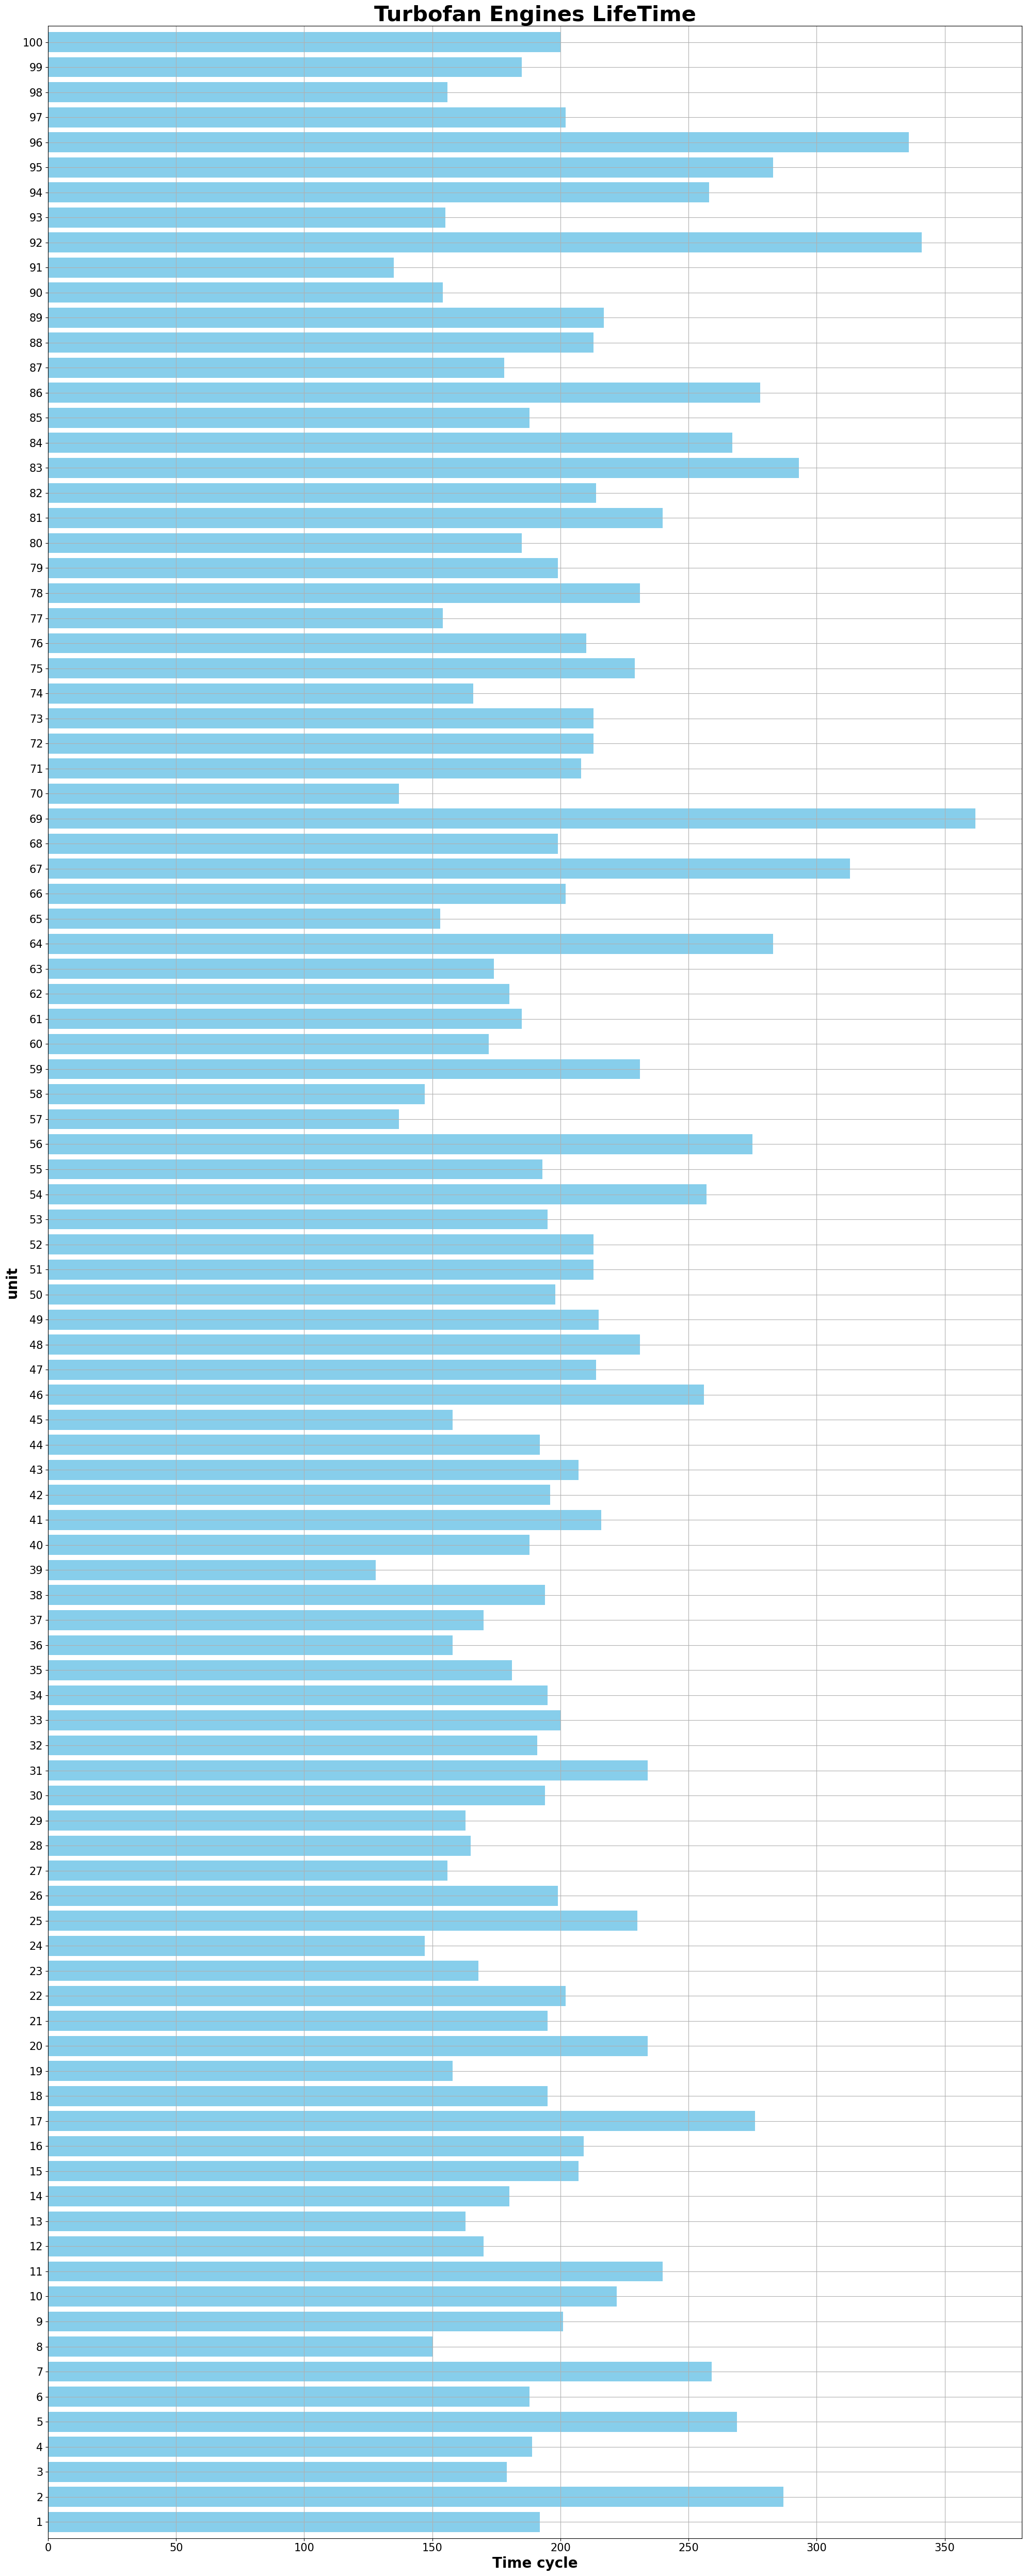

In [45]:
# Find maximum time cycles for each unit
max_time_cycles = train[index_names].groupby('unit_number').max()

# Set up the plot
plt.figure(figsize=(20, 50))
ax = max_time_cycles['time_cycles'].plot(kind='barh', width=0.8, color='skyblue', stacked=True, align='center')  # Modify color here

# Customize plot aesthetics
plt.title('Turbofan Engines LifeTime', fontweight='bold', size=30)
plt.xlabel('Time cycle', fontweight='bold', size=20)
plt.xticks(size=15)
plt.ylabel('unit', fontweight='bold', size=20)
plt.yticks(size=15)
plt.grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

### Distribution of Maximum Time Cycles of Turbofan Engines

The following plot shows the distribution of the **maximum time cycles** that turbofan engines have gone through before potentially failing. Each engine's maximum time cycle represents the number of operational cycles the engine completed. The plot consists of a **histogram** and a **Kernel Density Estimate (KDE)**, which helps visualize the distribution more smoothly.

- **Max Time Cycle**: The maximum number of cycles an engine has undergone during its lifetime.
- **Histogram**: Represents the frequency distribution of the maximum time cycles across all engines.
- **KDE Curve**: Adds a smoothed line to show the estimated distribution of the data.

From this plot, we can observe the overall lifetime distribution of the turbofan engines and how many engines have higher or lower maximum time cycles.


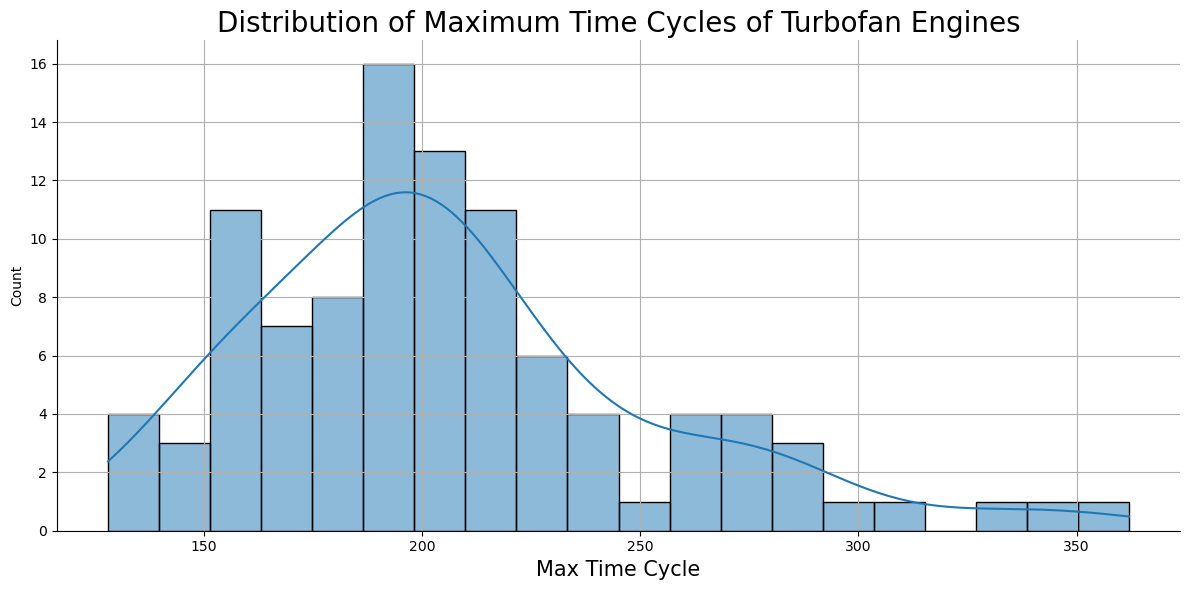

In [51]:
# Distribution of maximum time cycles for turbofan engines
sns.displot(max_time_cycles['time_cycles'], kde=True, bins=20, height=6, aspect=2)

# Customize plot aesthetics
plt.xlabel('Max Time Cycle', fontsize=15)
plt.title('Distribution of Maximum Time Cycles of Turbofan Engines', fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()


From the plot, we can observe that the maximum time cycles achieved by most engines typically fall between **190 and 210 cycles** before experiencing **High Pressure Compressor (HPC) failure**. This suggests that, for the majority of turbofan engines in the dataset, the lifetime before failure is concentrated in this range.


### Adding the RUL (Remaining Useful Life) Column

In this step, we add the **RUL** (Remaining Useful Life) column to the dataset, which represents the number of remaining cycles before the engine reaches failure. The RUL for each row is calculated by subtracting the current cycle (`time_cycles`) from the maximum cycle of that specific engine.

- **RUL Calculation**: `RUL = max(time_cycles) - time_cycles`
- The **RUL** is expected to be `0` for the last recorded cycle of each engine, indicating that it has reached failure.

By adding the RUL column, we now have the target variable that can be used for predictive maintenance models to forecast the time remaining until failure.


In [60]:
def add_RUL_column(df):
    # Group the data by 'unit_number' to find the maximum cycle time for each unit
    train_grouped_by_unit = df.groupby(by='unit_number')
    
    # Get the maximum time cycles for each unit (engine)
    max_time_cycles = train_grouped_by_unit['time_cycles'].max()
    
    # Merge the max cycle information back to the original dataframe
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number', right_index=True)
    
    # Calculate Remaining Useful Life (RUL) as the difference between max cycle and current cycle
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    
    # Drop the 'max_time_cycle' column as it's no longer needed
    merged = merged.drop("max_time_cycle", axis=1)
    
    return merged


In [62]:
train = add_RUL_column(train)

In [68]:
# Check the first few rows of the updated dataframe
print(train[['unit_number', 'time_cycles', 'RUL']].head())


   unit_number  time_cycles  RUL
0            1            1  191
1            1            2  190
2            1            3  189
3            1            4  188
4            1            5  187


In [70]:
# Get the maximum RUL for each unit (engine)
maxrul_u = train.groupby('unit_number')['RUL'].max().reset_index()

# Display the first few rows of the result
maxrul_u.head()


unit_number  RUL
0            1  191
1            2  286
2            3  178
3            4  188
4            5  268

### RUL Analysis: Maximum Remaining Useful Life for Each Engine

In this step, we are analyzing the **maximum Remaining Useful Life (RUL)** for each engine in the dataset. The RUL represents the number of cycles left before each engine reaches failure.

- We group the data by `unit_number`, which represents each engine, and calculate the **maximum RUL** for each engine.
- The `max()` function helps us extract the last recorded cycle time for each engine, which is then used to calculate the RUL.
- The result provides insight into the overall lifespan of each engine before failure.

This analysis is crucial for understanding the range of engine lifetimes, which will help in predicting when an engine might fail based on its current operational state.


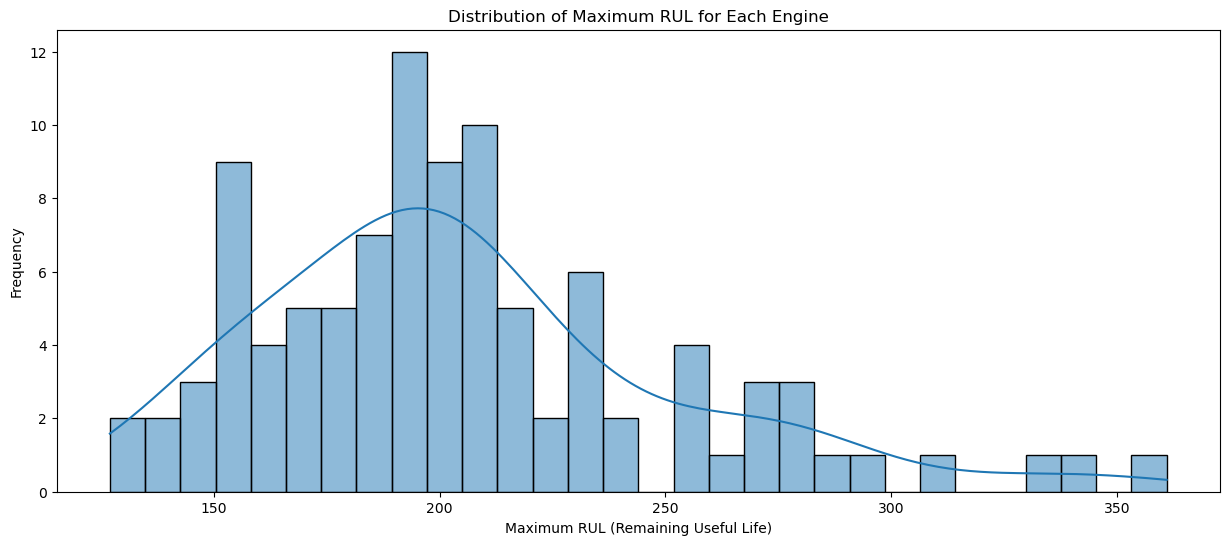

In [72]:
# Plotting the maximum RUL for each engine (unit)
plt.figure(figsize=(15, 6))
sns.histplot(maxrul_u['RUL'], kde=True, bins=30)
plt.title('Distribution of Maximum RUL for Each Engine')
plt.xlabel('Maximum RUL (Remaining Useful Life)')
plt.ylabel('Frequency')
plt.show()


### Feature Correlation Heatmap

In this step, we visualize the correlation between the features (sensors and settings) in the training dataset using a heatmap. The heatmap displays the correlation coefficient values between all pairs of features.

- **Correlation**: Values range from -1 to 1, where:
  - **1** indicates a perfect positive correlation,
  - **-1** indicates a perfect negative correlation,
  - **0** indicates no correlation.

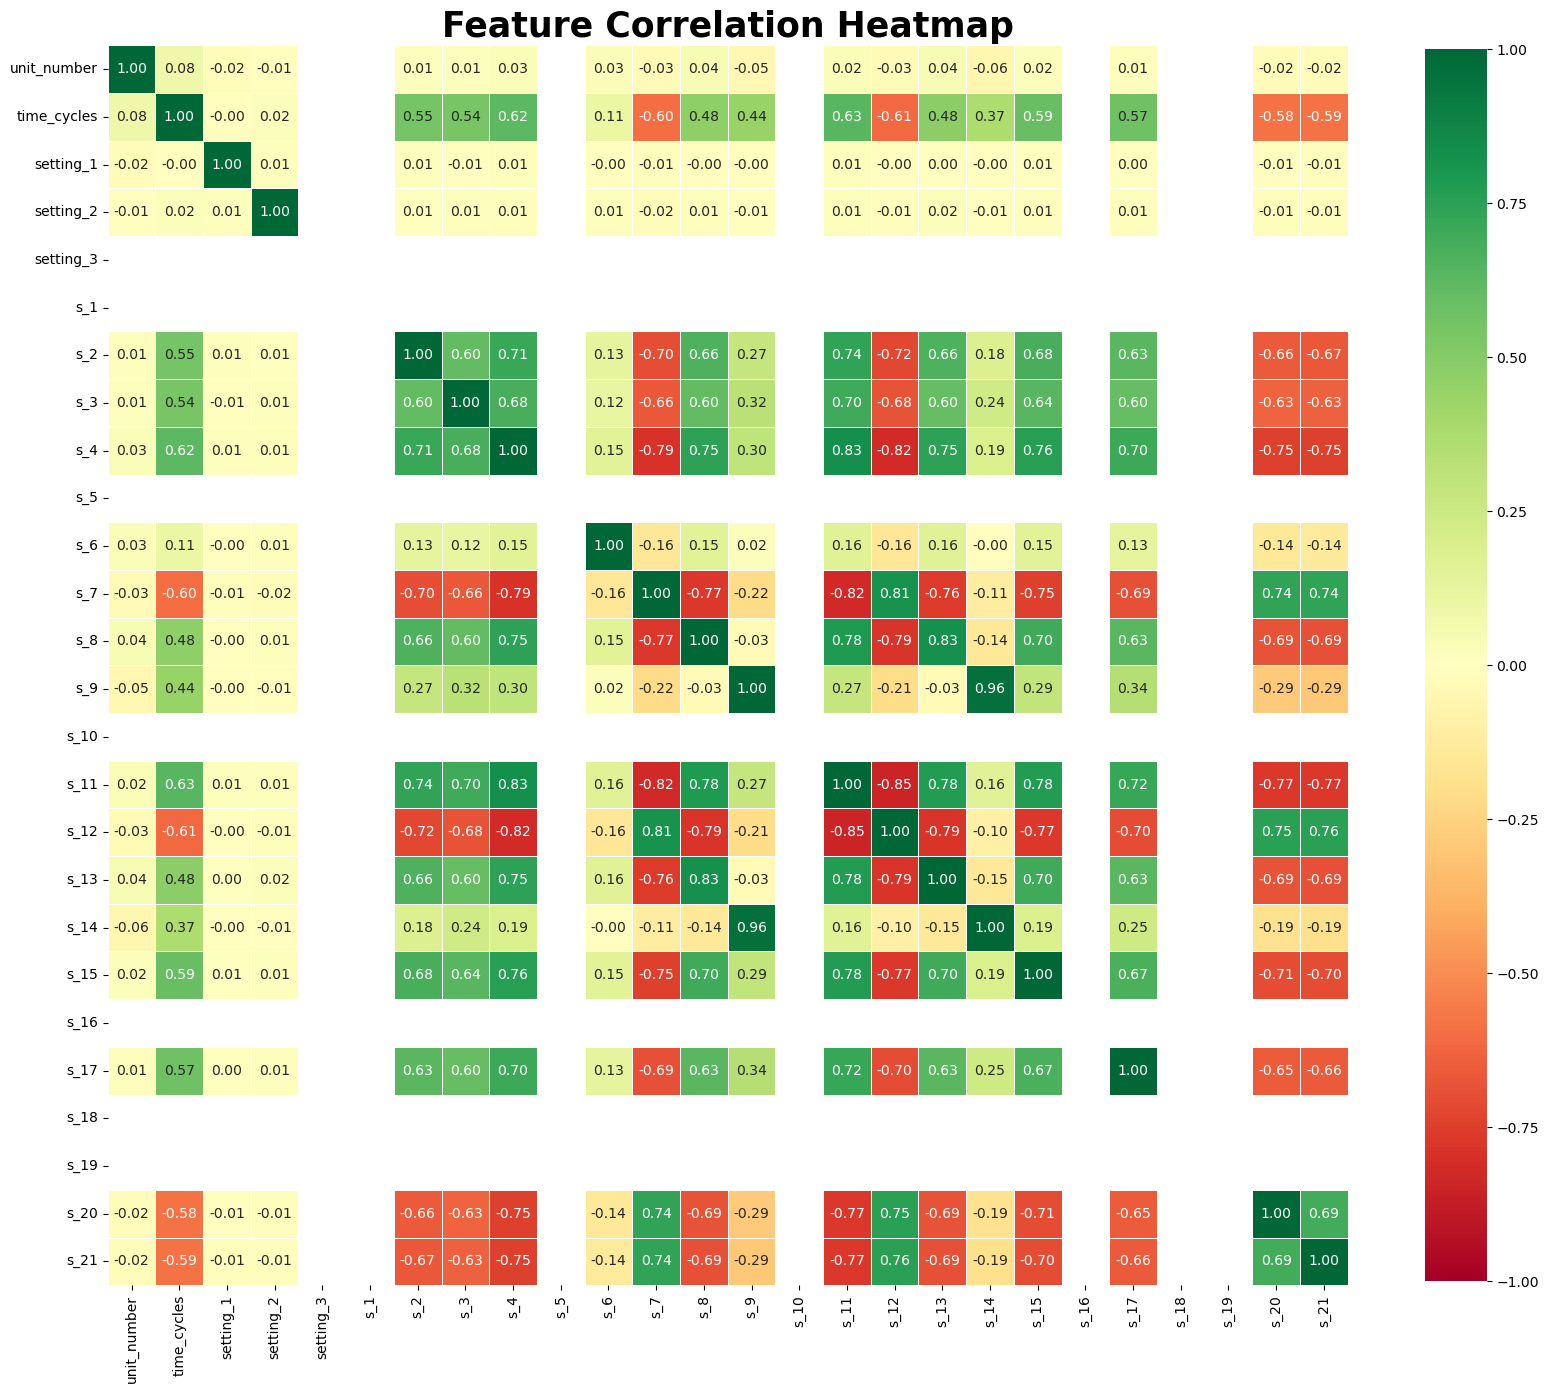

In [76]:
# Plotting a heatmap with Seaborn
plt.figure(figsize=(20, 20))  # Setting the figure size before the plot

# Plot the correlation heatmap
sns.heatmap(dftrain.corr(), annot=True, cmap='RdYlGn', fmt=".2f", linewidths=0.5, square=True, 
            cbar_kws={"shrink": 0.8}, annot_kws={"size": 10}, vmin=-1, vmax=1)

# Adding title for clarity
plt.title("Feature Correlation Heatmap", fontweight='bold', fontsize=25)

# Display the plot
plt.show()


### Correlation Matrix of the Training Dataset

In this step, we visualize the correlation between different features in the training dataset using a **correlation heatmap**. The heatmap shows the correlation coefficient between each pair of features, which ranges from -1 (perfect negative correlation) to 1 (perfect positive correlation). Values close to 0 indicate weak or no correlation.

This analysis helps to understand which features are highly correlated with each other and help us in feature selection or engineering.


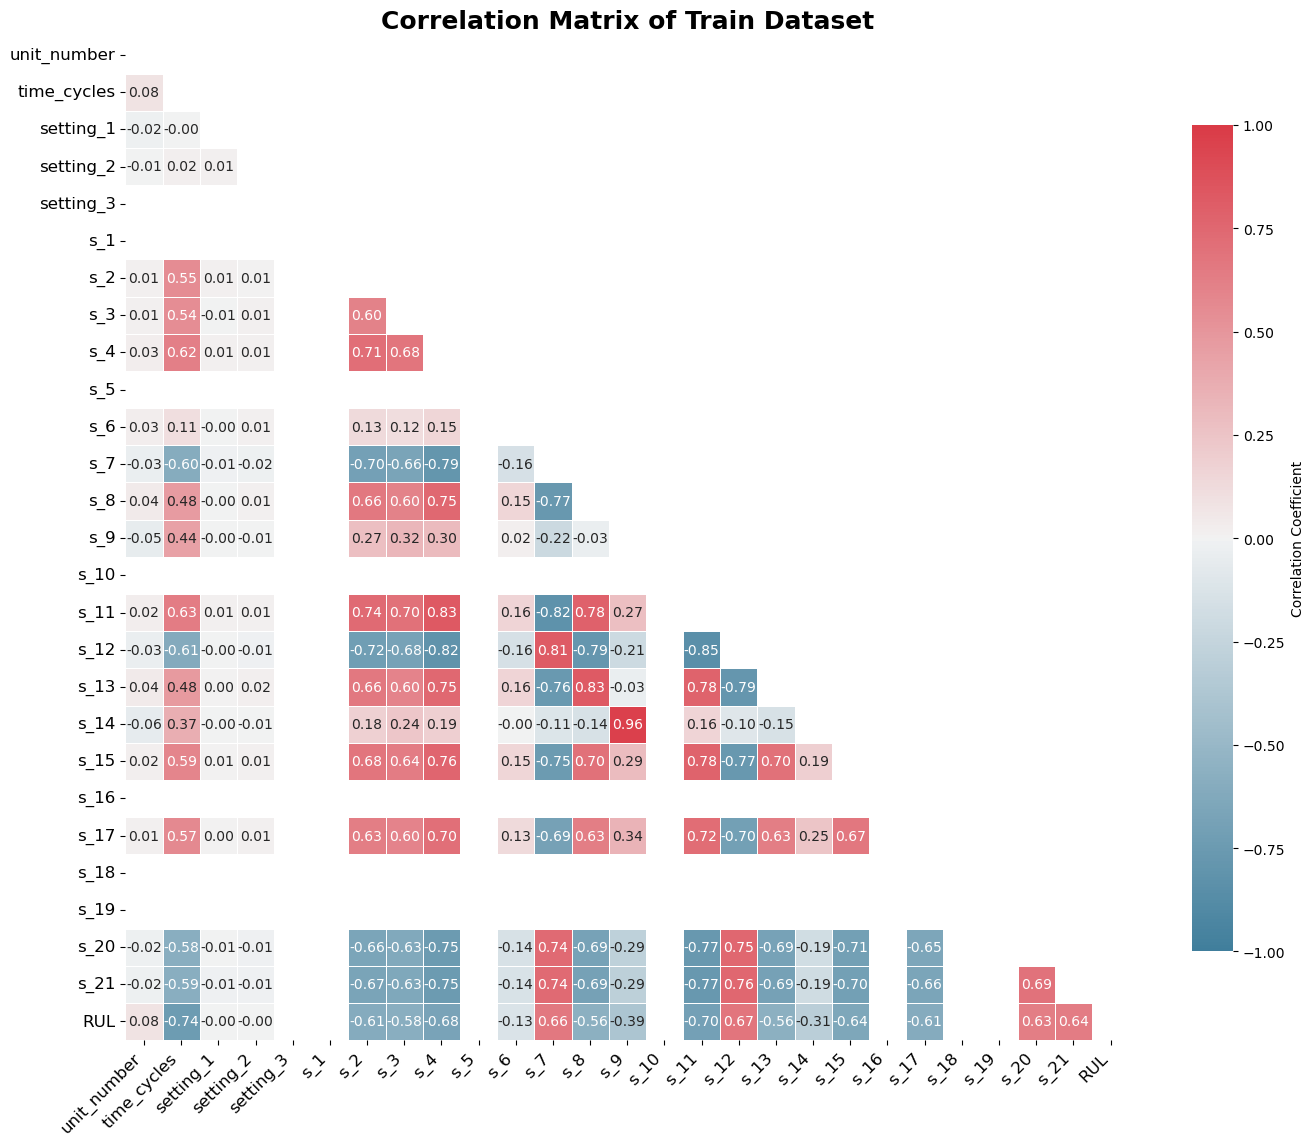

In [82]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 12))  # Increased figure size for clarity

# Define a custom colormap for better visual contrast
cmap = sns.diverging_palette(230, 10, as_cmap=True)

# Draw the heatmap with customizations
sns.heatmap(
    corr, 
    mask=mask, 
    cmap=cmap, 
    vmax=1,  # Adjusted to max correlation value (1)
    vmin=-1,  # Adjusted to min correlation value (-1)
    center=0, 
    square=True, 
    annot=True,  # Display correlation values
    fmt=".2f",   # Limit to two decimal places
    linewidths=0.5, 
    cbar_kws={"shrink": .75, "label": "Correlation Coefficient"}  # Custom color bar label
)

# Add title and labels
plt.title("Correlation Matrix of Train Dataset", fontweight='bold', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Increased fontsize for clarity
plt.yticks(rotation=0, fontsize=12)  # Increased fontsize for clarity

# Display the heatmap
plt.tight_layout()
plt.show()


In [87]:
# Define the list of sensor descriptions
dict_list = [
    "(Fan inlet temperature) (◦R)",
    "(LPC outlet temperature) (◦R)",
    "(HPC outlet temperature) (◦R)",
    "(LPT outlet temperature) (◦R)",
    "(Fan inlet Pressure) (psia)",
    "(bypass-duct pressure) (psia)",
    "(HPC outlet pressure) (psia)",
    "(Physical fan speed) (rpm)",
    "(Physical core speed) (rpm)",
    "(Engine pressure ratio(P50/P2)",
    "(HPC outlet Static pressure) (psia)",
    "(Ratio of fuel flow to Ps30) (pps/psia)",
    "(Corrected fan speed) (rpm)",
    "(Corrected core speed) (rpm)",
    "(Bypass Ratio)",
    "(Burner fuel-air ratio)",
    "(Bleed Enthalpy)",
    "(Required fan speed)",
    "(Required fan conversion speed)",
    "(High-pressure turbines Cool air flow)",
    "(Low-pressure turbines Cool air flow)"
]

# Use dictionary comprehension to create the sensor dictionary
Sensor_dictionary = {f's_{i+1}': sensor for i, sensor in enumerate(dict_list)}

# Display the dictionary
Sensor_dictionary


{'s_1': '(Fan inlet temperature) (◦R)',
 's_2': '(LPC outlet temperature) (◦R)',
 's_3': '(HPC outlet temperature) (◦R)',
 's_4': '(LPT outlet temperature) (◦R)',
 's_5': '(Fan inlet Pressure) (psia)',
 's_6': '(bypass-duct pressure) (psia)',
 's_7': '(HPC outlet pressure) (psia)',
 's_8': '(Physical fan speed) (rpm)',
 's_9': '(Physical core speed) (rpm)',
 's_10': '(Engine pressure ratio(P50/P2)',
 's_11': '(HPC outlet Static pressure) (psia)',
 's_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 's_13': '(Corrected fan speed) (rpm)',
 's_14': '(Corrected core speed) (rpm)',
 's_15': '(Bypass Ratio)',
 's_16': '(Burner fuel-air ratio)',
 's_17': '(Bleed Enthalpy)',
 's_18': '(Required fan speed)',
 's_19': '(Required fan conversion speed)',
 's_20': '(High-pressure turbines Cool air flow)',
 's_21': '(Low-pressure turbines Cool air flow)'}

### Engine Components Overview

- **Low Pressure Compressor (LPC)**: Compresses incoming air at low pressure before it enters the high-pressure compressor.
  
- **High Pressure Compressor (HPC)**: Further compresses the air at high pressure and temperature before sending it to the combustor.
  
- **Low Pressure Turbine (LPT)**: Extracts energy from exhaust gases to drive the LPC and improve engine efficiency.
  
- **High Pressure Turbine (HPT)**: Generates mechanical energy from high-pressure exhaust gases to power the HPC and other components.
  
- **Low-Pressure Rotor (N1) and High-Pressure Rotor (N2)**: N1 drives the LPC and LPT, while N2 drives the HPC and HPT, ensuring efficient combustion and airflow.
  
- **Nozzle**: Directs exhaust gases to produce thrust, converting gas pressure into kinetic energy.


# Evolution of Sensor Data with Remaining Useful Life (RUL)


In [93]:
def plot_signal(df, Sensor_dic, signal_name):
    plt.figure(figsize=(13,5))
    for i in df['unit_number'].unique():
        if (i % 10 == 0):   #For a better visualisation, we plot the sensors signals of 20 units only
            plt.plot('RUL', signal_name, data=df[df['unit_number']==i].rolling(10).mean())

    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(Sensor_dic[signal_name])
    plt.xlabel('Remaining Useful Life')
    plt.show()

### Evolution of Sensor Features with Remaining Useful Life (RUL)

The following plot illustrates the evolution of sensor features (such as temperature, pressure, etc.) as a function of the Remaining Useful Life (RUL) of the engine. The x-axis shows the Remaining Useful Life, while the y-axis represents the values of different sensor readings for each unit.

We are particularly interested in seeing how the sensor values change as the engine approaches failure. This allows us to gain insights into sensor behavior, identify patterns, and predict failure based on these sensor readings.

In the plot, we show the rolling average of sensor values for a better visualization of trends over time. The sensors with unusual behavior near the end of their lifetime might indicate critical factors leading to engine failure.



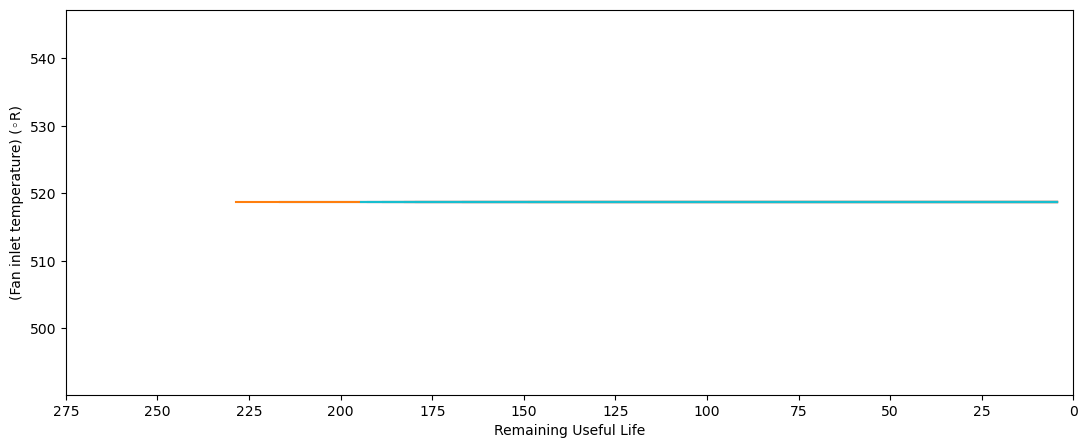

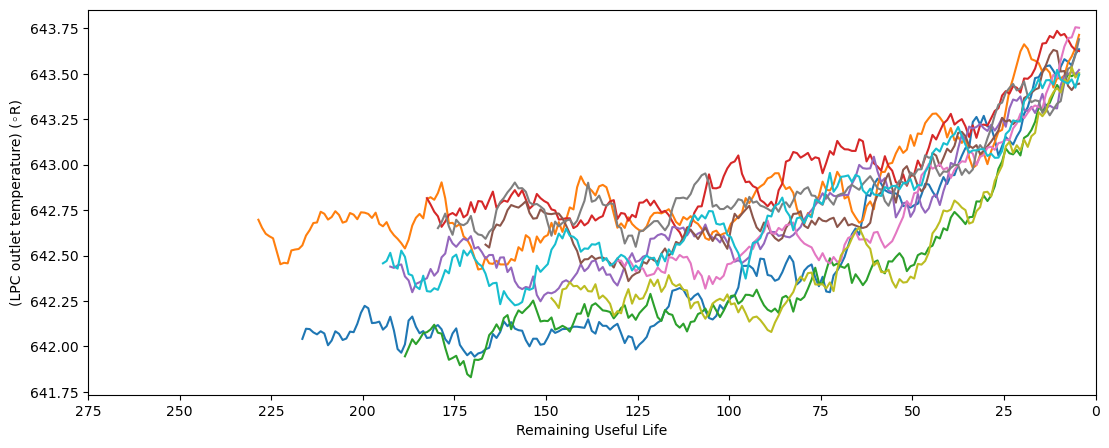

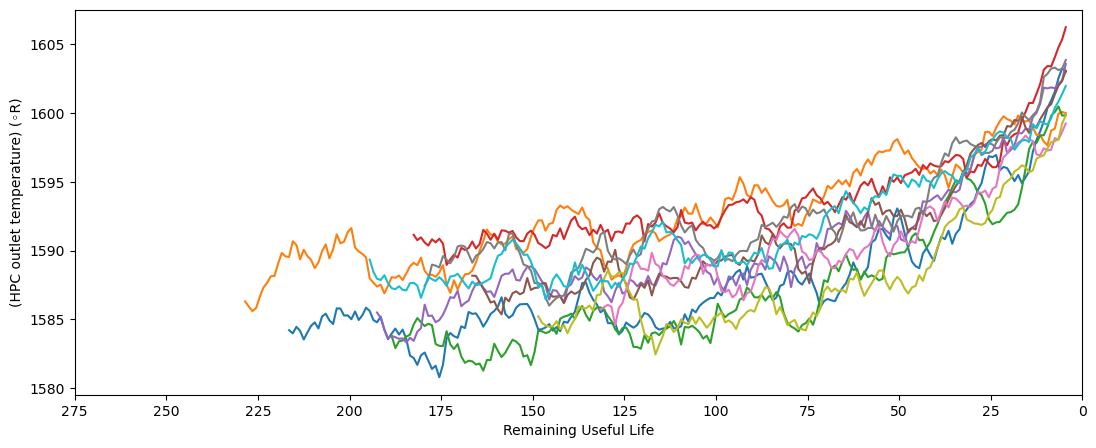

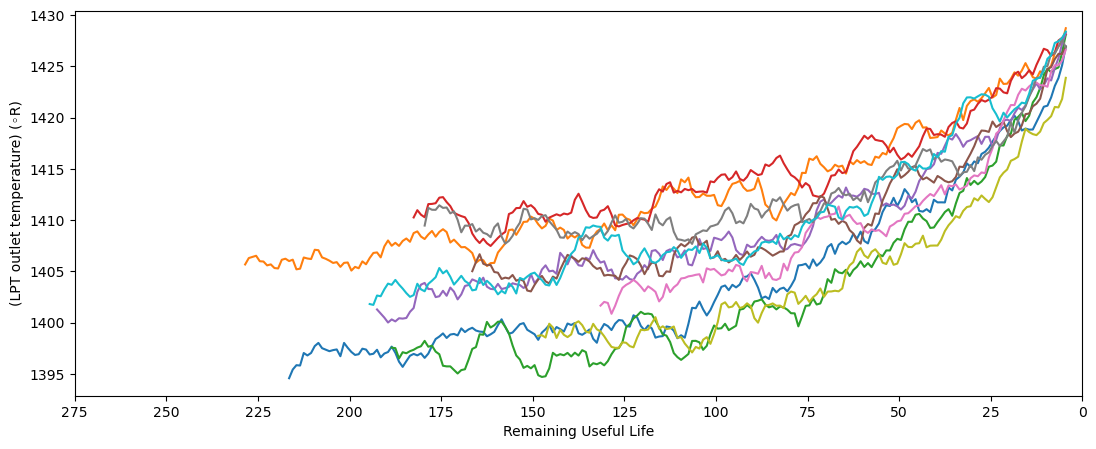

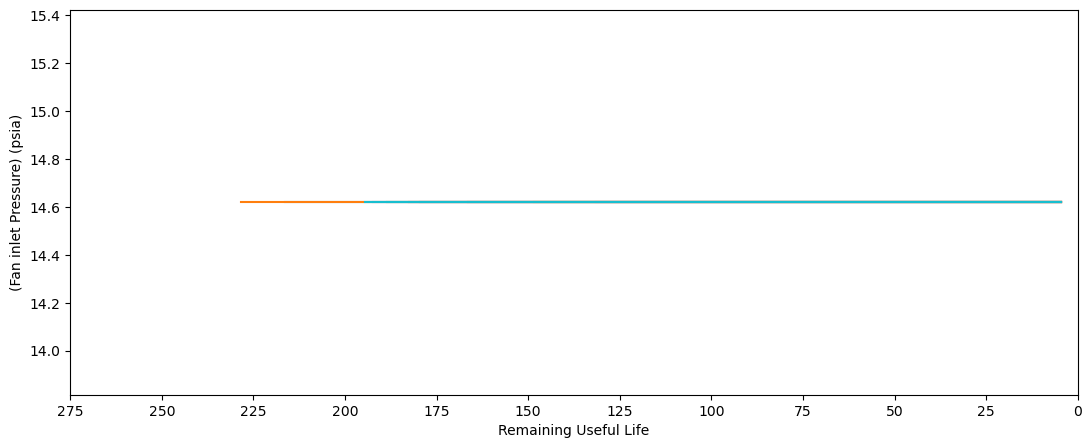

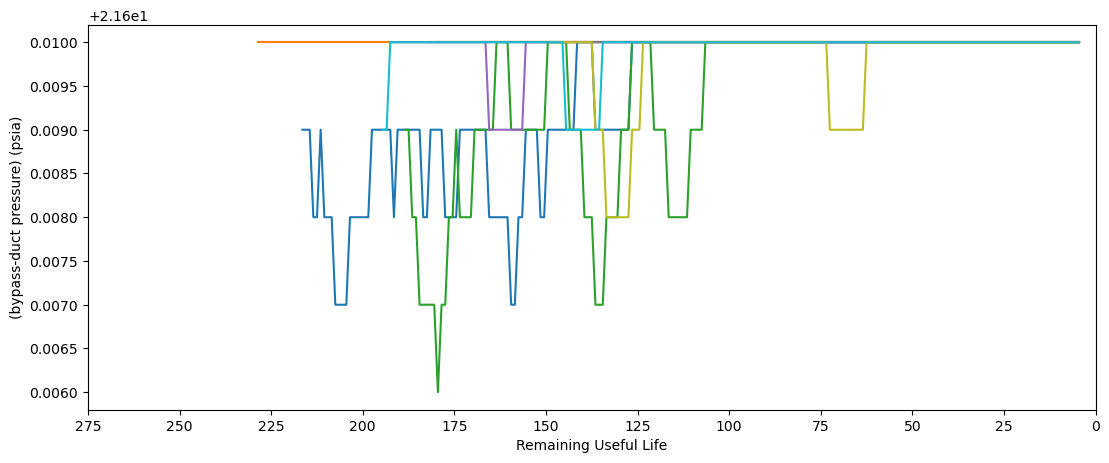

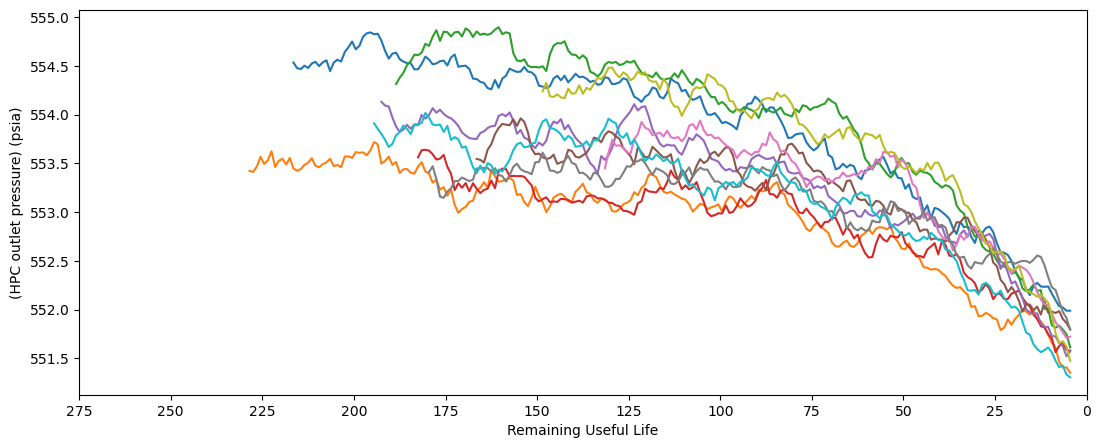

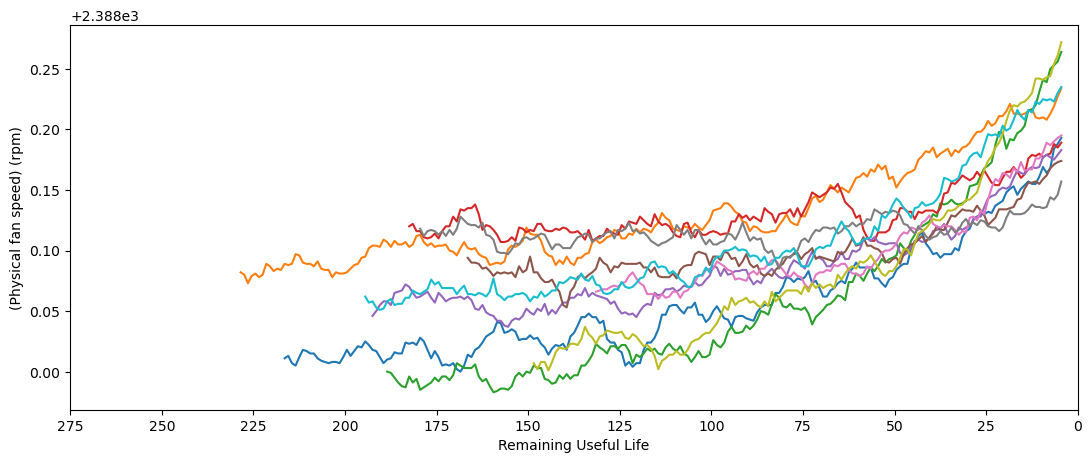

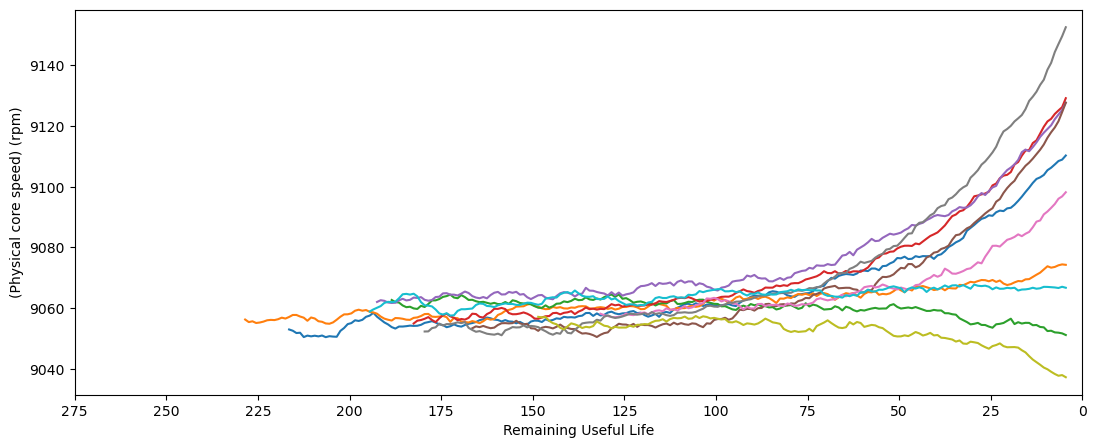

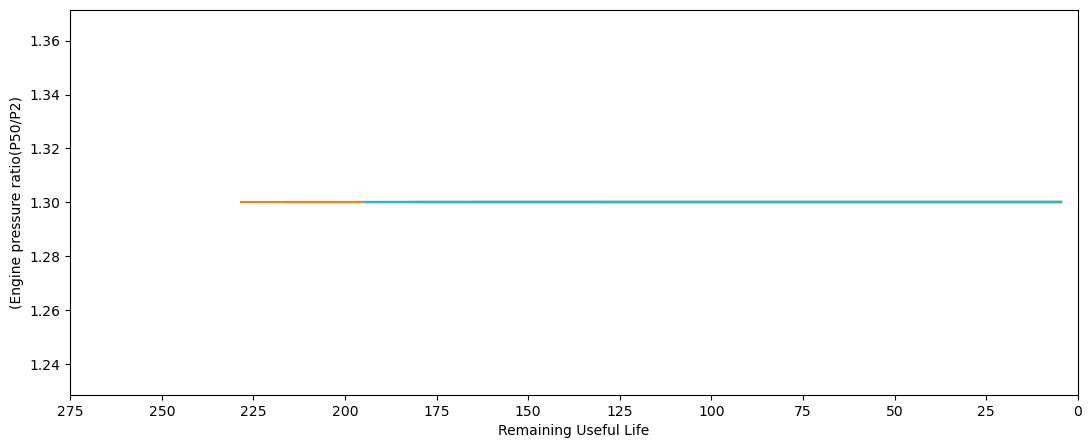

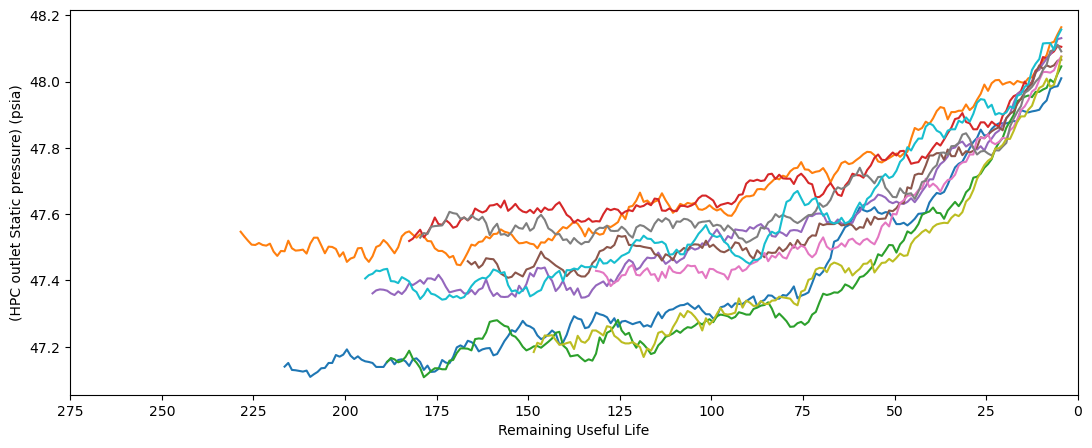

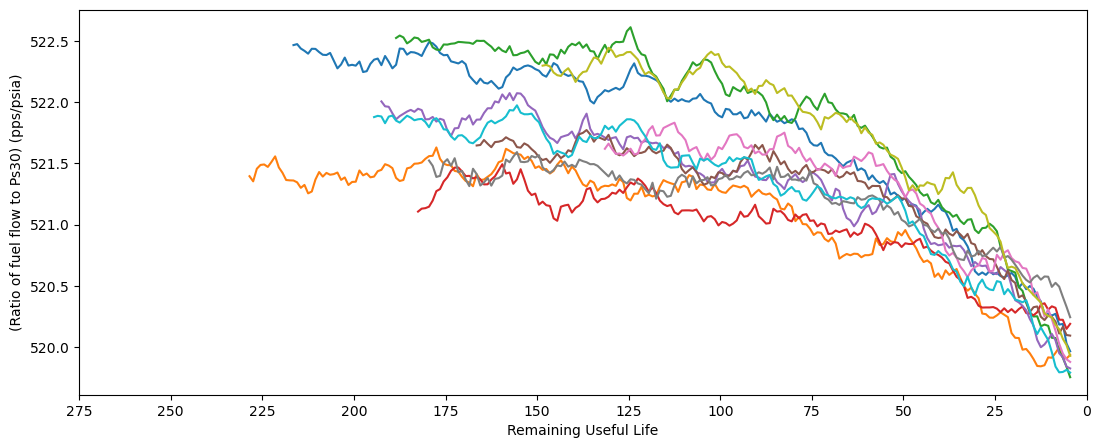

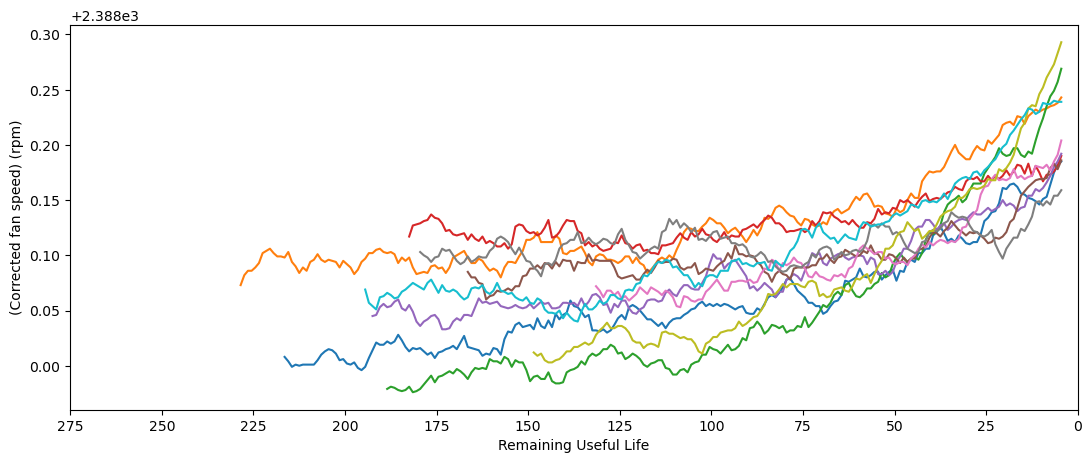

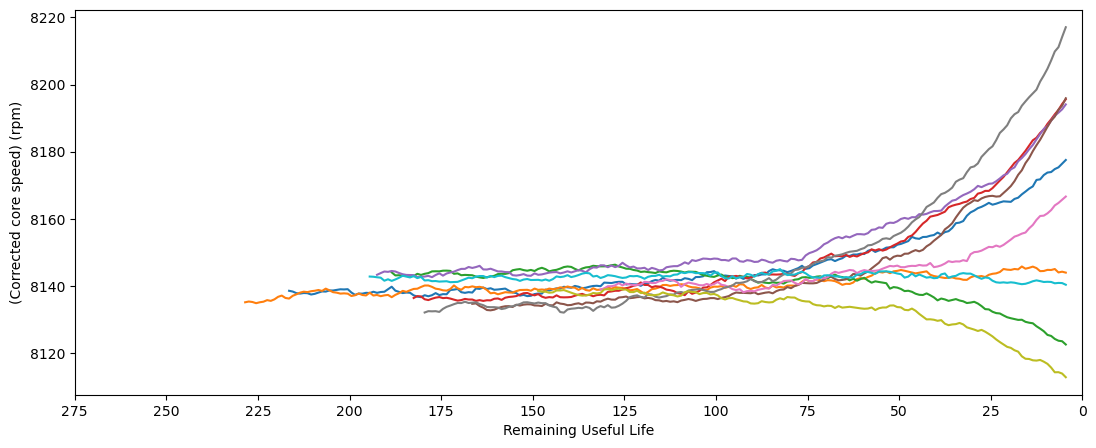

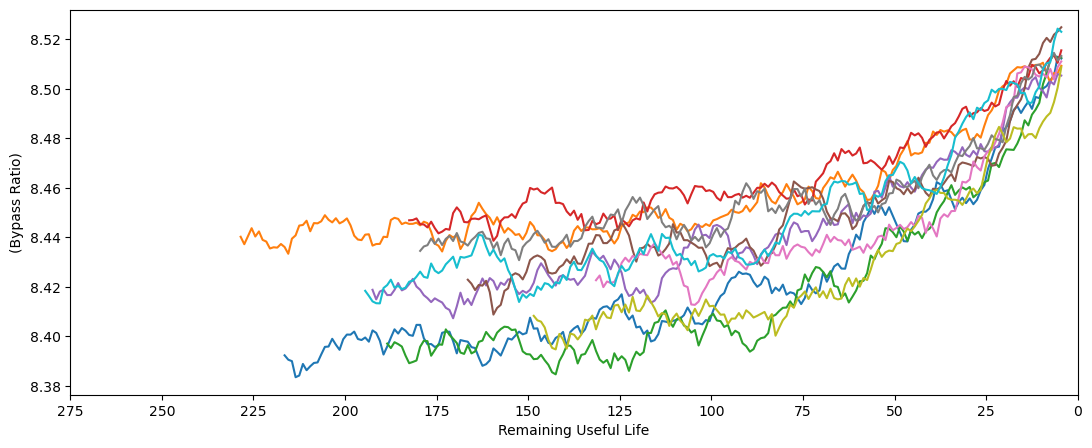

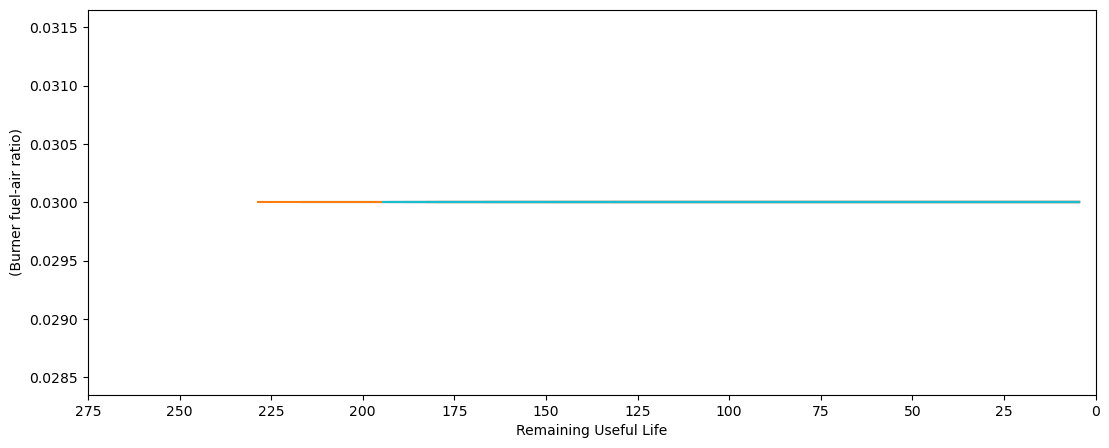

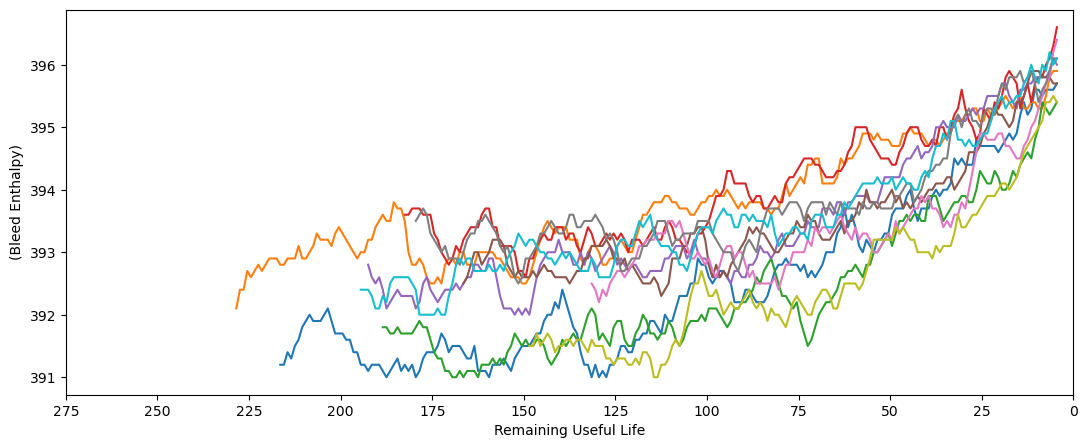

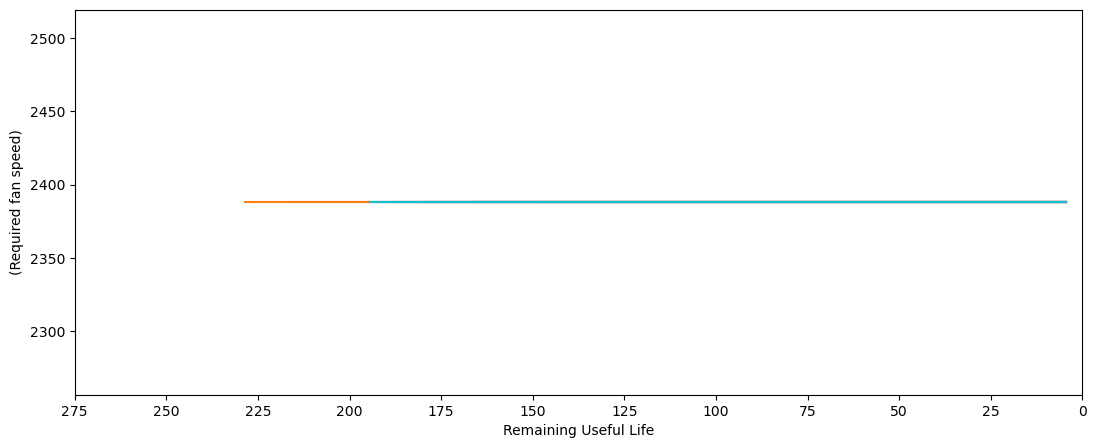

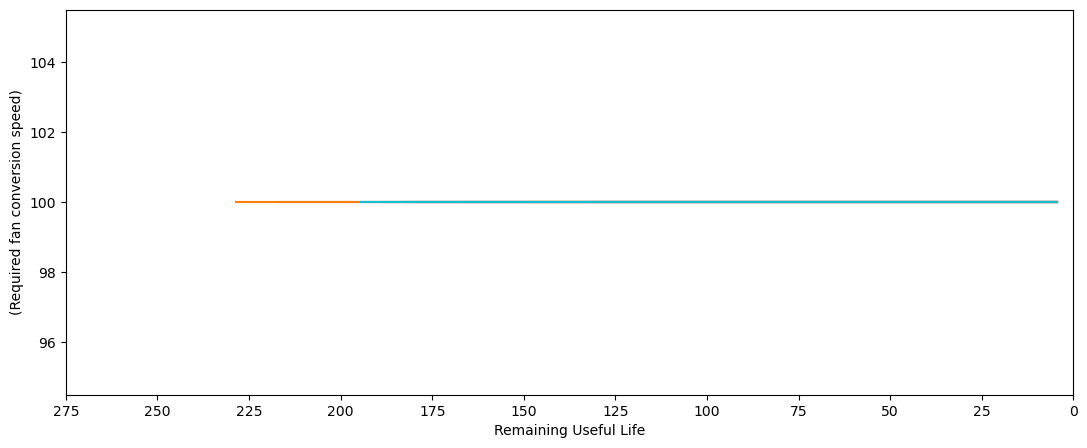

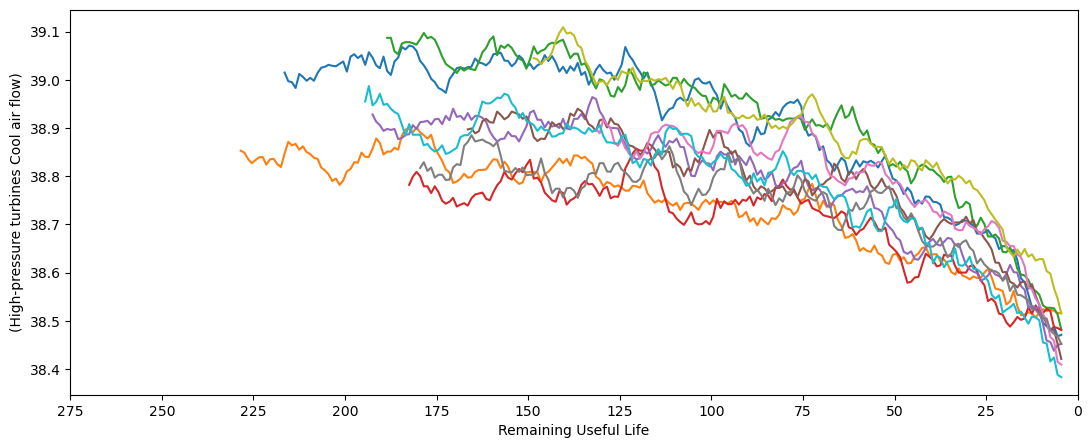

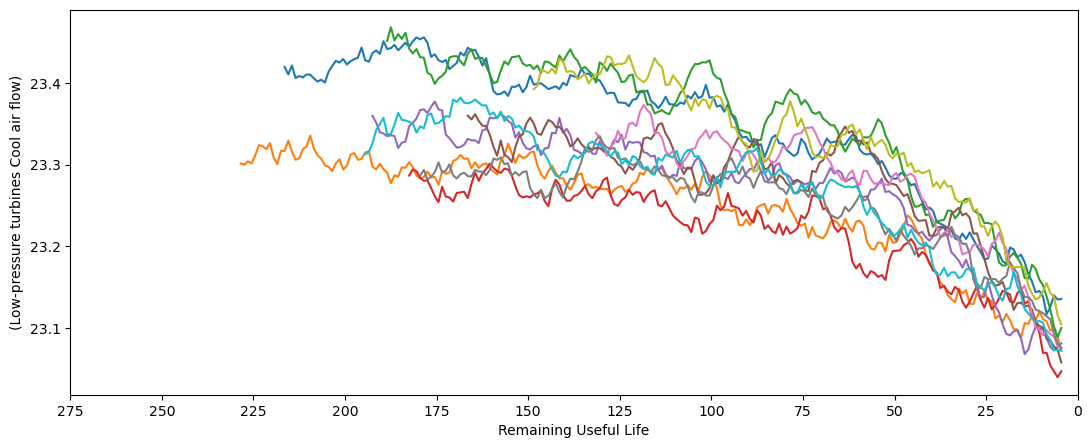

In [95]:
for i in range(1, 22):
    try:
        # Plot signal for each sensor 's_1' to 's_21'
        plot_signal(train, Sensor_dictionary, 's_' + str(i))
    except KeyError:
        # Handle case where the sensor might not be in the dataframe
        print(f"Sensor 's_{i}' not found in the dataset.")
    except Exception as e:
        # Catch any other exceptions and print the error message
        print(f"An error occurred while plotting sensor 's_{i}': {e}")


### Boxplot for Sensor Data

A box plot provides a summary of a dataset's distribution based on a five-number summary: minimum, first quartile (Q1), median, third quartile (Q3), and maximum. It also highlights outliers that may exist in the data.

The boxplots below represent the distribution of sensor values across the different units for each sensor. The x-axis represents different sensors, and the y-axis shows the values for each sensor. Each plot displays the range and outliers of the sensor readings.

We use the box plots to detect potential outliers in the sensor readings, and observe whether any sensor has unusually high or low values compared to others.



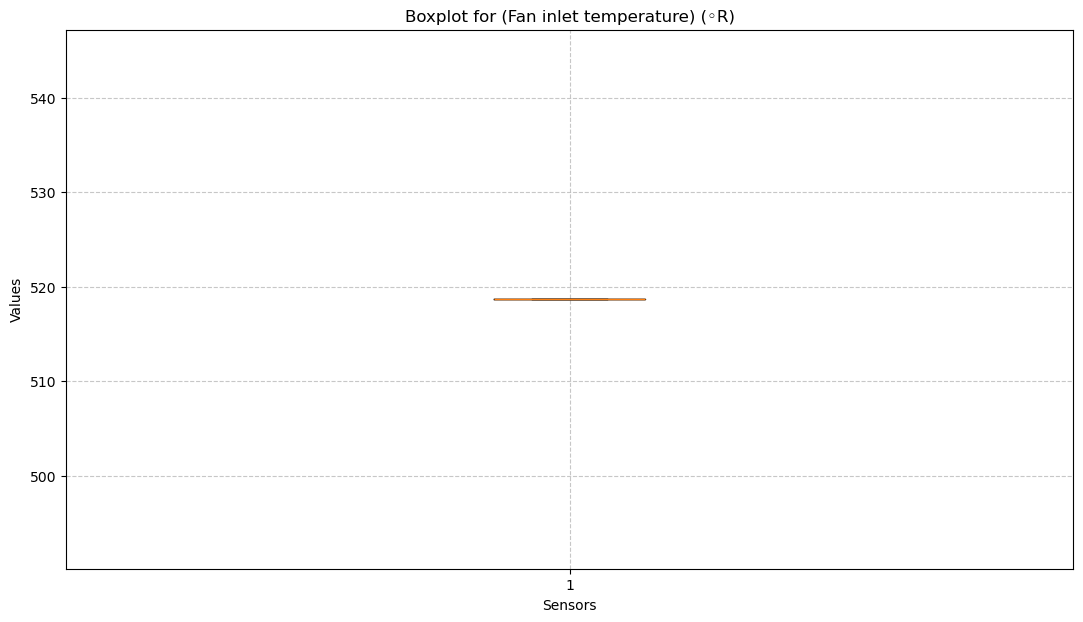

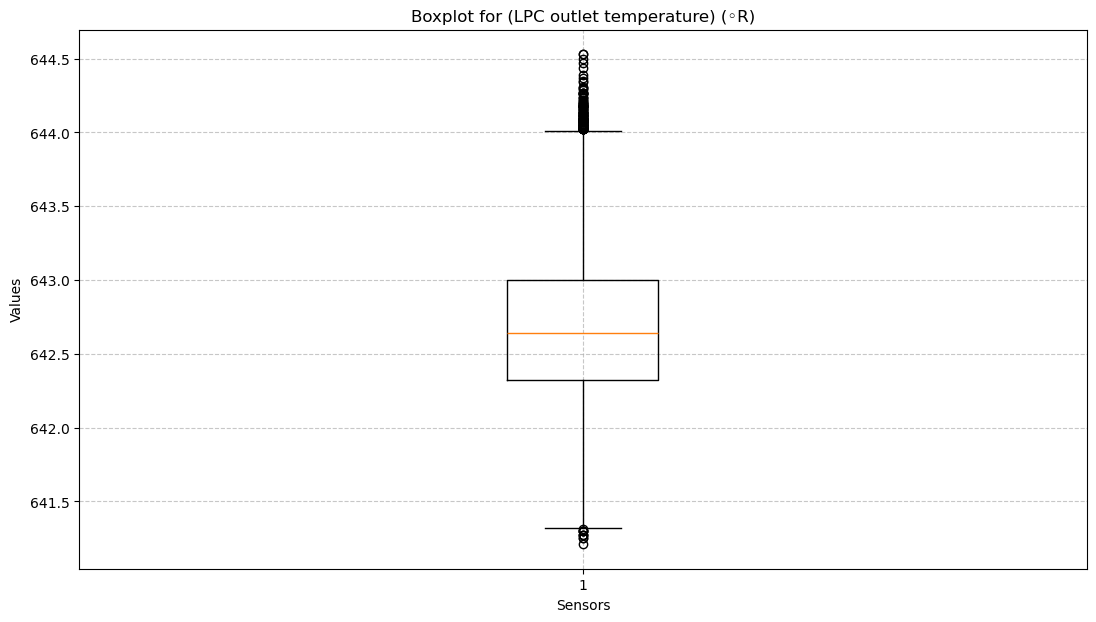

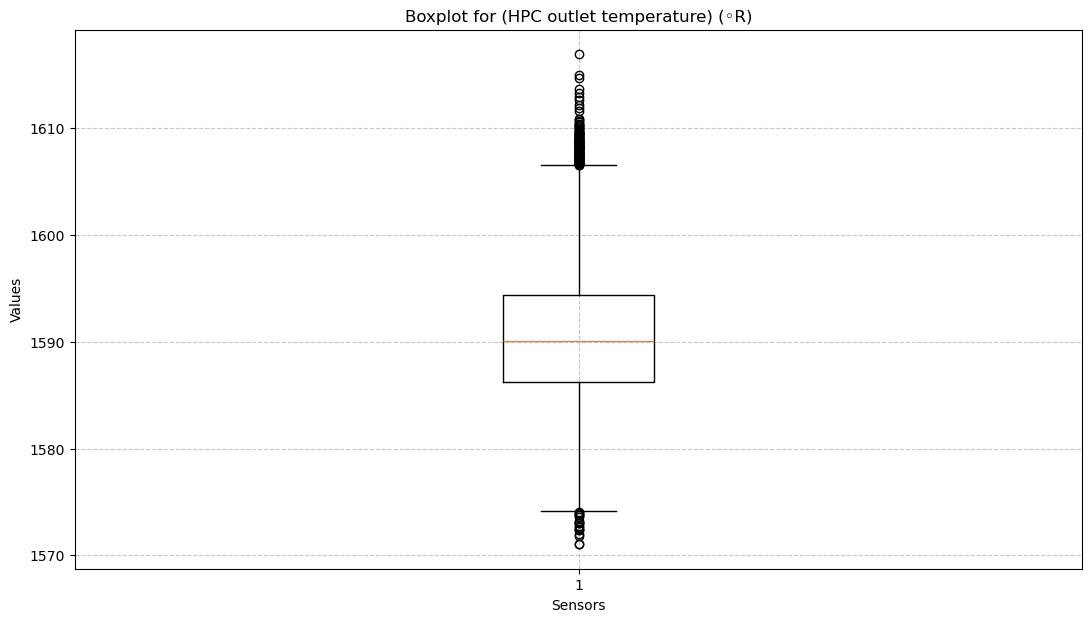

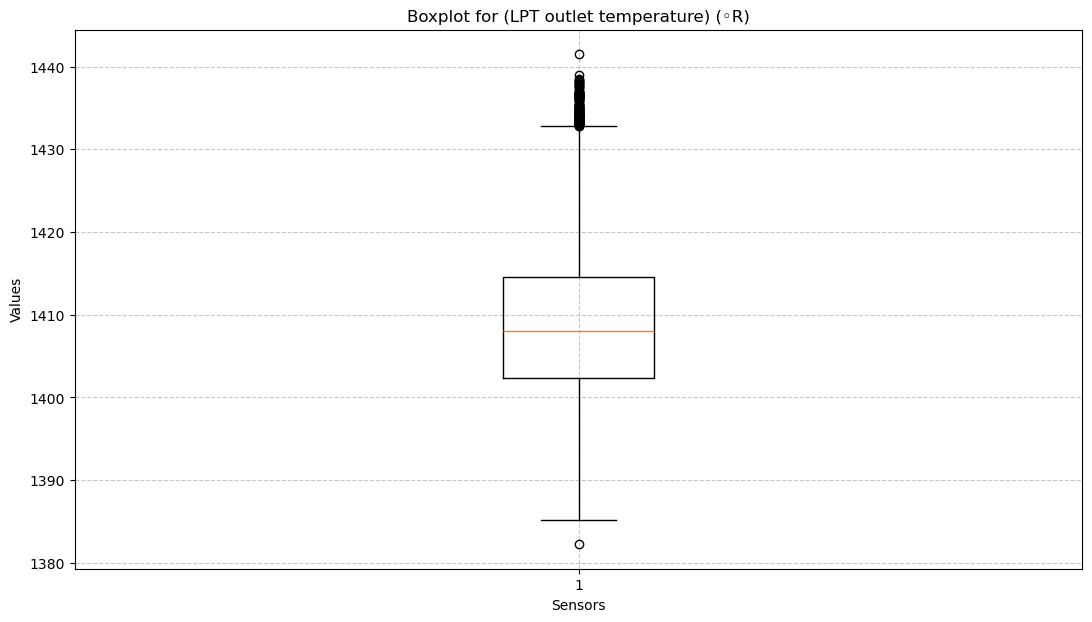

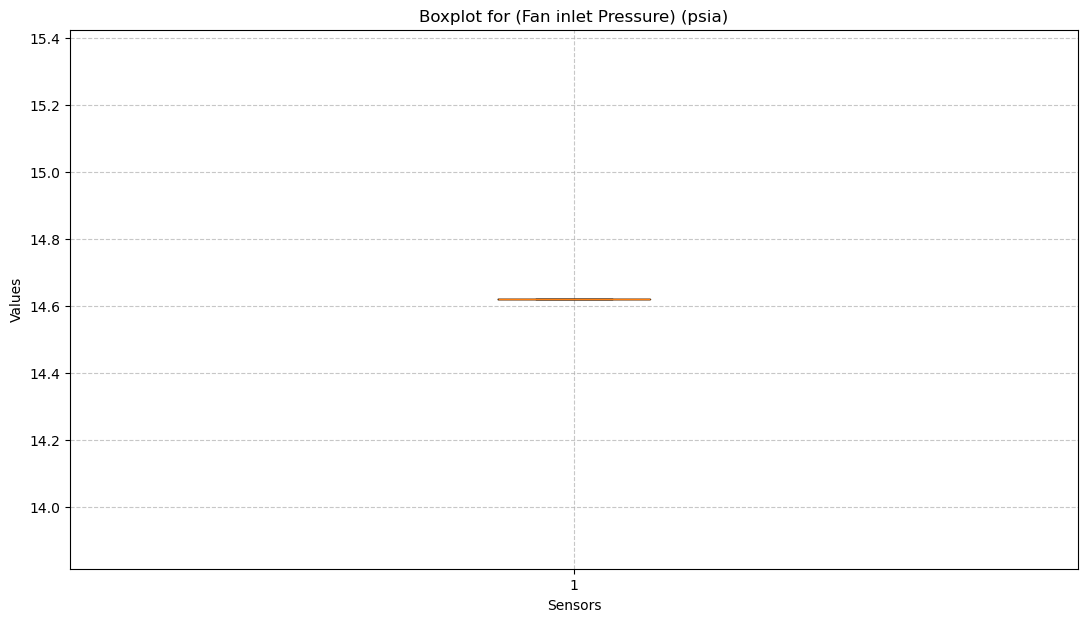

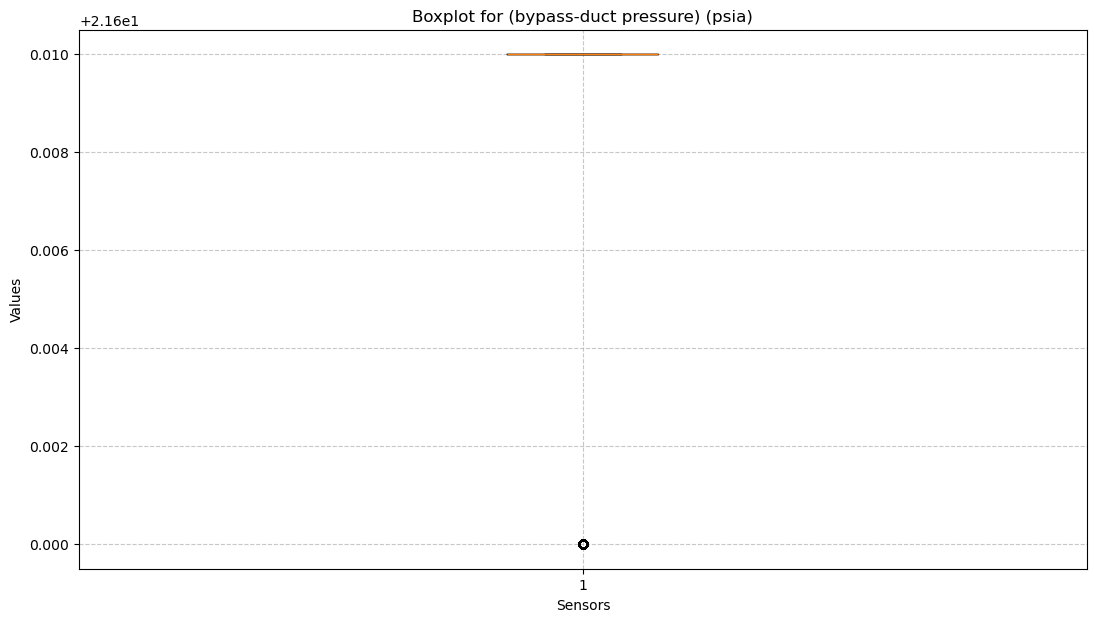

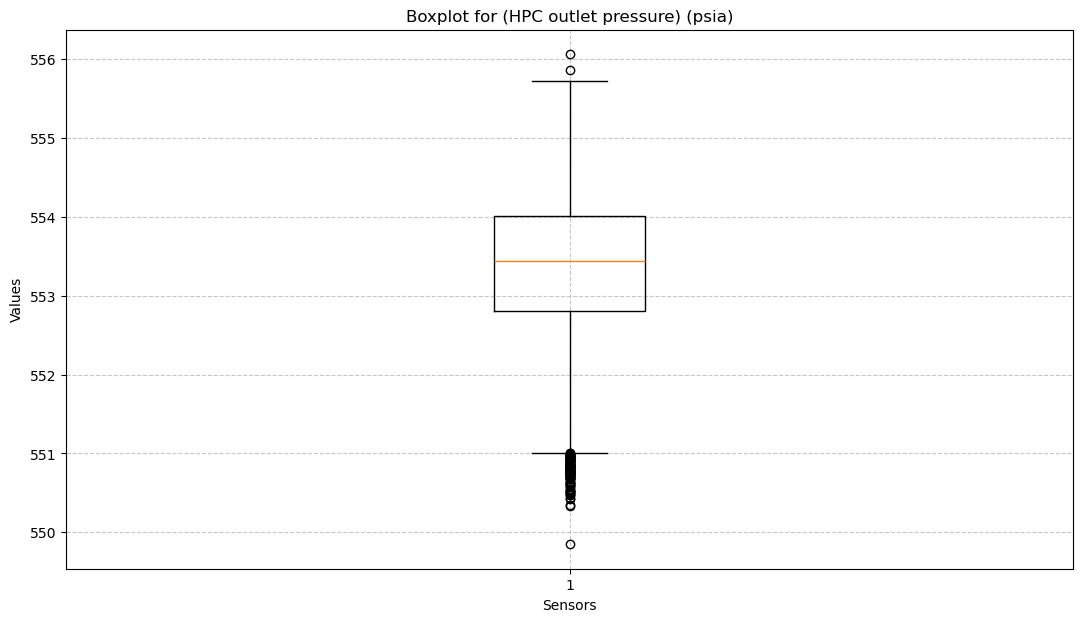

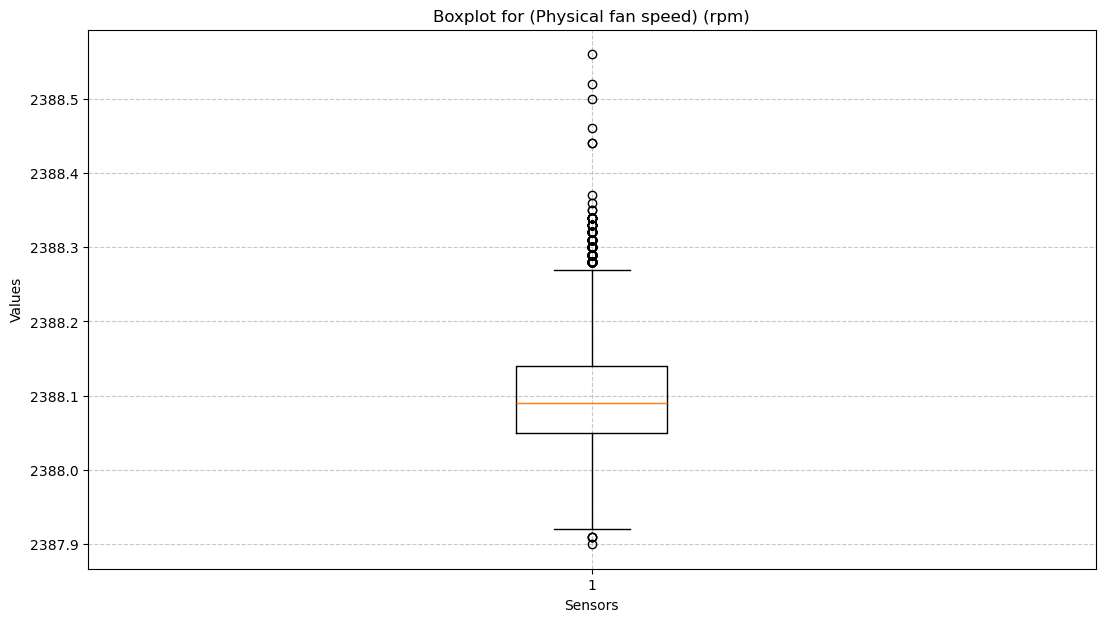

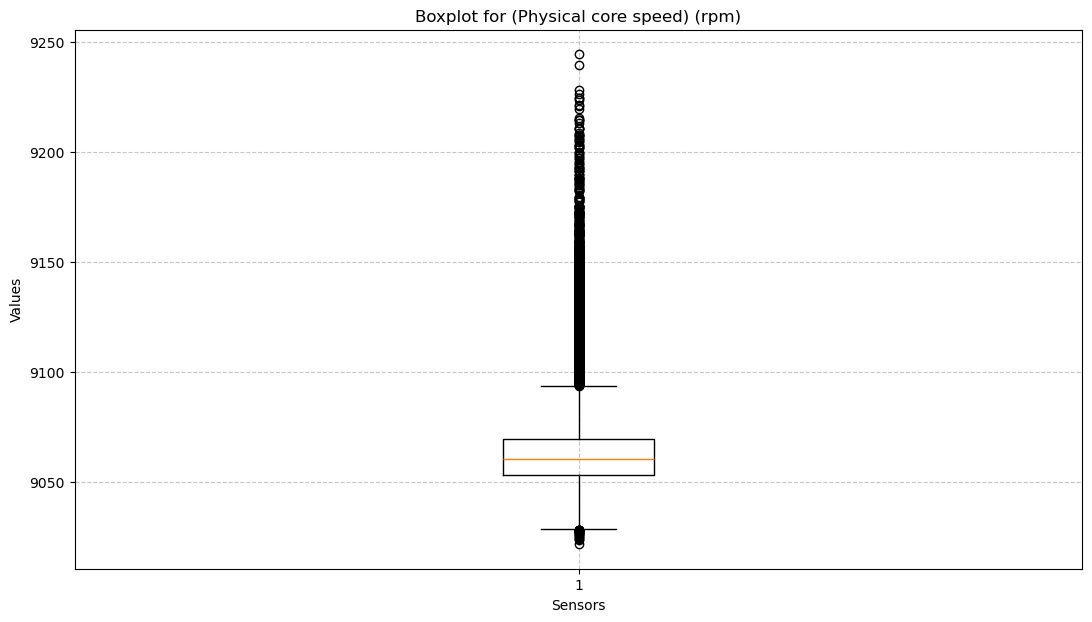

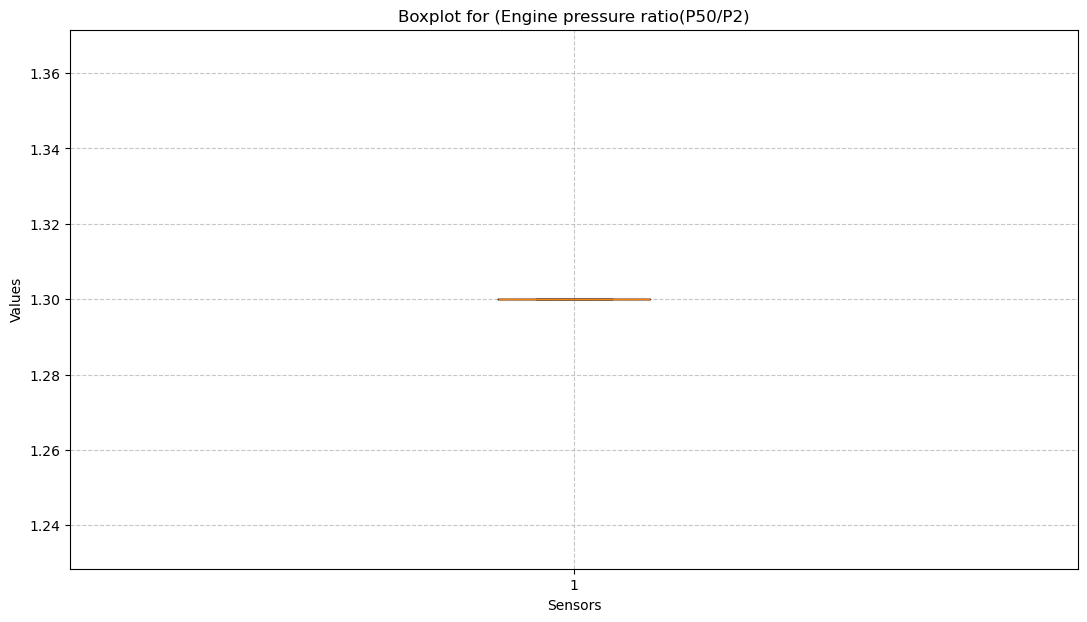

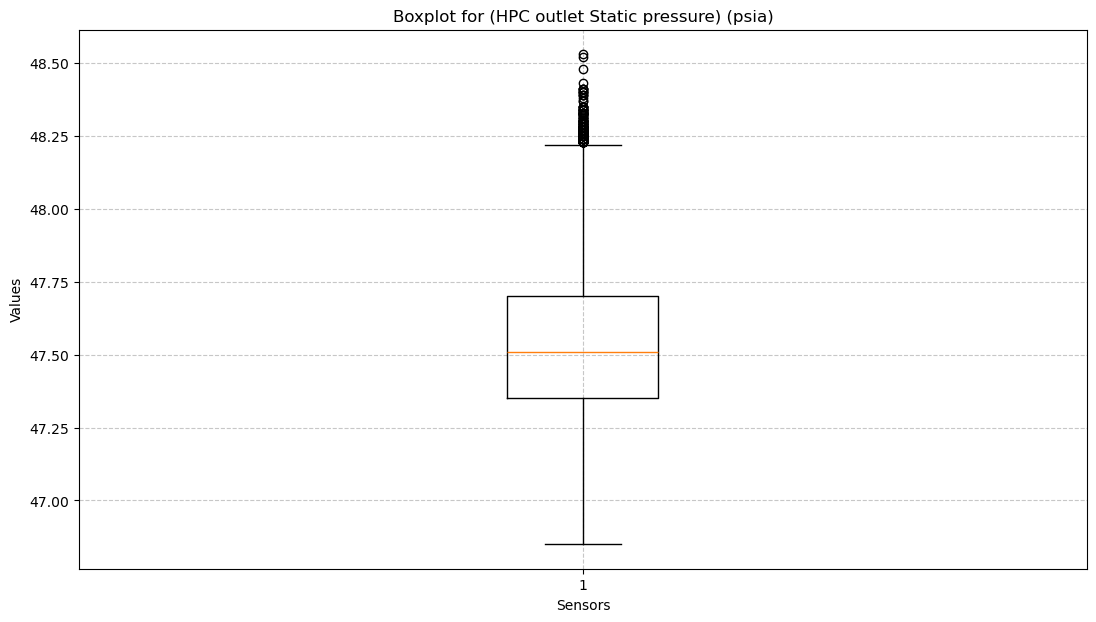

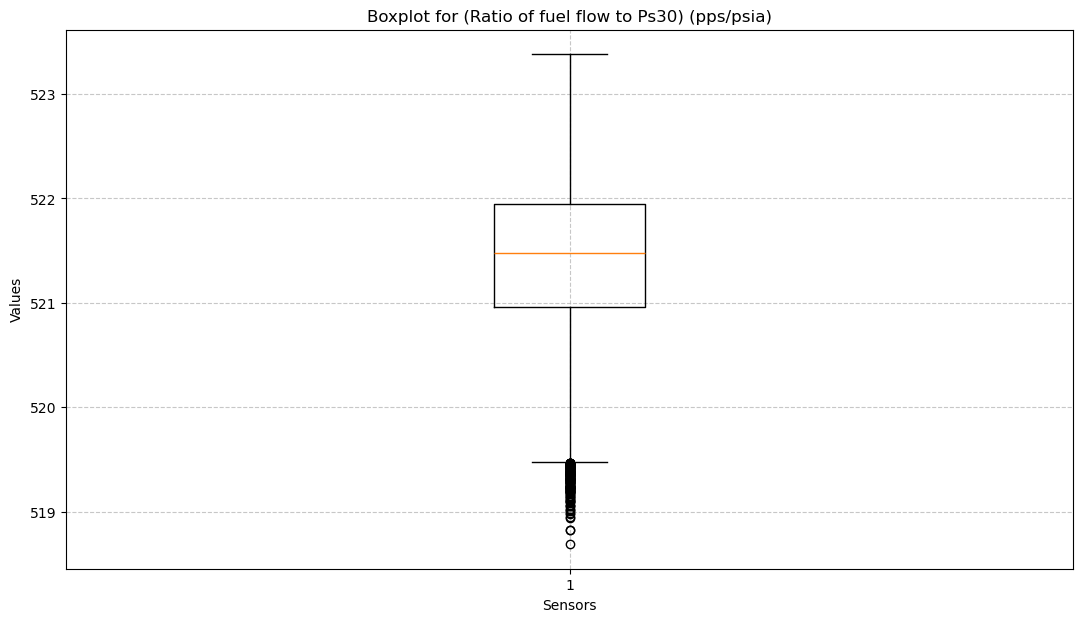

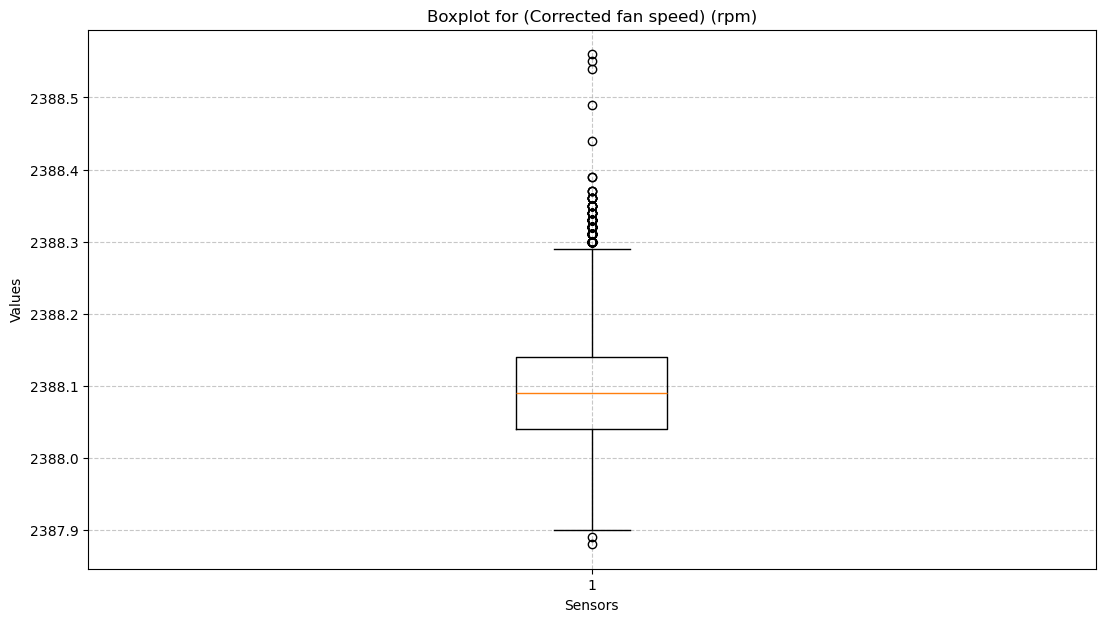

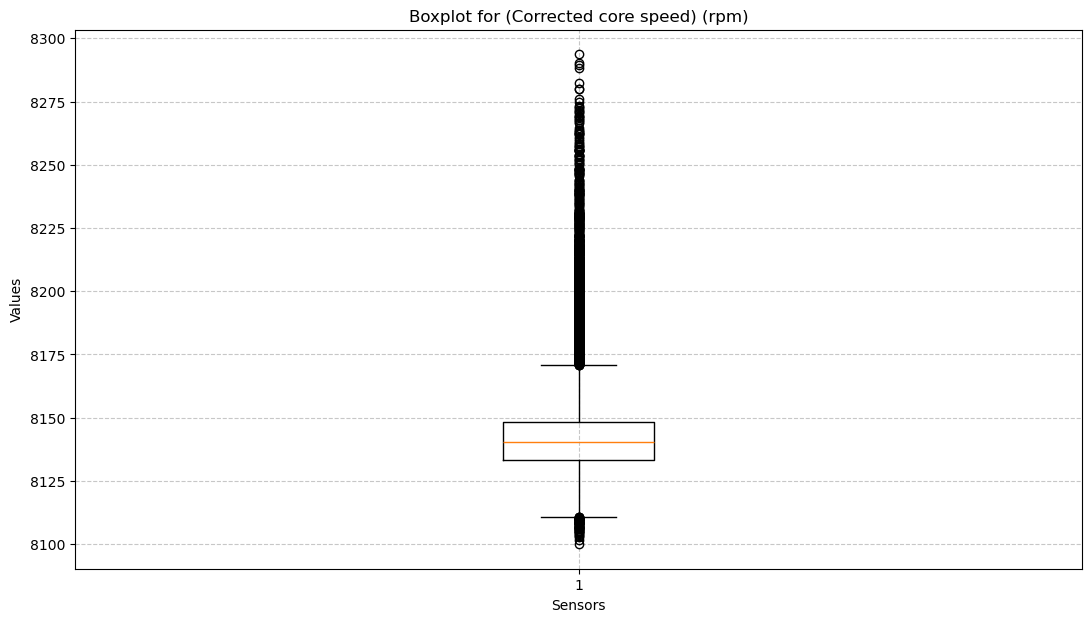

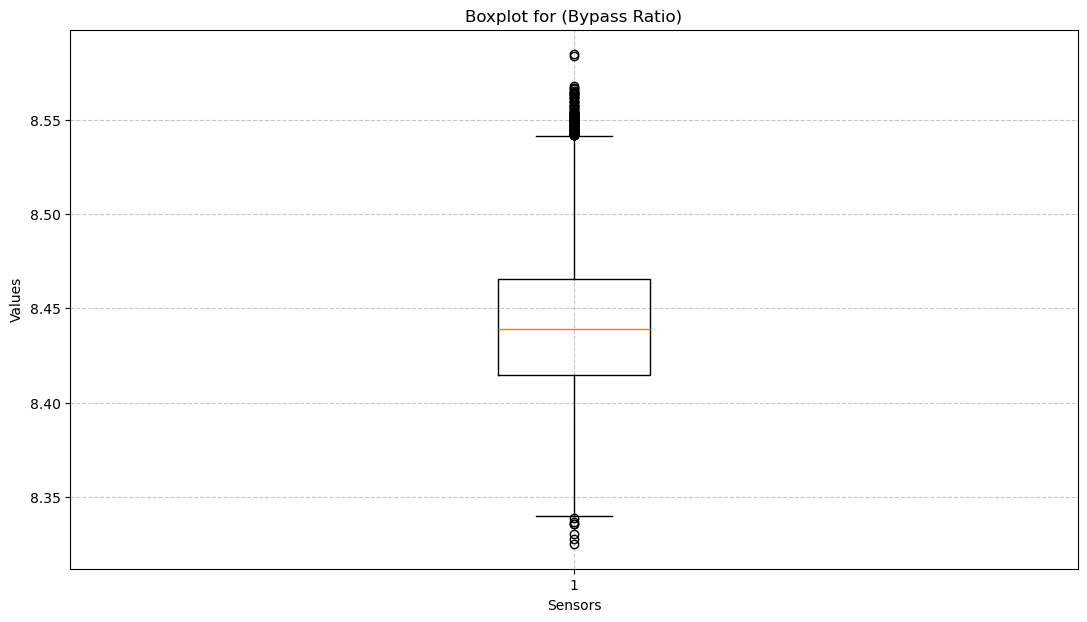

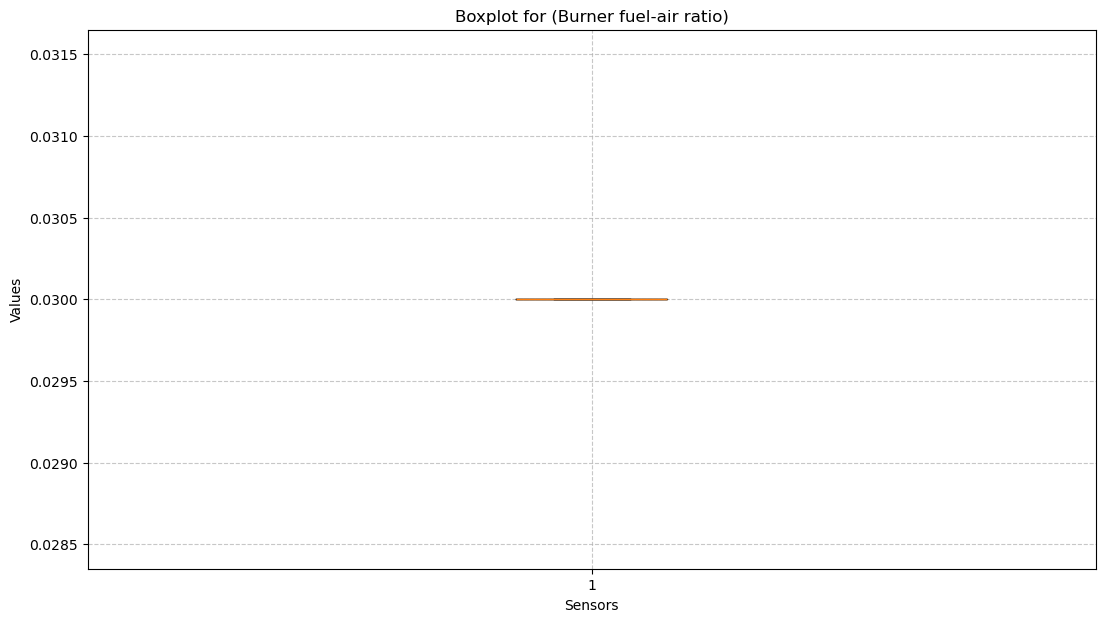

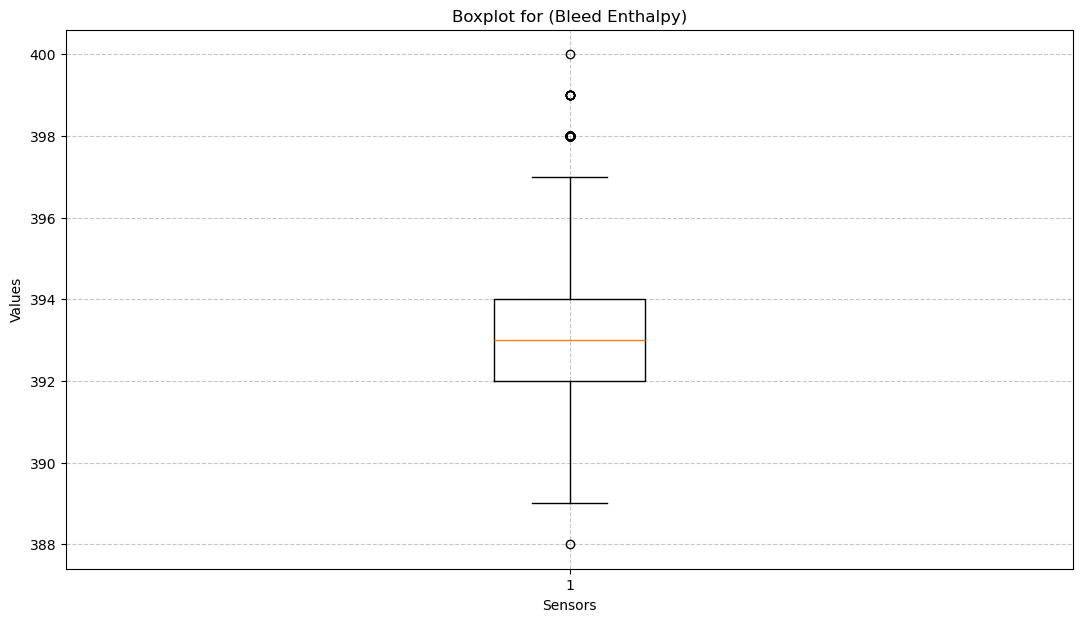

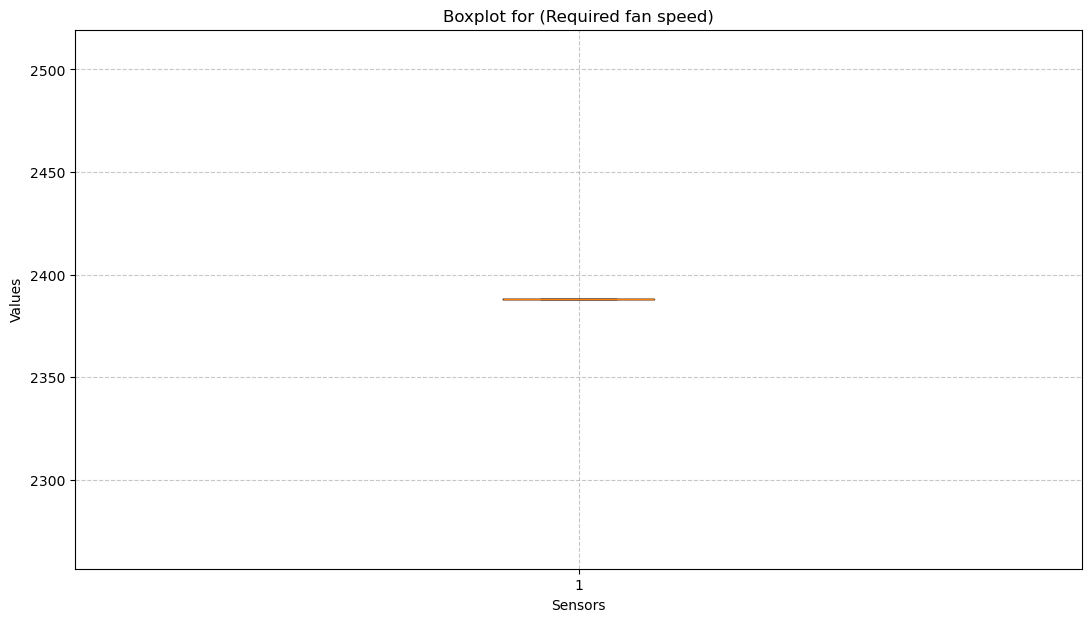

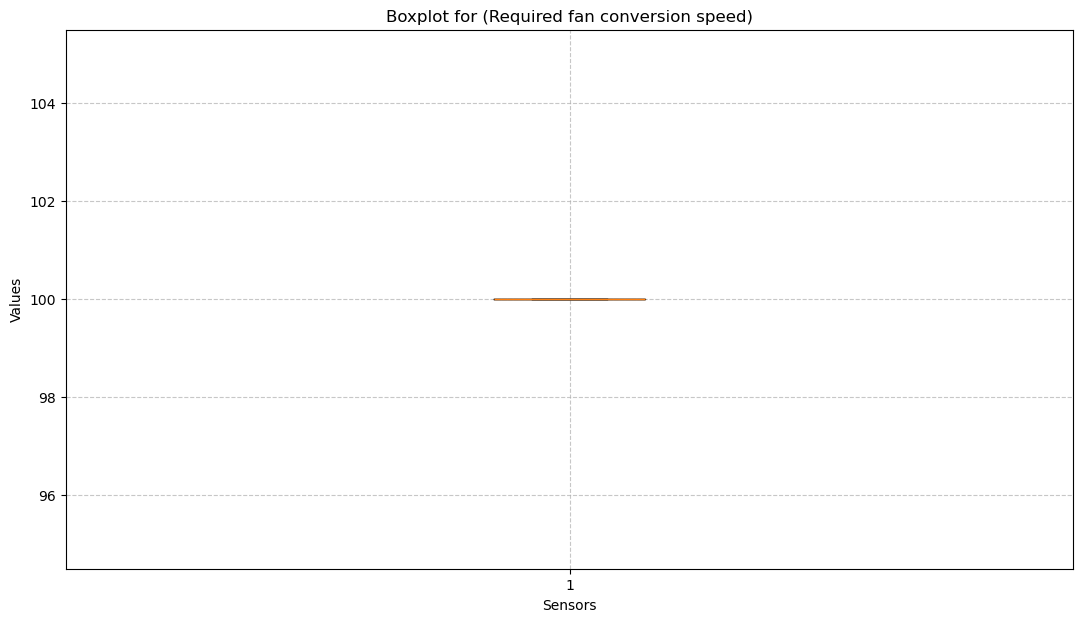

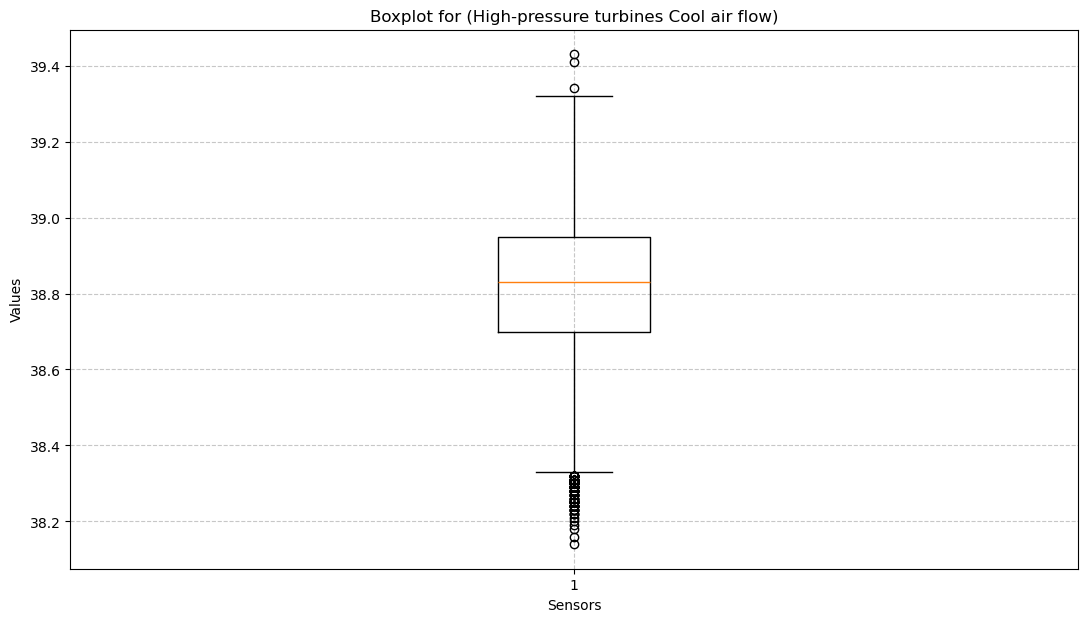

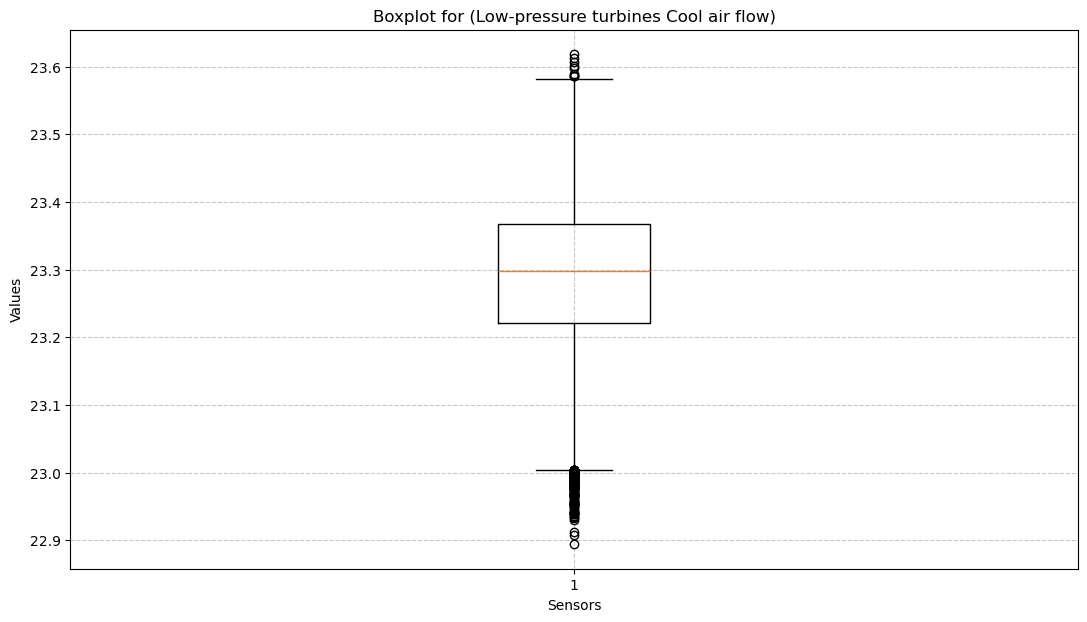

In [104]:
for x in sensor_names:
    plt.figure(figsize=(13,7))
    
    # Handle missing values by dropping NaNs for plotting if anything are there
    data = train[x].dropna()  
    
    # Plot the boxplot
    plt.boxplot(data)
    
    # Adding the title with sensor name
    plt.title(f"Boxplot for {Sensor_dictionary.get(x, x)}")  # Use Sensor dictionary for better labels
    plt.xlabel('Sensors')
    plt.ylabel('Values')
    
    # Customize the grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Display the plot
    plt.show()


In [106]:
# Generating summary statistics for all sensor columns (from 's_1' to the last sensor column) in the train dataset
# The .describe() function computes basic statistics like mean, std, min, max, and quartiles for each sensor
# The .transpose() is used to switch rows and columns for easier readability of the statistics
train.loc[:,'s_1':].describe().transpose()


count         mean           std        min        25%        50%  \
s_1   20631.0   518.670000  6.537152e-11   518.6700   518.6700   518.6700   
s_2   20631.0   642.680934  5.000533e-01   641.2100   642.3250   642.6400   
s_3   20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600  1590.1000   
s_4   20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600  1408.0400   
s_5   20631.0    14.620000  3.394700e-12    14.6200    14.6200    14.6200   
s_6   20631.0    21.609803  1.388985e-03    21.6000    21.6100    21.6100   
s_7   20631.0   553.367711  8.850923e-01   549.8500   552.8100   553.4400   
s_8   20631.0  2388.096652  7.098548e-02  2387.9000  2388.0500  2388.0900   
s_9   20631.0  9065.242941  2.208288e+01  9021.7300  9053.1000  9060.6600   
s_10  20631.0     1.300000  4.660829e-13     1.3000     1.3000     1.3000   
s_11  20631.0    47.541168  2.670874e-01    46.8500    47.3500    47.5100   
s_12  20631.0   521.413470  7.375534e-01   518.6900   520.9600   521.4800   
s_13  20631.0  2388.096152  7.191892e-02  2387.8800  2388.0400  2388.0900   
s_14  20631.0  8143.752722  1.907618e+01  8099.9400  8133.2450  8140.5400   
s_15  20631.0     8.442146  3.750504e-02     8.3249     8.4149     8.4389   
s_16  20631.0     0.030000  1.556432e-14     0.0300     0.0300     0.0300   
s_17  20631.0   393.210654  1.548763e+00   388.0000   392.0000   393.0000   
s_18  20631.0  2388.000000  0.000000e+00  2388.0000  2388.0000  2388.0000   
s_19  20631.0   100.000000  0.000000e+00   100.0000   100.0000   100.0000   
s_20  20631.0    38.816271  1.807464e-01    38.1400    38.7000    38.8300   
s_21  20631.0    23.289705  1.082509e-01    22.8942    23.2218    23.2979   
RUL   20631.0   107.807862  6.888099e+01     0.0000    51.0000   103.0000   

            75%        max  
s_1    518.6700   518.6700  
s_2    643.0000   644.5300  
s_3   1594.3800  1616.9100  
s_4   1414.5550  1441.4900  
s_5     14.6200    14.6200  
s_6     21.6100    21.6100  
s_7    554.0100   556.0600  
s_8   2388.1400  2388.5600  
s_9   9069.4200  9244.5900  
s_10     1.3000     1.3000  
s_11    47.7000    48.5300  
s_12   521.9500   523.3800  
s_13  2388.1400  2388.5600  
s_14  8148.3100  8293.7200  
s_15     8.4656     8.5848  
s_16     0.0300     0.0300  
s_17   394.0000   400.0000  
s_18  2388.0000  2388.0000  
s_19   100.0000   100.0000  
s_20    38.9500    39.4300  
s_21    23.3668    23.6184  
RUL    155.0000   361.0000

### Splitting the Data into Training and Test Sets

In this step, we split the dataset into training and test sets. We remove unnecessary columns (like engine unit number, time cycles, and settings) from the feature set `X_train`. We then separate the target variable `RUL` and assign it to `y_train`.

- **Features (X_train)**: The sensor readings, excluding engine information and the target variable.
- **Target (y_train)**: The Remaining Useful Life (RUL) of each engine unit.

The dataset is then split into a training set (70%) and a test set (30%) using the `train_test_split` function from `sklearn`. The random state is fixed to ensure reproducibility of the results.


In [112]:
from sklearn.model_selection import train_test_split

# Define columns to drop (index and settings)
drop_labels = index_names + setting_names

# Create feature set (X_train) by dropping the irrelevant columns
X_train = train.drop(columns=drop_labels + ['RUL']).copy()  # Drop 'RUL' as well from features

# Define target variable (y_train)
y_train = train['RUL']

# Split the data into training and test sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Optional: print the shapes of the resulting datasets for verification
print(f"Training set shape: X_train = {X_train.shape}, y_train = {y_train.shape}")
print(f"Test set shape: X_test = {X_test.shape}, y_test = {y_test.shape}")


Training set shape: X_train = (14441, 21), y_train = (14441,)
Test set shape: X_test = (6190, 21), y_test = (6190,)


### Feature Scaling for the Training, Test, and Validation Sets

In this step, we apply MinMax scaling to the features of the training, test, and validation datasets. MinMax scaling transforms the features so that they are within the range [0, 1], which is useful for many machine learning models to ensure that features with different ranges do not disproportionately affect the model.

- **Scaling the Training Set**: We fit the scaler on the training data and transform it.
- **Scaling the Test and Validation Sets**: We use the same scaler fitted on the training data to transform the test and validation sets, ensuring consistency.

The last occurrence of each engine unit is selected from the validation dataset to match the length of `y_valid`.


In [124]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler only on the training data and transform it
X_train_s = scaler.fit_transform(X_train)

# Transform the test data using the same scaler (to avoid data leakage)
X_test_s = scaler.transform(X_test)

#Conserve only the last occurence of each unit to match the length of y_valid
X_valid = valid.groupby('unit_number').last().reset_index().drop(columns=drop_labels)
#scaling X_valid
X_valid_s=scaler.fit_transform(X_valid)

# Print the shapes of the scaled datasets for verification
print(f"Scaled training set shape: {X_train_s.shape}")
print(f"Scaled test set shape: {X_test_s.shape}")
print(f"Scaled validation set shape: {X_valid_s.shape}")


Scaled training set shape: (14441, 21)
Scaled test set shape: (6190, 21)
Scaled validation set shape: (100, 21)


In [126]:
X_valid


s_1     s_2      s_3      s_4    s_5    s_6     s_7      s_8      s_9  \
0   518.67  642.58  1581.22  1398.91  14.62  21.61  554.42  2388.08  9056.40   
1   518.67  642.55  1586.59  1410.83  14.62  21.61  553.52  2388.10  9044.77   
2   518.67  642.88  1589.75  1418.89  14.62  21.61  552.59  2388.16  9049.26   
3   518.67  642.78  1594.53  1406.88  14.62  21.61  552.64  2388.13  9051.30   
4   518.67  642.27  1589.94  1419.36  14.62  21.61  553.29  2388.10  9053.99   
..     ...     ...      ...      ...    ...    ...     ...      ...      ...   
95  518.67  642.30  1590.88  1397.94  14.62  21.61  553.99  2388.03  9062.41   
96  518.67  642.59  1582.96  1410.92  14.62  21.61  554.05  2388.06  9076.36   
97  518.67  642.68  1599.51  1415.47  14.62  21.61  553.44  2388.13  9062.34   
98  518.67  642.00  1585.03  1397.98  14.62  21.61  554.75  2388.01  9067.16   
99  518.67  642.95  1601.62  1424.99  14.62  21.61  552.48  2388.06  9155.03   

    s_10  ...    s_12     s_13     s_14    s_15  s_16  s_17  s_18   s_19  \
0    1.3  ...  521.79  2388.06  8130.11  8.4024  0.03   393  2388  100.0   
1    1.3  ...  521.74  2388.09  8126.90  8.4505  0.03   391  2388  100.0   
2    1.3  ...  520.83  2388.14  8131.46  8.4119  0.03   395  2388  100.0   
3    1.3  ...  521.88  2388.11  8133.64  8.4634  0.03   395  2388  100.0   
4    1.3  ...  521.00  2388.15  8125.74  8.4362  0.03   394  2388  100.0   
..   ...  ...     ...      ...      ...     ...   ...   ...   ...    ...   
95   1.3  ...  522.30  2388.01  8148.24  8.4110  0.03   391  2388  100.0   
96   1.3  ...  521.58  2388.06  8155.48  8.4500  0.03   395  2388  100.0   
97   1.3  ...  521.53  2388.09  8146.39  8.4235  0.03   394  2388  100.0   
98   1.3  ...  521.82  2388.02  8150.38  8.4003  0.03   391  2388  100.0   
99   1.3  ...  521.07  2388.05  8214.64  8.4903  0.03   396  2388  100.0   

     s_20     s_21  
0   38.81  23.3552  
1   38.81  23.2618  
2   38.93  23.2740  
3   38.58  23.2581  
4   38.75  23.4117  
..    ...      ...  
95  38.96  23.4606  
96  38.61  23.2953  
97  38.76  23.3608  
98  38.95  23.3595  
99  38.70  23.1855  

[100 rows x 21 columns]

array([[<Axes: title={'center': 's_2'}>, <Axes: title={'center': 's_3'}>,
        <Axes: title={'center': 's_4'}>, <Axes: title={'center': 's_7'}>],
       [<Axes: title={'center': 's_8'}>, <Axes: title={'center': 's_9'}>,
        <Axes: title={'center': 's_11'}>,
        <Axes: title={'center': 's_12'}>],
       [<Axes: title={'center': 's_13'}>,
        <Axes: title={'center': 's_14'}>,
        <Axes: title={'center': 's_15'}>,
        <Axes: title={'center': 's_17'}>],
       [<Axes: title={'center': 's_20'}>,
        <Axes: title={'center': 's_21'}>, <Axes: >, <Axes: >]],
      dtype=object)

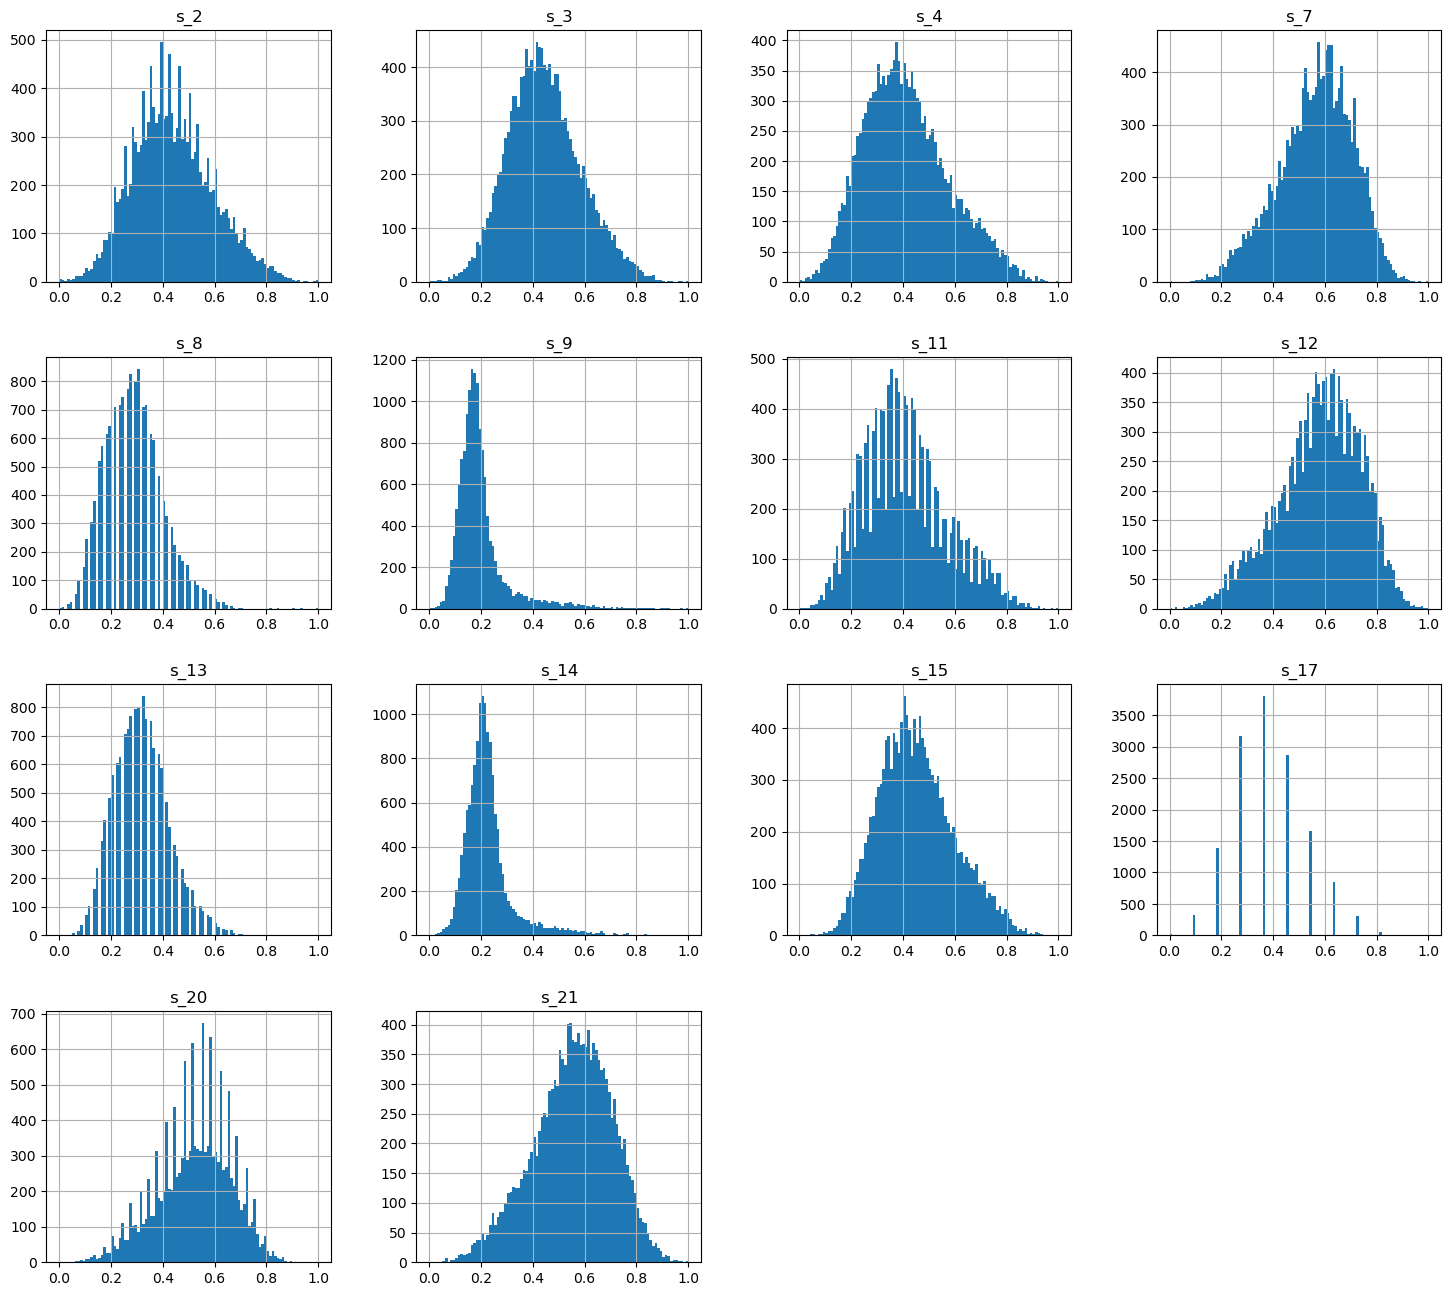

In [128]:
# List of sensor names, excluding certain sensors (1, 5, 6, 10, 16, 18, 19)
# These sensors are not included in the analysis for the histograms
sensor_names = ['s_{}'.format(i) for i in range(1, 22) if i not in [1, 5, 6, 10, 16, 18, 19]]

# Create a DataFrame using the scaled training data (X_train_s), 
# and assign column names as 's_1', 's_2', ..., 's_21'
df = pd.DataFrame(X_train_s, columns=['s_{}'.format(i) for i in range(1, 22)])

# Select only the columns listed in 'sensor_names' and plot histograms for those sensors
# The histograms will show the distribution of sensor values after MinMax scaling
df[sensor_names].hist(bins=100, figsize=(18, 16))  # bins=100 specifies 100 bins for the histogram


# Model Implementation: Linear Regression


In [149]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# R2 score, RMSE evaluation function
def evaluate(y_true, y_hat, label='test'):
    # Calculate Mean Squared Error
    mse = mean_squared_error(y_true, y_hat)
    
    # Calculate Root Mean Squared Error
    rmse = np.sqrt(mse)
    
    # Calculate R-squared score
    r2 = r2_score(y_true, y_hat)
    
    # Printing the evaluation metrics
    print('{} set - RMSE: {:.4f}, R2: {:.4f}'.format(label, rmse, r2))



In [151]:
# Importing Linear Regression from sklearn
from sklearn.linear_model import LinearRegression

# Instantiate the Linear Regression model
lr = LinearRegression()

In [153]:
lr.fit(X_train_s, y_train) #Fitting 

y_lr_train = lr.predict(X_train_s) #Prediction on train data
evaluate(y_train,y_lr_train, label='train')

y_lr_test = lr.predict(X_test_s)  #Prediction on test data
evaluate(y_test, y_lr_test, label='test')

y_lr_valid= lr.predict(X_valid_s) #Prediction on validation data
evaluate(y_valid, y_lr_valid, label='valid')

train set - RMSE: 44.7994, R2: 0.5831
test set - RMSE: 44.3865, R2: 0.5699
valid set - RMSE: 43.0042, R2: -0.0709


# SVR


In [159]:
# Importing the SVR (Support Vector Regression) model from scikit-learn's svm module
from sklearn.svm import SVR

# Instantiating the SVR model with the Radial Basis Function (RBF) kernel
regressor = SVR(kernel='rbf')


In [161]:
regressor.fit(X_train_s, y_train) # fitting

y_svr_train = regressor.predict(X_train_s) #Prediction on train data
evaluate(y_train,y_svr_train, label='train')

y_svr_test = regressor.predict(X_test_s) #Prediction on test data
evaluate(y_test, y_svr_test, label='test')

y_svr_valid= lr.predict(X_valid_s)  #Prediction on validation data
evaluate(y_valid, y_svr_valid, label='valid')

train set - RMSE: 43.5645, R2: 0.6058
test set - RMSE: 43.2533, R2: 0.5916
valid set - RMSE: 43.0042, R2: -0.0709


# Random forest

In [164]:
# Importing the RandomForestRegressor class from scikit-learn
from sklearn.ensemble import RandomForestRegressor

# Instantiating the RandomForestRegressor model
# max_features="sqrt" specifies that the number of features to consider when looking for the best split 
# will be the square root of the total number of features in the dataset.
# random_state=42 ensures reproducibility 
rf = RandomForestRegressor(max_features="sqrt", random_state=42)


In [168]:
# Fit the Random Forest Regressor model to the training data
rf.fit(X_train_s, y_train)

# Predict and evaluate on the training data
y_rf_train = rf.predict(X_train_s)  # Predict on training data
evaluate(y_train, y_rf_train, label='train')  # Evaluate training performance

# Predict and evaluate on the test data
y_rf_test = rf.predict(X_test_s)  # Predict on test data
evaluate(y_test, y_rf_test, label='test')  # Evaluate test performance

# Predict and evaluate on the validation data
y_rf_valid = rf.predict(X_valid_s)  # Predict on validation data
evaluate(y_valid, y_rf_valid, label='valid')  # Evaluate validation performance


train set - RMSE: 15.4083, R2: 0.9507
test set - RMSE: 41.2944, R2: 0.6277
valid set - RMSE: 30.6536, R2: 0.4559


In [170]:
# Function to plot real vs predicted RUL values for comparison
def plot_predActual(y_test, y_test_hat):
  
    indices = np.arange(len(y_test_hat))  # Generate indices for the x-axis
    wth = 0.6  # Set width for the bars
    plt.figure(figsize=(70, 30))  # Set figure size
    
    # Convert true RUL values to integers and create a list of predicted values
    true_values = [int(x) for x in y_test.values]  
    predicted_values = list(y_test_hat)  

    # Plotting the true RUL values as blue bars
    plt.bar(indices, true_values, width=wth, color='b', label='True RUL')  

    # Plotting the predicted RUL values as red bars (with some transparency)
    plt.bar([i for i in indices], predicted_values, width=0.5 * wth, color='r', alpha=0.7, label='Predicted RUL')  

    # Adding a legend and setting font size
    plt.legend(prop={'size': 40})  

    # Set tick parameters (font size)
    plt.tick_params(labelsize=40)  

    # Display the plot
    plt.show()


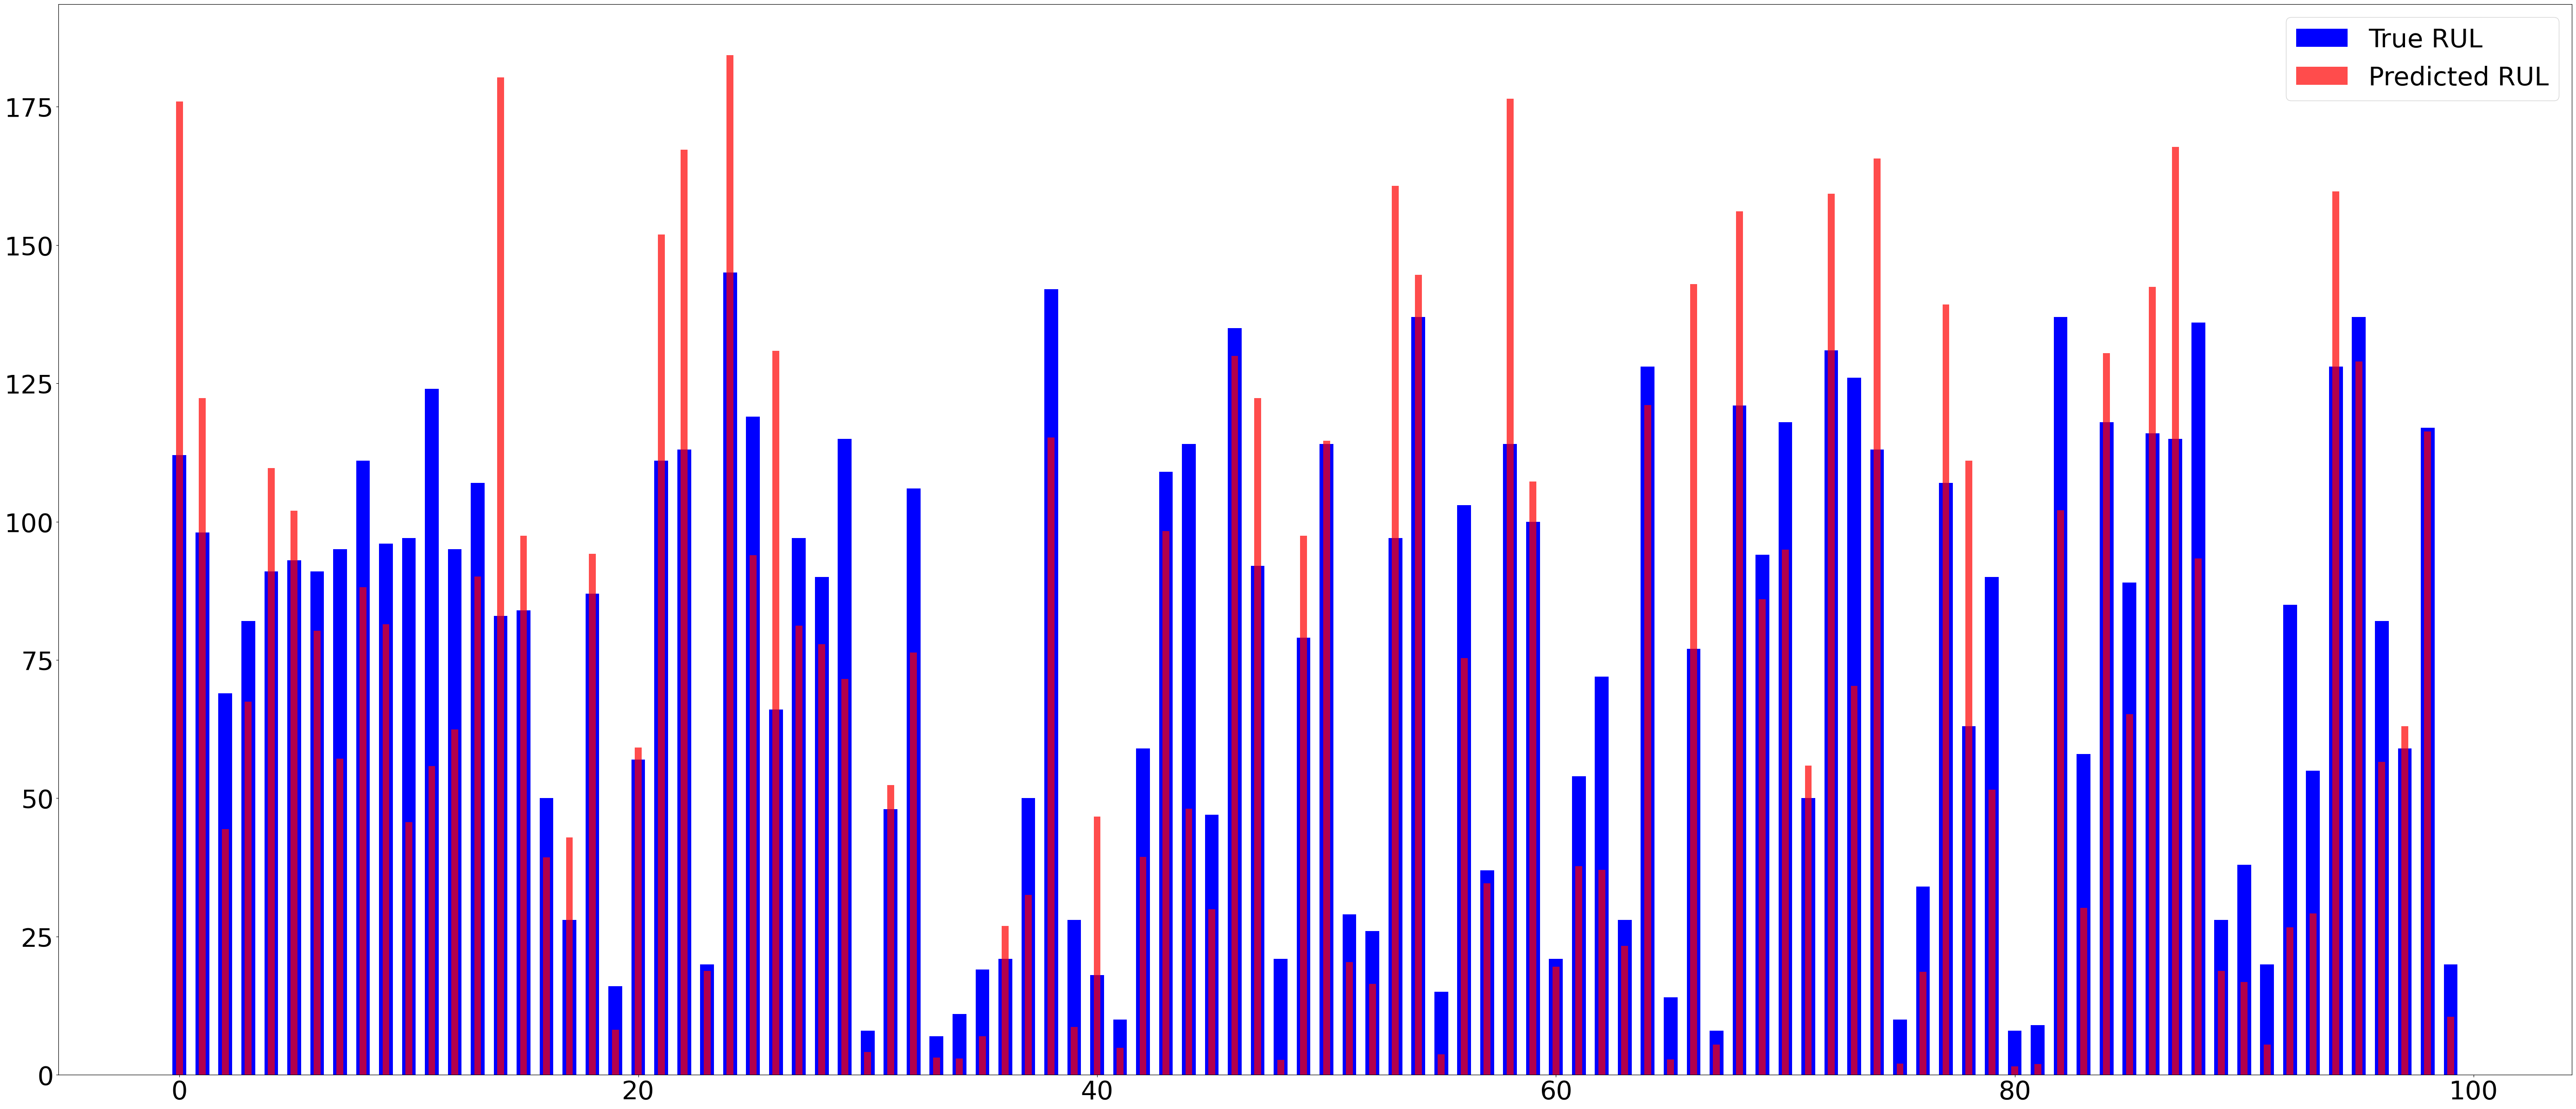

In [172]:
# Call the plot_predActual function to visualize the comparison between true and predicted RUL values on the validation set for the Random Forest Regressor (rf) model
# It works well with complex datasets, handles non-linearity, and is less prone to overfitting than individual decision trees.
plot_predActual(y_valid, y_rf_valid)


We notice that the model overestimates the RUL

### Second Attempt: Data without Useless Sensors and Historical Data

#### RUL Clipping:
We observed that the maximum RUL value lies within the range [190, 210]. To improve predictions and reduce model overestimation, we will clip RUL values above 195 to 195.

#### Why Clip to 195:
- RUL values above 195 are already considered high and do not significantly affect the prediction.
- Clipping helps reduce overhead and outliers, simplifying the model while maintaining prediction accuracy.

In [178]:
# Printing the maximum values of the target variable (RUL) for training, testing, and validation sets
print('Maximum of y_train : ', y_train.max())  # Maximum RUL value in the training set
print('Maximum of y_test : ', y_test.max())    # Maximum RUL value in the test set
print('Maximum of y_valid : ', y_valid.max())  # Maximum RUL value in the validation set


Maximum of y_train :  361
Maximum of y_test :  360
Maximum of y_valid :  RUL    145
dtype: int64


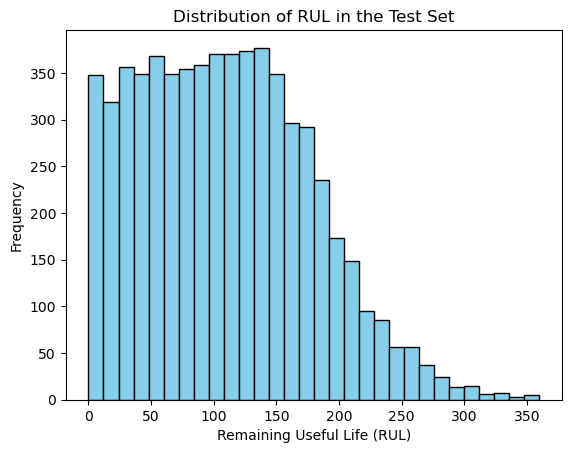

In [182]:
# Plotting the histogram of RUL values in the test set
plt.hist(y_test, bins=30, color='skyblue', edgecolor='black')  # Histogram with 30 bins, skyblue color for bars
plt.title('Distribution of RUL in the Test Set')  # Title for the plot
plt.xlabel('Remaining Useful Life (RUL)')  # Label for the x-axis
plt.ylabel('Frequency')  # Label for the y-axis
plt.show()  # Display the plot


In [184]:
# Define columns to drop: constant sensors that don't provide useful information
drop_labels2 = ['s_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']

# Dropping the constant columns from the train dataset
X_train_2 = X_train.drop(columns=drop_labels2, axis=1)  # Removing non-informative sensors

# Dropping the constant columns from the test dataset
X_test_2 = X_test.drop(columns=drop_labels2, axis=1)  # Removing non-informative sensors from the test data

# Scaling the feature data (train set)
X_train_2_s = scaler.fit_transform(X_train_2)  # Scaling train data to normalize the values

# Scaling the feature data (test set)
X_test_2_s = scaler.fit_transform(X_test_2)  # Scaling test data to normalize the values

# Clipping the RUL values in the train dataset to set a maximum of 195
y_train_clip = y_train.clip(upper=195)  # Set all RUL values greater than 195 to 195 to reduce extreme values

# Dropping the constant columns from the validation dataset
X_valid_2 = X_valid.drop(columns=drop_labels2, axis=1)  # Removing non-informative sensors from validation data

# Scaling the validation data
X_valid_2_s = scaler.fit_transform(X_valid_2)  # Scaling validation data to match the feature scaling of train and test data


# Linear Regression

In [188]:
# Initialize the Linear Regression model
lr = Linear_Regression()

# Fit the Linear Regression model with the training data and clipped RUL values (y_train_clip)
lr.fit(X=X_train_2_s, Y=y_train_clip)

# Predict RUL on the training dataset
y_lr_train = lr.predict(X_train_2_s)
# Evaluate the model's performance on the training dataset
evaluate(y_train_clip, y_lr_train, label='train')

# Predict RUL on the test dataset
y_lr_test = lr.predict(X_test_2_s)
# Evaluate the model's performance on the test dataset
evaluate(y_test, y_lr_test, label='test')

# Predict RUL on the validation dataset
y_lr_valid = lr.predict(X_valid_2_s)
# Evaluate the model's performance on the validation dataset
evaluate(y_valid, y_lr_valid, label='valid')


train set - RMSE: 47.8631, R2: 0.3793
test set - RMSE: 55.6261, R2: 0.3245
valid set - RMSE: 34.2107, R2: 0.3223


# SVR

In [191]:
# Fit the Support Vector Regressor (SVR) model on the scaled training data and clipped RUL values (y_train)
regressor.fit(X_train_2_s, y_train_clip)

# Predict RUL on the training dataset 
y_svr_train = regressor.predict(X_train_2_s)
# Evaluate the model's performance on the training dataset 
evaluate(y_train_clip, y_svr_train, label='train')

# Predict RUL on the test dataset 
y_svr_test = regressor.predict(X_test_2_s)
# Evaluate the model's performance on the test dataset 
evaluate(y_test, y_svr_test, label='test')

# Predict RUL on the validation dataset 
y_svr_valid = regressor.predict(X_valid_2_s)
# Evaluate the model's performance on the validation dataset 
evaluate(y_valid, y_svr_valid, label='valid')


train set - RMSE: 32.9154, R2: 0.7064
test set - RMSE: 48.7551, R2: 0.4810
valid set - RMSE: 25.9479, R2: 0.6101


# Random forest

In [195]:
# Fit the Random Forest Regressor model on the scaled training data with clipped RUL values
rf.fit(X_train_2_s, y_train_clip)

# Predict RUL on the training dataset and evaluate the performance
y_rf_train = rf.predict(X_train_2_s)
evaluate(y_train_clip, y_rf_train, label='train')

# Predict RUL on the test dataset and evaluate the performance
y_rf_test = rf.predict(X_test_2_s)
evaluate(y_test, y_rf_test, label='test')

# Predict RUL on the validation dataset and evaluate the performance
y_rf_valid = rf.predict(X_valid_2_s)
evaluate(y_valid, y_rf_valid, label='valid')


train set - RMSE: 12.0369, R2: 0.9607
test set - RMSE: 45.8184, R2: 0.5417
valid set - RMSE: 26.5484, R2: 0.5919


In [205]:
!pip install xgboost

import xgboost


   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/124.9 MB 871.5 kB/s eta 0:02:24
   ---------------------------------------- 0.5/124.9 MB 3.5 MB/s eta 0:00:36
   ---------------------------------------- 1.0/124.9 MB 5.5 MB/s eta 0:00:23
    --------------------------------------- 1.6/124.9 MB 6.6 MB/s eta 0:00:19
    --------------------------------------- 2.1/124.9 MB 7.4 MB/s eta 0:00:17
    --------------------------------------- 2.6/124.9 MB 8.0 MB/s eta 0:00:16
   - -------------------------------------- 3.2/124.9 MB 8.4 MB/s eta 0:00:15
   - -------------------------------------- 3.7/124.9 MB 8.4 MB/s eta 0:00:15
   - -------------------------------------- 4.1/124.9 MB 8.6 MB/s eta 0:00:15
   - -------------------------------------- 4.1/124.9 MB 8.6 MB/s eta 0:00:15
   - 

In [207]:
# Initialize the XGBoost Regressor model with specific hyperparameters
xgb = xgboost.XGBRegressor(n_estimators=110, learning_rate=0.02, gamma=0, subsample=0.8, colsample_bytree=0.5, max_depth=3)

# Fit the XGBoost model on the scaled training data with clipped RUL values
xgb.fit(X_train_2_s, y_train_clip)

# Predict RUL on the training dataset and evaluate the performance
y_xgb_train = xgb.predict(X_train_2_s)
evaluate(y_train_clip, y_xgb_train, label='train')

# Predict RUL on the test dataset and evaluate the performance
y_xgb_test = xgb.predict(X_test_2_s)
evaluate(y_test, y_xgb_test, label='test')

# Predict RUL on the validation dataset and evaluate the performance
y_xgb_valid = xgb.predict(X_valid_2_s)
evaluate(y_valid, y_xgb_valid, label='valid')


train set - RMSE: 33.9643, R2: 0.6874
test set - RMSE: 45.6137, R2: 0.5458
valid set - RMSE: 23.4162, R2: 0.6825


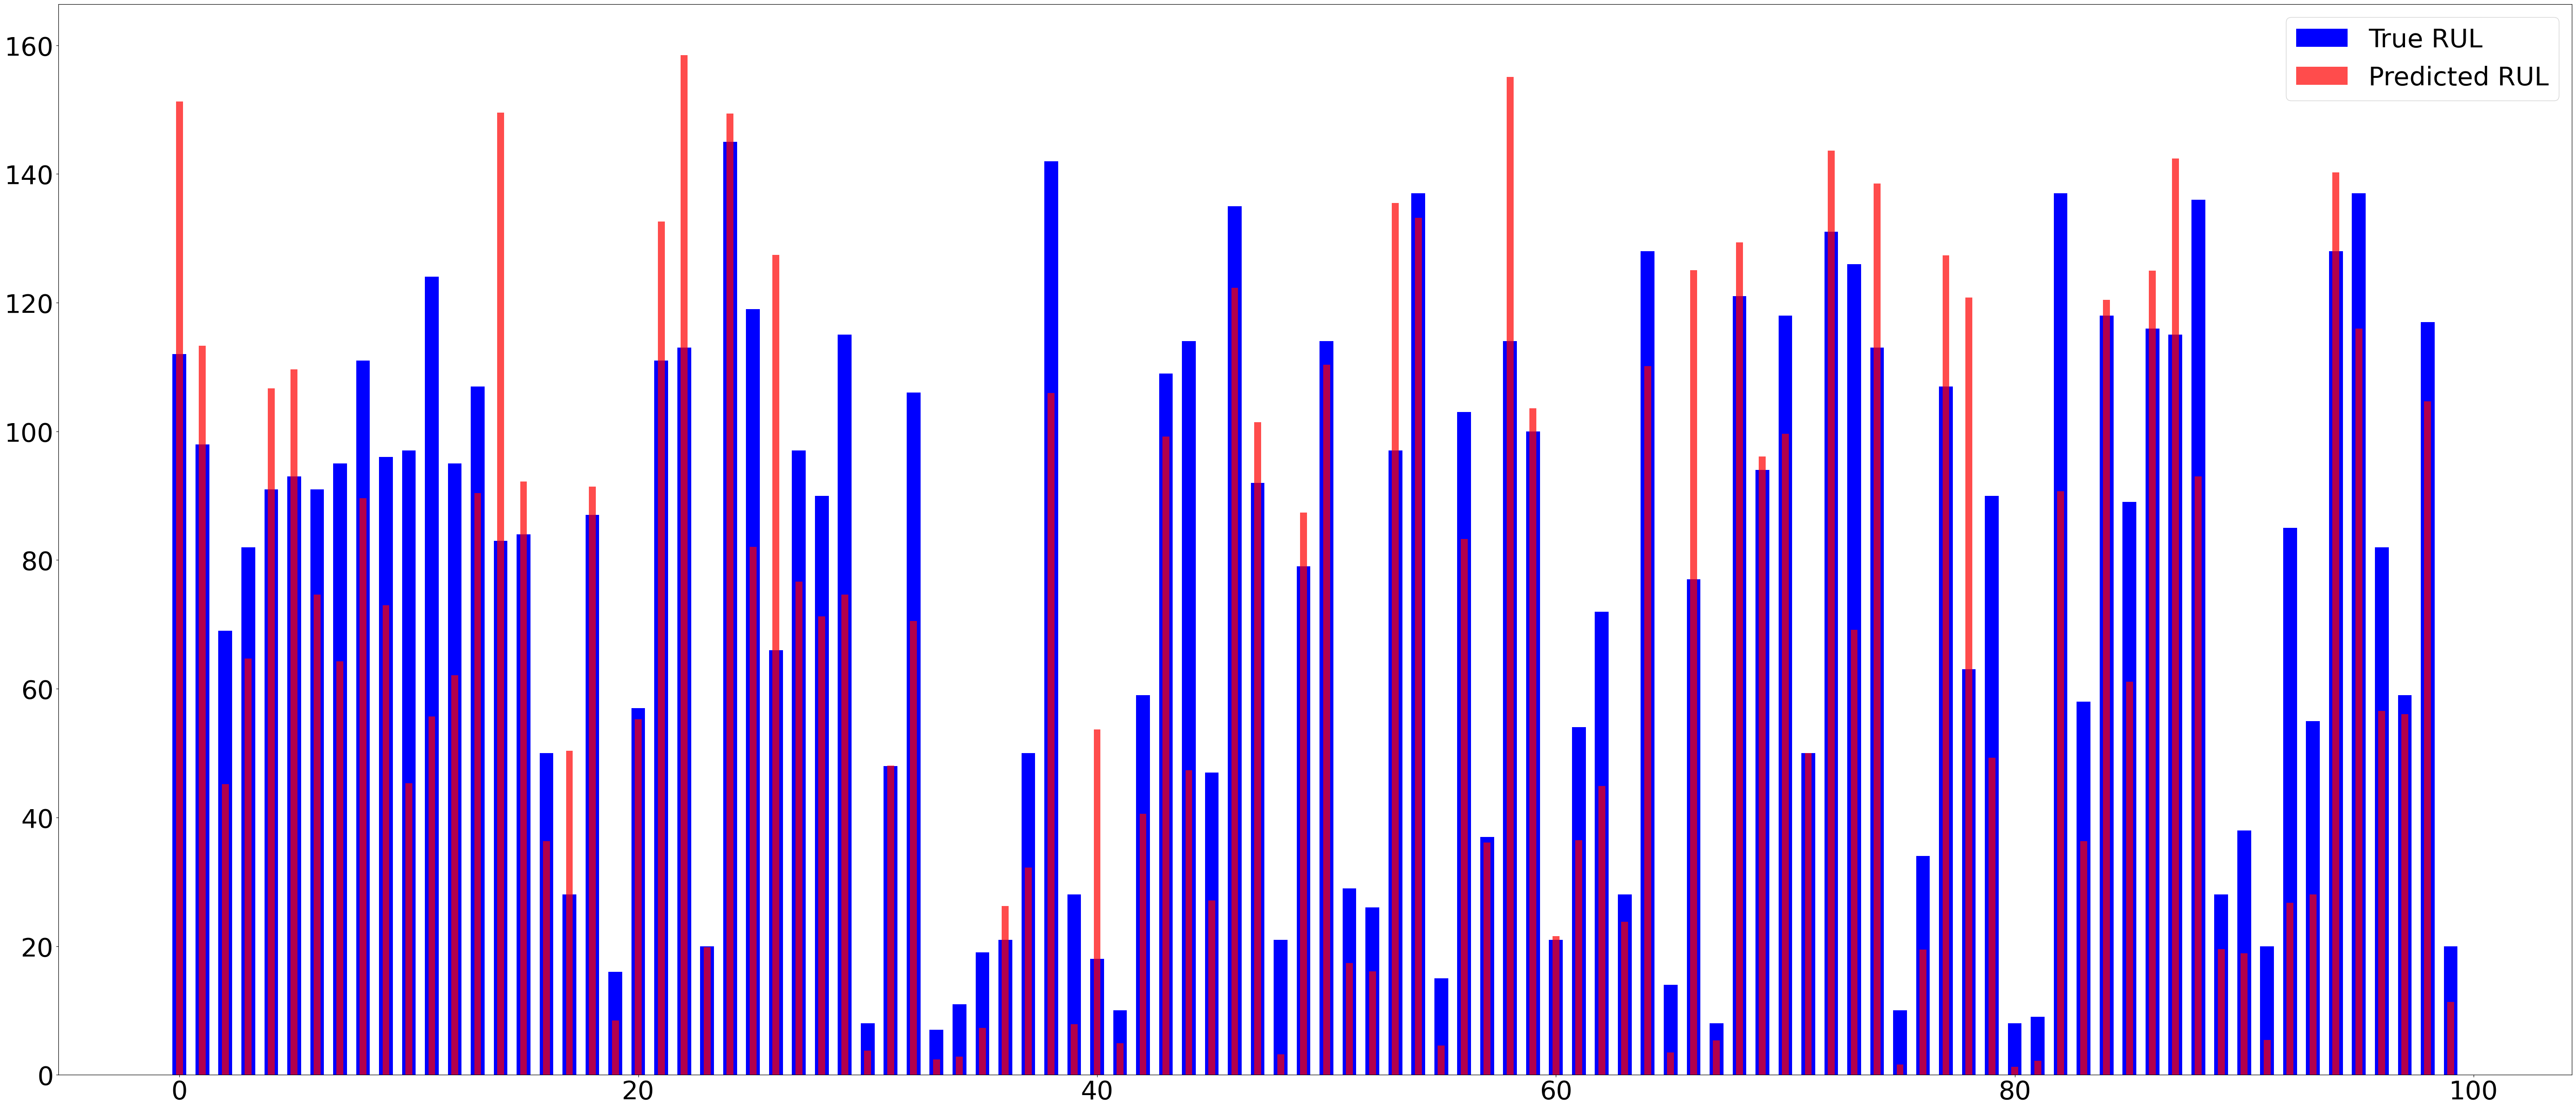

In [209]:
# Plotting the actual vs predicted RUL values for the Random Forest model

plot_predActual(y_valid, y_rf_valid)
# This visual helps in understanding how well the model is predicting the RUL and where it might be overestimating or underestimating.



### Third Attempt: Data Without Useless Sensors and With Historical Data

In this section, we aim to explore time-series patterns in our features by introducing a new feature called the **'rolling mean feature'**. This feature will capture the average value of each feature over a rolling window of 10 time cycles. The rationale behind this approach is to help uncover trends or temporal dependencies within the data, which could significantly improve model predictions.

#### Reasons for Moving to the Third Attempt:

1. **Improved Feature Engineering**:
   - **Historical Data Inclusion**: By considering previous time cycles, we capture temporal dependencies and patterns that are crucial for time series prediction, especially for tasks like RUL prediction.
   - **Rolling Mean Feature**: This new feature aggregates the last 10 time cycles of each feature, smoothing the data and helping to reduce noise while highlighting the underlying trends.

2. **Focus on Relevant Features**:
   - **Dropping Useless Sensors**: In the earlier attempts, we used all available sensors, including constant and irrelevant ones. Removing these sensors ensures the model focuses on only the most informative variables, leading to better performance.

3. **Time Series Characteristics**:
   - **Temporal Dynamics**: Engine performance depends on previous cycles, and adding a historical context (via the rolling mean) will likely improve the model's ability to understand these dynamics and predict RUL more accurately.


In [214]:
# Create a copy of the original train data
df = train.copy()

# Add new columns for rolling mean features
for x in X_train_2.columns:
    df[x + '_rm'] = 0  # Initialize rolling mean columns with 0

# Verify that new columns are added
df.columns


Index(['unit_number', 'time_cycles', 'setting_1', 'setting_2', 'setting_3',
       's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19',
       's_20', 's_21', 'RUL', 's_2_rm', 's_3_rm', 's_4_rm', 's_7_rm', 's_8_rm',
       's_9_rm', 's_11_rm', 's_12_rm', 's_13_rm', 's_14_rm', 's_15_rm',
       's_17_rm', 's_20_rm', 's_21_rm'],
      dtype='object')

In [220]:
# Drop unnecessary columns (constant features, setting names, and target variable 'RUL') from training data
df = df.drop(columns=setting_names + drop_labels2 + ['RUL'], axis=1)

# Create validation data (X_valid_3) by dropping irrelevant columns from the validation set
X_valid_3 = valid.drop(columns=index_names + setting_names + drop_labels2, axis=1)


In [222]:
# Define a function to compute rolling mean for each unit and feature
def update_rolling_mean(data, mask):
    for x, group in mask.groupby("unit_number"):  # Group by unit_number
        for x in X_train_2.columns:  # Iterate through each feature
            # Apply rolling mean (over the last 10 cycles) to the feature
            data.loc[group.index[10:], x + "_rm"] = data.loc[group.index, x].rolling(10).mean()[10:]
            # For first 10 rows, assign original values
            data.loc[group.index[:10], x + "_rm"] = data.loc[group.index[:10], x]

# Apply rolling mean function to train and validation datasets
update_rolling_mean(df, df)  # For training data
update_rolling_mean(X_valid_3, valid)  # For validation data

# Fill missing values in X_valid_3 with 0
X_valid_3 = X_valid_3.fillna(0)
df.iloc[-1,-14:]=df.iloc[-2,-14:]
X_valid_3.iloc[-1,-14:]=X_valid_3.iloc[-2,-14:]

Saving the modified data-set.



In [225]:
# Assign the DataFrame 'df' to 'train_tm' for further manipulation
train_tm=df

In [227]:
# Drop the 'index_names' columns from the DataFrame as they are not needed for training
train_tm=train_tm.drop(columns=index_names, axis=1)


In [229]:
# Split the data into training and testing sets (70% train, 30% test) and clip the 'RUL' to 195 for training and test sets
X_train_tm, X_test_tm, y_train_tm, y_test_tm = train_test_split(train_tm, train['RUL'].clip(upper=195), test_size=0.35, random_state=42)

# Apply Min-Max scaling to the training and test feature sets
X_train_tm_s = scaler.fit_transform(X_train_tm)
X_test_tm_s = scaler.fit_transform(X_test_tm)

# Concatenate 'unit_number' with the validation set features, then group by 'unit_number' and take the last entry for each unit
X_val3 = pd.concat([valid['unit_number'], X_valid_3], axis=1)
X_valid3 = X_val3.groupby('unit_number').last().reset_index().drop(columns=['unit_number'])

# Scale the validation set using the same scaler as the training and test data
X_valid_s = scaler.fit_transform(X_valid3)


# Linear regression

In [234]:
# Initialize the Linear Regression model
lr = Linear_Regression()

# Train the model using the scaled training data (X_train_tm_s) and clipped RUL (y_train_tm)
lr.fit(X_train_tm_s, y_train_tm)

# Make predictions on the training data and evaluate the performance
y_lr_train = lr.predict(X_train_tm_s)
evaluate(y_train_tm, y_lr_train, label='train')

# Make predictions on the test data and evaluate the performance
y_lr_test = lr.predict(X_test_tm_s)
evaluate(y_test_tm, y_lr_test, label='test')

# Make predictions on the validation data and evaluate the performance
y_lr_valid = lr.predict(X_valid_s)
evaluate(y_valid, y_lr_valid, label='valid')


train set - RMSE: 40.5291, R2: 0.5545
test set - RMSE: 40.0989, R2: 0.5545
valid set - RMSE: 38.3914, R2: 0.1465



# SVR

In [242]:
# Fit the SVR model using the scaled training data (X_train_tm_s) and clipped RUL (y_train_tm)
regressor.fit(X_train_tm_s, y_train_tm)

# Make predictions on the training data and evaluate the performance
y_svr_train = regressor.predict(X_train_tm_s)
evaluate(y_train_tm, y_svr_train, label='train')

# Make predictions on the test data and evaluate the performance
y_svr_test = regressor.predict(X_test_tm_s)
evaluate(y_test_tm, y_svr_test, label='test')

# Make predictions on the validation data and evaluate the performance
y_svr_valid = regressor.predict(X_valid_s)
evaluate(y_valid, y_svr_valid, label='valid')


train set - RMSE: 32.4845, R2: 0.7138
test set - RMSE: 33.8287, R2: 0.6830
valid set - RMSE: 26.5903, R2: 0.5906


In the third attempt, the model was successfully generalized by incorporating the "rolling mean" feature and avoiding overfitting. By using the rolling mean, we captured time-series patterns and reduced the impact of noisy or irrelevant data, leading to improved prediction accuracy while ensuring the model's robustness on unseen data.

# Random Forest

In [253]:
# Initialize the Random Forest Regressor model with the specified parameters
rf = RandomForestRegressor(max_features="sqrt", random_state=42)

# Fit the Random Forest model using the scaled training data (X_train_tm_s) and clipped RUL (y_train_tm)
rf.fit(X_train_tm_s, y_train_tm)

# Make predictions on the training data and evaluate the performance
y_hat_train = rf.predict(X_train_tm_s)
evaluate(y_train_tm, y_hat_train, label='train')

# Make predictions on the test data and evaluate the performance
y_hat_test = rf.predict(X_test_tm_s)
evaluate(y_test_tm, y_hat_test, label='test')

# Make predictions on the validation data and evaluate the performance
y_hat_valid = rf.predict(X_valid_s)
evaluate(y_valid, y_hat_valid, label='valid')


train set - RMSE: 9.7873, R2: 0.9740
test set - RMSE: 29.9583, R2: 0.7514
valid set - RMSE: 37.1925, R2: 0.1990


The Random Forest model is overfitting to the data, as evidenced by significantly better performance on the training set compared to the test set. This suggests that the model is memorizing the training data, failing to generalize well to unseen data, and likely capturing noise or irrelevant patterns.

# Performing Grid Search

In [256]:
from sklearn.model_selection import GridSearchCV  # Import GridSearchCV for hyperparameter tuning
from sklearn.model_selection import ShuffleSplit   # ShuffleSplit for cross-validation
from sklearn.ensemble import RandomForestRegressor  # Import RandomForestRegressor for model building

estimator = RandomForestRegressor()  # Initialize the RandomForestRegressor model

# Define the parameter grid for hyperparameter tuning (n_estimators and max_depth)
param_grid = { 
    'n_estimators': [50, 90, 120],  # Number of trees in the forest
    'max_depth': [8, 9, 10],  # Maximum depth of each tree to control overfitting
}

# Initialize GridSearchCV with 3-fold cross-validation and parallel jobs for efficiency
grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=3)

# Fit the grid search model on the training data
grid.fit(X_train_tm_s, y_train_tm)

# Print the best score achieved and the optimal hyperparameters
print(grid.best_score_, grid.best_params_)  # Output the best score and the best parameter values for tuning


0.7861371992380747 {'max_depth': 10, 'n_estimators': 90}


In [258]:
# Initialize the RandomForestRegressor model with specified hyperparameters
rf = RandomForestRegressor(n_estimators=90, max_depth=10, n_jobs=-1, random_state=42)

# Fit the model on the scaled training data
rf.fit(X_train_tm_s, y_train_tm)

# Predict and evaluate on the training set
y_hat_train = rf.predict(X_train_tm_s)  # Make predictions on the training set
evaluate(y_train_tm, y_hat_train, label='train')  # Evaluate model performance on the training set

# Predict and evaluate on the test set
y_hat_test = rf.predict(X_test_tm_s)  # Make predictions on the test set
evaluate(y_test_tm, y_hat_test, label='test')  # Evaluate model performance on the test set

# Predict and evaluate on the validation set
y_hat_valid = rf.predict(X_valid_s)  # Make predictions on the validation set
evaluate(y_valid, y_hat_valid, label='valid')  # Evaluate model performance on the validation set


train set - RMSE: 23.8675, R2: 0.8455
test set - RMSE: 30.1557, R2: 0.7481
valid set - RMSE: 38.7482, R2: 0.1306


The grid search results indicate that the model is overfitting to the training and test data. The high performance on training data, combined with lower performance on test/validation data, suggests that the model may not generalize well.

In [261]:
# Params found using Bayesian Optimisation
xgb = xgboost.XGBRegressor(n_estimators=50, 
                           max_depth=6,
                           learning_rate=0.1,
                           reg_lambda=0.02,
                           gamma=0.4,
                           random_state=42)
xgb.fit(X_train_tm_s, y_train_tm)

# predict and evaluate
y_hat_train = xgb.predict(X_train_tm_s)
evaluate(y_train_tm, y_hat_train, 'train')

y_hat_test = xgb.predict(X_test_tm_s)
evaluate(y_test_tm, y_hat_test)

y_hat_valid = xgb.predict(X_valid_s)
evaluate(y_valid, y_hat_valid, label='valid')

train set - RMSE: 24.4423, R2: 0.8380
test set - RMSE: 30.4509, R2: 0.7431
valid set - RMSE: 36.2540, R2: 0.2389


The model is overfitting to this model also.

# Cross Validation

Cross-validation will be conducted using the SVR model, which has shown the best performance so far. By performing multiple splits on the dataset and training the model on each split, we can assess the model's robustness and ability to generalize to different subsets of data.

In [282]:
train_tm

s_2      s_3      s_4     s_7      s_8      s_9   s_11    s_12  \
0      641.82  1589.70  1400.60  554.36  2388.06  9046.19  47.47  521.66   
1      642.15  1591.82  1403.14  553.75  2388.04  9044.07  47.49  522.28   
2      642.35  1587.99  1404.20  554.26  2388.08  9052.94  47.27  522.42   
3      642.35  1582.79  1401.87  554.45  2388.11  9049.48  47.13  522.86   
4      642.37  1582.85  1406.22  554.00  2388.06  9055.15  47.28  522.19   
...       ...      ...      ...     ...      ...      ...    ...     ...   
20626  643.49  1597.98  1428.63  551.43  2388.19  9065.52  48.07  519.49   
20627  643.54  1604.50  1433.58  550.86  2388.23  9065.11  48.04  519.68   
20628  643.42  1602.46  1428.18  550.94  2388.24  9065.90  48.09  520.01   
20629  643.23  1605.26  1426.53  550.68  2388.25  9073.72  48.39  519.67   
20630  643.85  1600.38  1432.14  550.79  2388.26  9061.48  48.20  519.30   

          s_13     s_14  ...    s_8_rm    s_9_rm  s_11_rm  s_12_rm   s_13_rm  \
0      2388.02  8138.62  ...  2388.060  9046.190   47.470  521.660  2388.020   
1      2388.07  8131.49  ...  2388.040  9044.070   47.490  522.280  2388.070   
2      2388.03  8133.23  ...  2388.080  9052.940   47.270  522.420  2388.030   
3      2388.08  8133.83  ...  2388.110  9049.480   47.130  522.860  2388.080   
4      2388.04  8133.80  ...  2388.060  9055.150   47.280  522.190  2388.040   
...        ...      ...  ...       ...       ...      ...      ...       ...   
20626  2388.26  8137.60  ...  2388.224  9066.903   48.116  519.840  2388.237   
20627  2388.22  8136.50  ...  2388.225  9066.820   48.116  519.793  2388.237   
20628  2388.24  8141.05  ...  2388.223  9066.642   48.096  519.796  2388.240   
20629  2388.23  8139.29  ...  2388.230  9067.045   48.136  519.813  2388.239   
20630  2388.26  8137.33  ...  2388.230  9067.045   48.136  519.813  2388.239   

        s_14_rm  s_15_rm  s_17_rm  s_20_rm   s_21_rm  
0      8138.620  8.41950    392.0   39.060  23.41900  
1      8131.490  8.43180    392.0   39.000  23.42360  
2      8133.230  8.41780    390.0   38.950  23.34420  
3      8133.830  8.36820    392.0   38.880  23.37390  
4      8133.800  8.42940    393.0   38.900  23.40440  
...         ...      ...      ...      ...       ...  
20626  8141.170  8.51031    396.0   38.453  23.09254  
20627  8140.771  8.51083    395.9   38.416  23.08540  
20628  8140.882  8.51915    396.2   38.424  23.07321  
20629  8140.833  8.52434    396.0   38.388  23.07370  
20630  8140.833  8.52434    396.0   38.388  23.07370  

[20631 rows x 28 columns]

In [284]:
from sklearn.model_selection import KFold

train_tm_cv = train_tm.copy()  # Create a copy of the training data
y = train['RUL'].clip(upper=195)  # Clip RUL values to a maximum of 195

scores_train = []  # List to store training scores for each fold
scores_test = []   # List to store test scores for each fold
scores_validation = []  # List to store validation scores for each fold

cv = KFold(n_splits=4, shuffle=True)  # Set up 4-fold cross-validation

for train_index, test_index in cv.split(train_tm):  # Split data into train and test sets
    print("Index du train : ", train_index, "\n")  # Print training indices
    print("Index de test : ", test_index)  # Print testing indices
    
    # Split the dataset into training and testing subsets using indices
    X_train, X_test, y_train, y_test = train_tm.iloc[train_index,:], train_tm.iloc[test_index,:], y[train_index], y[test_index]
    
    # Train the regressor using the training data
    regressor.fit(scaler.fit_transform(X_train), y_train)
    
    # Make predictions and evaluate on training data
    y_hat_train = regressor.predict(scaler.fit_transform(X_train))
    evaluate(y_train, y_hat_train, label='train')
    
    # Make predictions and evaluate on testing data
    y_hat_test = regressor.predict(scaler.fit_transform(X_test))
    evaluate(y_test, y_hat_test, label='test')
    
    # Make predictions and evaluate on validation data
    y_hat_valid = regressor.predict(scaler.fit_transform(X_valid3))
    evaluate(y_valid, y_hat_valid, label='valid')


Index du train :  [    0     1     2 ... 20628 20629 20630] 

Index de test :  [    4     6     8 ... 20611 20615 20625]
train set - RMSE: 32.4969, R2: 0.7116
test set - RMSE: 32.4938, R2: 0.7110
valid set - RMSE: 27.6893, R2: 0.5560
Index du train :  [    1     2     3 ... 20628 20629 20630] 

Index de test :  [    0     7     9 ... 20620 20622 20627]
train set - RMSE: 32.3484, R2: 0.7138
test set - RMSE: 32.9783, R2: 0.7036
valid set - RMSE: 27.6686, R2: 0.5567
Index du train :  [    0     1     2 ... 20628 20629 20630] 

Index de test :  [    3     5    10 ... 20623 20624 20626]
train set - RMSE: 32.4682, R2: 0.7135
test set - RMSE: 32.5692, R2: 0.7056
valid set - RMSE: 27.9935, R2: 0.5462
Index du train :  [    0     3     4 ... 20625 20626 20627] 

Index de test :  [    1     2    13 ... 20628 20629 20630]
train set - RMSE: 32.4793, R2: 0.7104
test set - RMSE: 32.7835, R2: 0.7106
valid set - RMSE: 27.5342, R2: 0.5610


# Feature Importance

<BarContainer object of 28 artists>

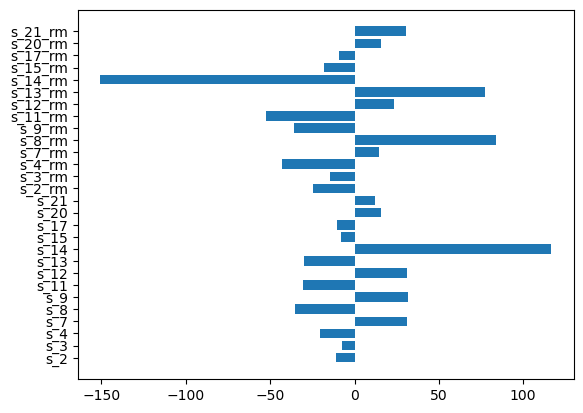

In [274]:
#BEST FEATURE FOR LINEAR REGRESSION MODEL

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X=X_train_tm_s, y=y_train_tm)
plt.barh(X_train_tm.columns, model.coef_)

<BarContainer object of 28 artists>

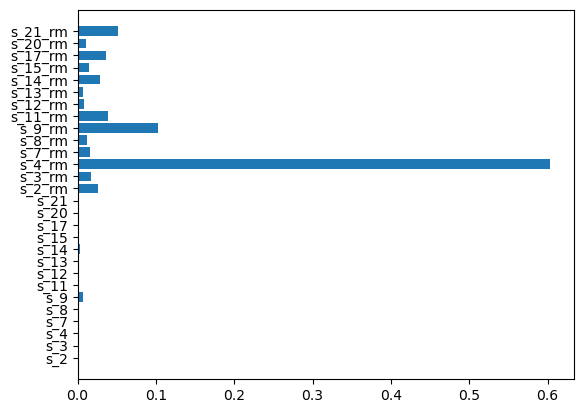

In [278]:
#BEST FEATURE FOR RF MODEL
rf.fit(X_train_tm_s, y_train_tm)
plt.barh(train_tm.columns, rf.feature_importances_)

<BarContainer object of 28 artists>

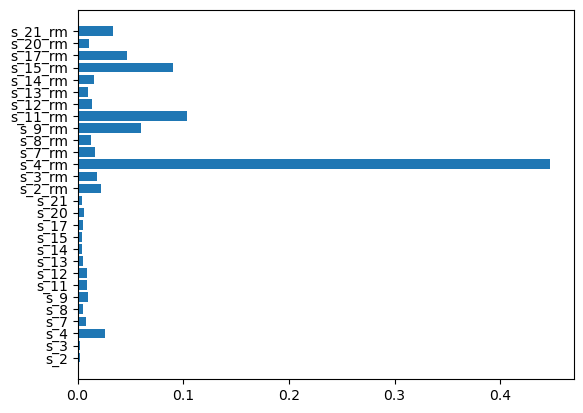

In [276]:
#BEST FEATURE FOR XGB MODEL
xgb.fit(X_train_tm_s, y_train_tm)
plt.barh(train_tm.columns, xgb.feature_importances_)

Creating new df

In [288]:
# Concatenate the 'unit_number', the feature matrix 'train_tm', and the 'RUL' column from the train dataframe
dftm= pd.concat([train['unit_number'],train_tm,train['RUL']],axis=1)

In [290]:
dftm


unit_number     s_2      s_3      s_4     s_7      s_8      s_9   s_11  \
0                1  641.82  1589.70  1400.60  554.36  2388.06  9046.19  47.47   
1                1  642.15  1591.82  1403.14  553.75  2388.04  9044.07  47.49   
2                1  642.35  1587.99  1404.20  554.26  2388.08  9052.94  47.27   
3                1  642.35  1582.79  1401.87  554.45  2388.11  9049.48  47.13   
4                1  642.37  1582.85  1406.22  554.00  2388.06  9055.15  47.28   
...            ...     ...      ...      ...     ...      ...      ...    ...   
20626          100  643.49  1597.98  1428.63  551.43  2388.19  9065.52  48.07   
20627          100  643.54  1604.50  1433.58  550.86  2388.23  9065.11  48.04   
20628          100  643.42  1602.46  1428.18  550.94  2388.24  9065.90  48.09   
20629          100  643.23  1605.26  1426.53  550.68  2388.25  9073.72  48.39   
20630          100  643.85  1600.38  1432.14  550.79  2388.26  9061.48  48.20   

         s_12     s_13  ...    s_9_rm  s_11_rm  s_12_rm   s_13_rm   s_14_rm  \
0      521.66  2388.02  ...  9046.190   47.470  521.660  2388.020  8138.620   
1      522.28  2388.07  ...  9044.070   47.490  522.280  2388.070  8131.490   
2      522.42  2388.03  ...  9052.940   47.270  522.420  2388.030  8133.230   
3      522.86  2388.08  ...  9049.480   47.130  522.860  2388.080  8133.830   
4      522.19  2388.04  ...  9055.150   47.280  522.190  2388.040  8133.800   
...       ...      ...  ...       ...      ...      ...       ...       ...   
20626  519.49  2388.26  ...  9066.903   48.116  519.840  2388.237  8141.170   
20627  519.68  2388.22  ...  9066.820   48.116  519.793  2388.237  8140.771   
20628  520.01  2388.24  ...  9066.642   48.096  519.796  2388.240  8140.882   
20629  519.67  2388.23  ...  9067.045   48.136  519.813  2388.239  8140.833   
20630  519.30  2388.26  ...  9067.045   48.136  519.813  2388.239  8140.833   

       s_15_rm  s_17_rm  s_20_rm   s_21_rm  RUL  
0      8.41950    392.0   39.060  23.41900  191  
1      8.43180    392.0   39.000  23.42360  190  
2      8.41780    390.0   38.950  23.34420  189  
3      8.36820    392.0   38.880  23.37390  188  
4      8.42940    393.0   38.900  23.40440  187  
...        ...      ...      ...       ...  ...  
20626  8.51031    396.0   38.453  23.09254    4  
20627  8.51083    395.9   38.416  23.08540    3  
20628  8.51915    396.2   38.424  23.07321    2  
20629  8.52434    396.0   38.388  23.07370    1  
20630  8.52434    396.0   38.388  23.07370    0  

[20631 rows x 30 columns]

### Plotting new features

In [295]:
def plot_signal(df, signal_name):
    # Create a new figure with specific size
    plt.figure(figsize=(13,5))

    # Loop through each unit_number and plot the signal for every 10th unit
    for i in df['unit_number'].unique():
        if (i % 10 == 0):  
            # Plot the rolling mean of the signal for the current unit
            plt.plot('RUL', signal_name, data=df[df['unit_number']==i].rolling(8).mean())

    # Set labels for the axes
    plt.ylabel(signal_name)  # Label the y-axis with the signal name
    plt.xlabel('Remaining Useful Life')  # Label the x-axis with 'RUL'

    # Display the plot
    plt.show()


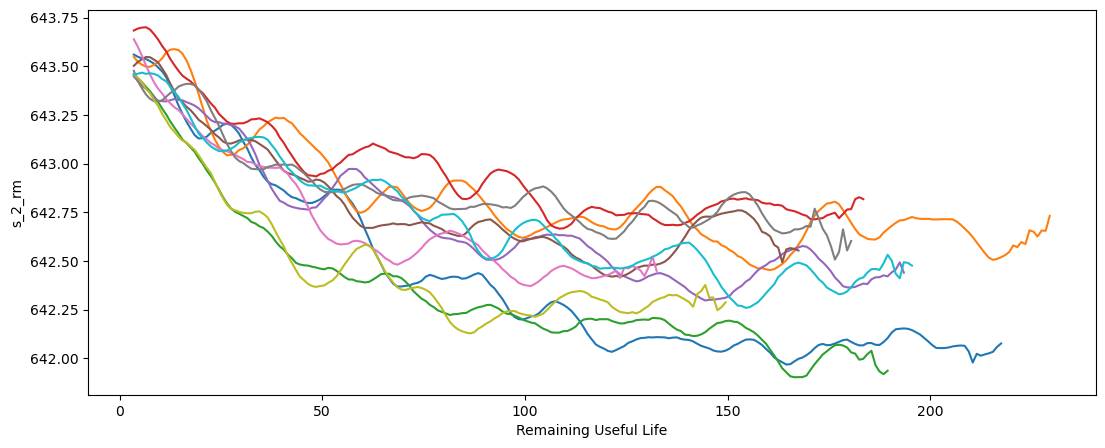

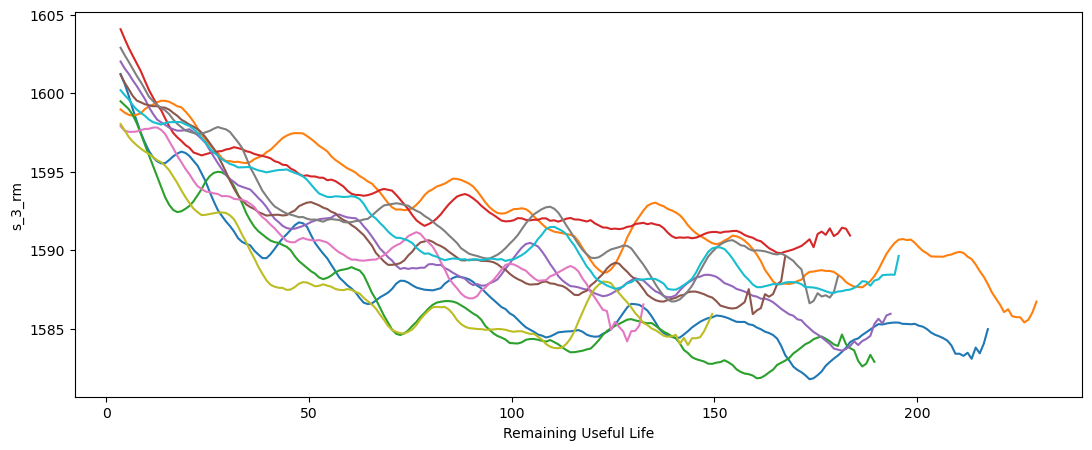

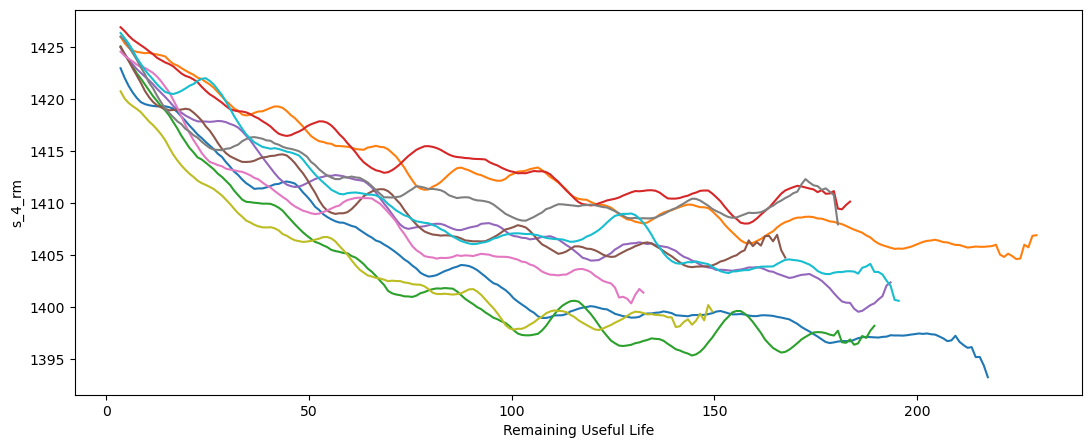

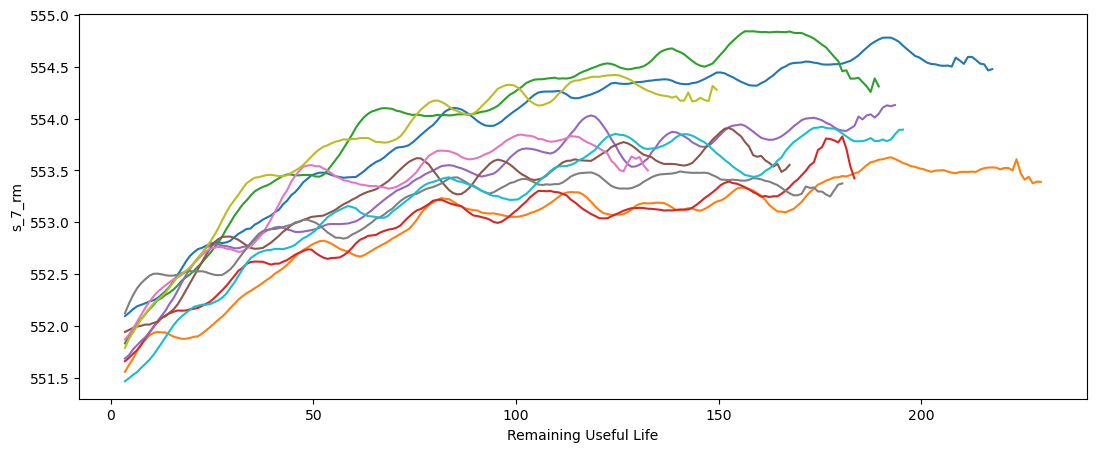

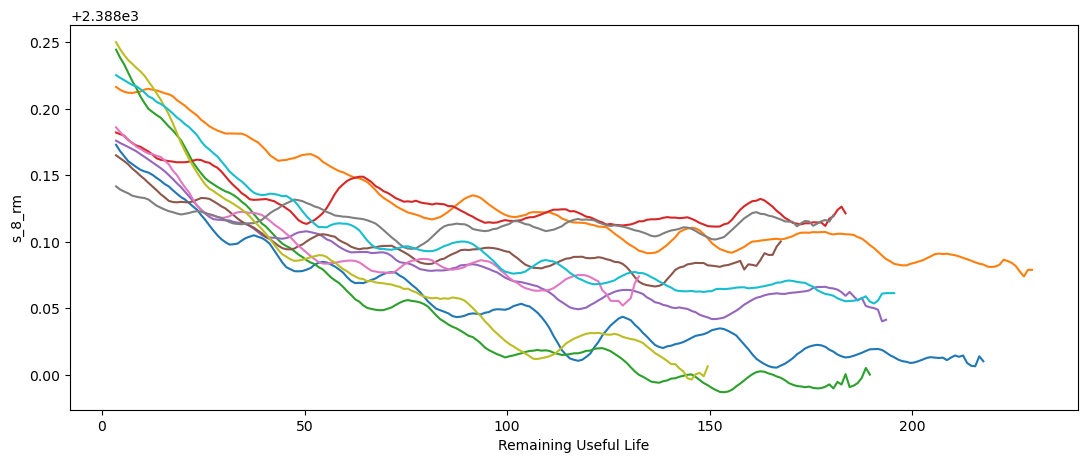

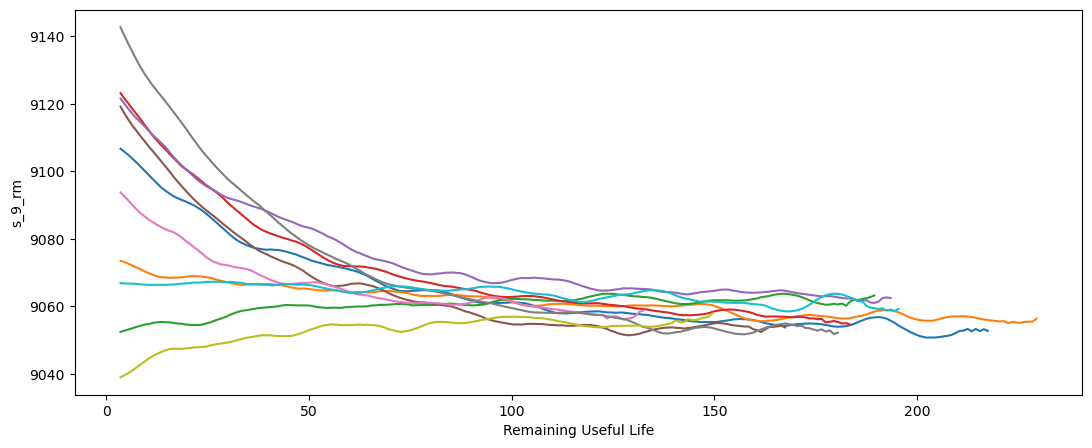

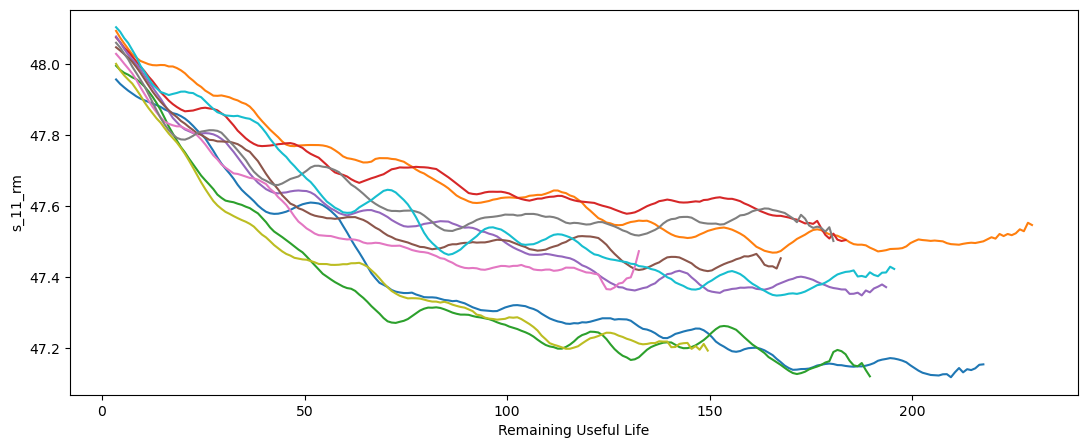

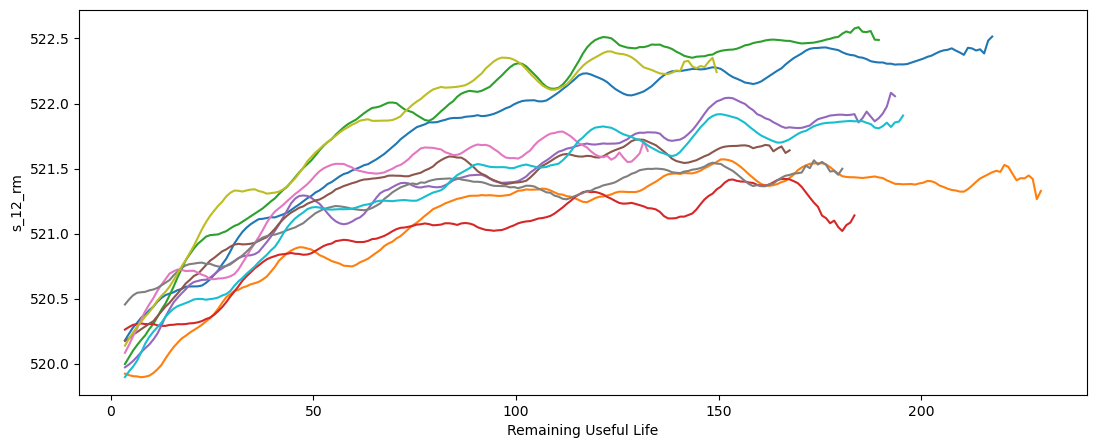

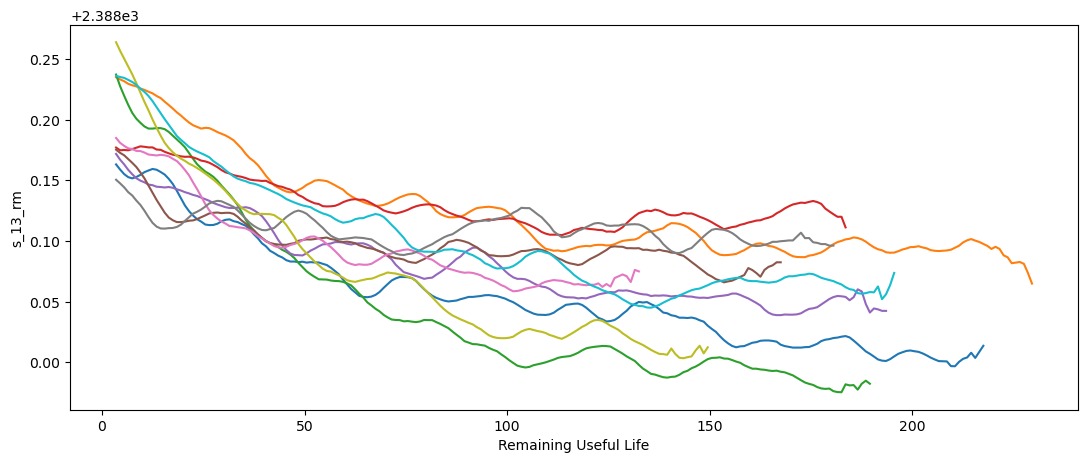

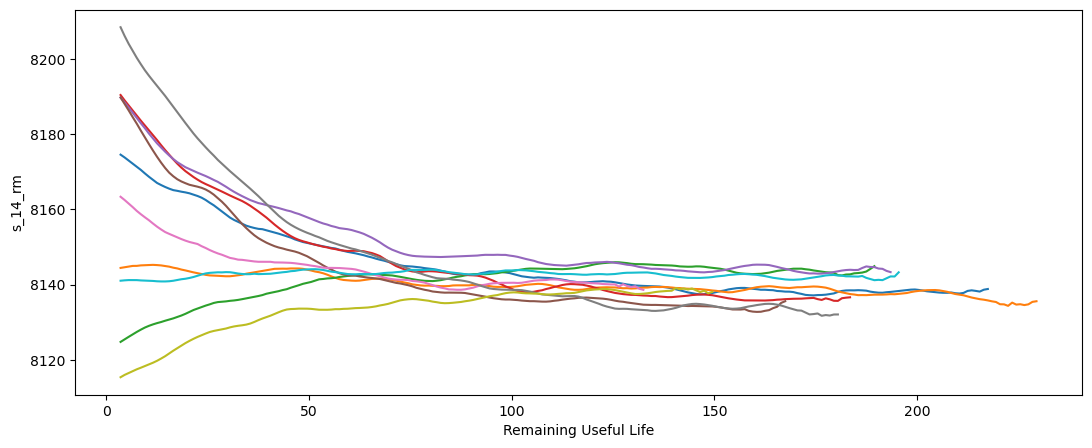

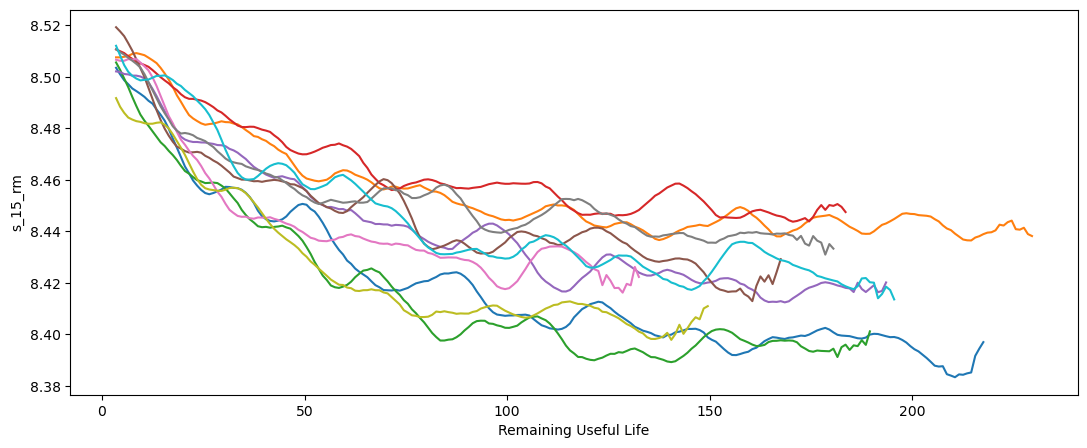

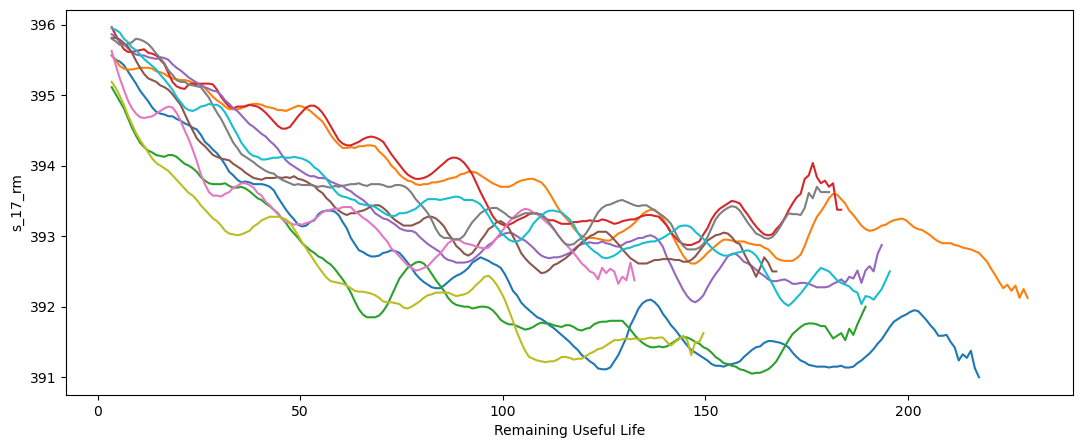

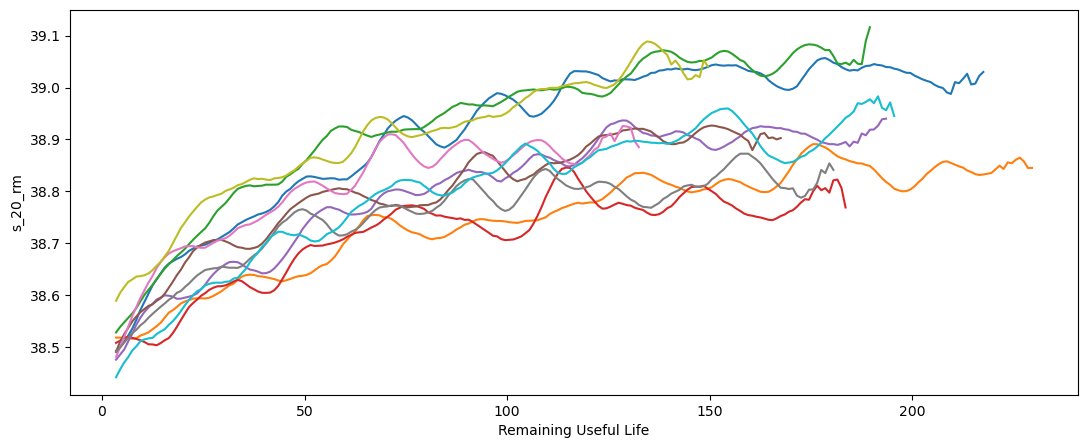

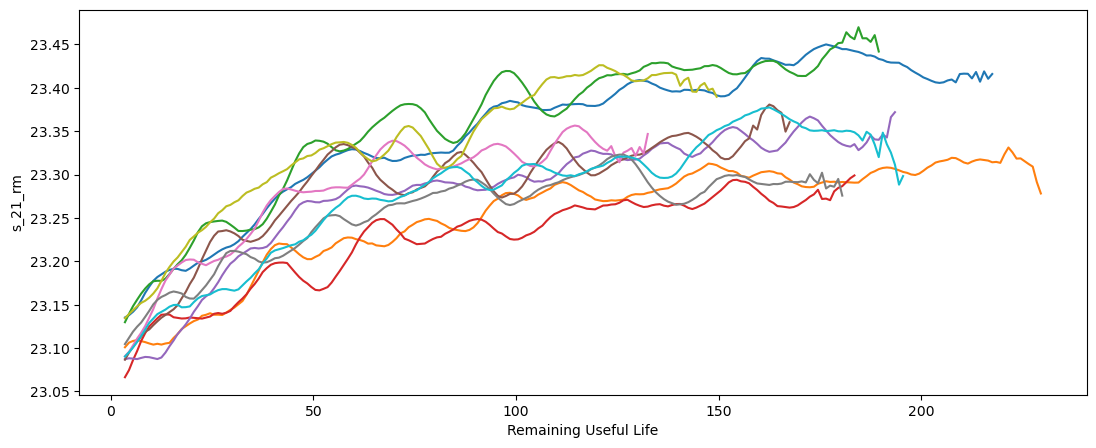

In [297]:
for i in range(1,22):
     if i not in [1,5,6,10,16,18,19] :
        try:
            plot_signal(dftm, 's_'+str(i)+'_rm')
        except:
            pass

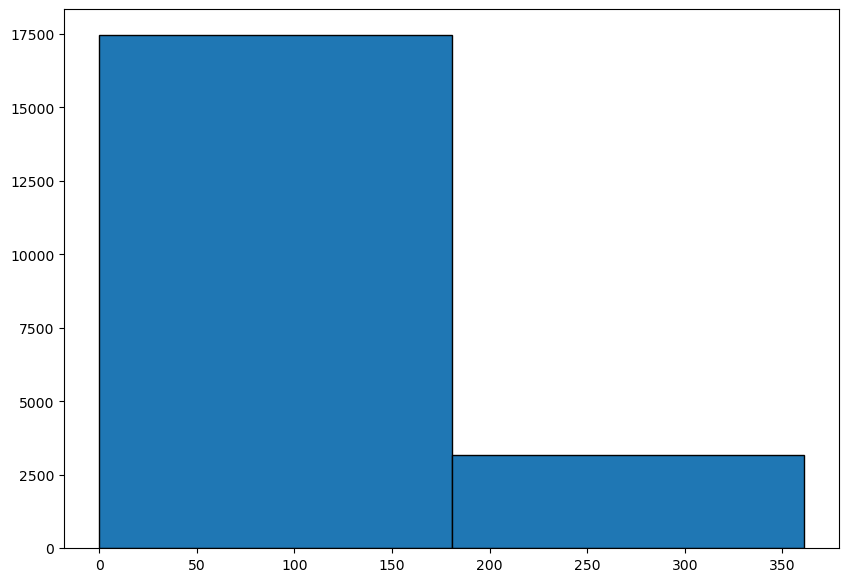

(array([17462.,  3169.]), array([  0. , 180.5, 361. ]), <BarContainer object of 2 artists>)


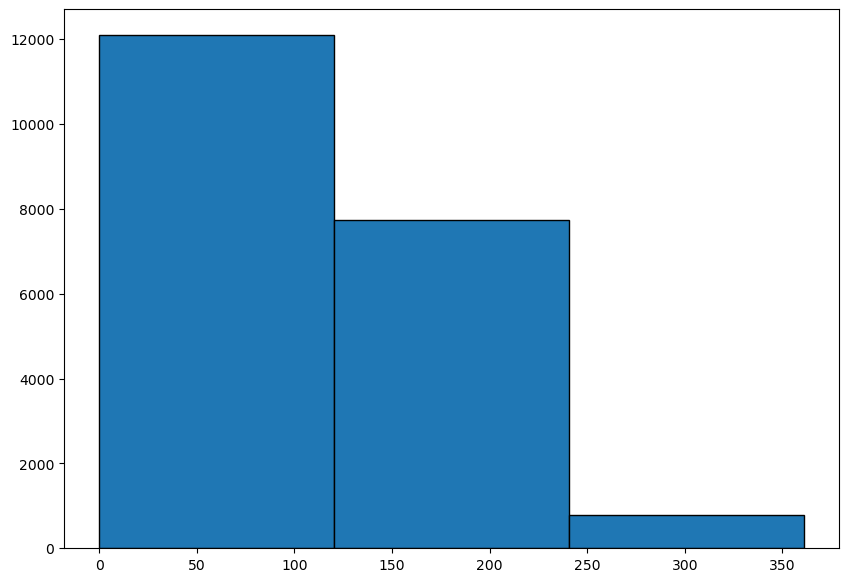

(array([12100.,  7735.,   796.]), array([  0.        , 120.33333333, 240.66666667, 361.        ]), <BarContainer object of 3 artists>)


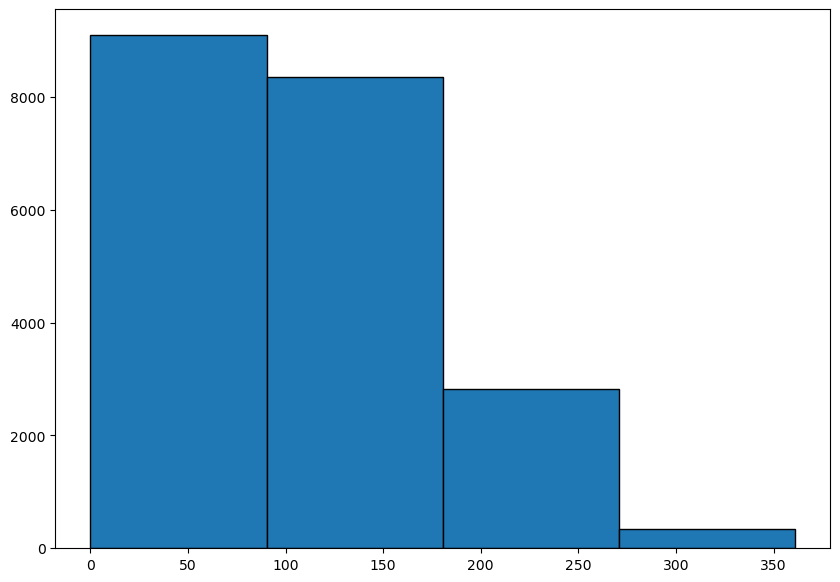

(array([9100., 8362., 2823.,  346.]), array([  0.  ,  90.25, 180.5 , 270.75, 361.  ]), <BarContainer object of 4 artists>)


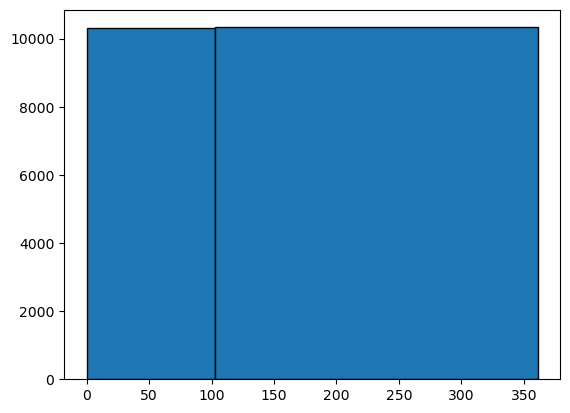

[  0. 103. 361.]


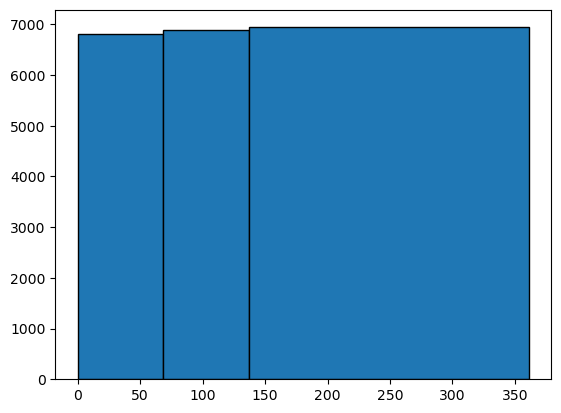

[  0.  68. 137. 361.]


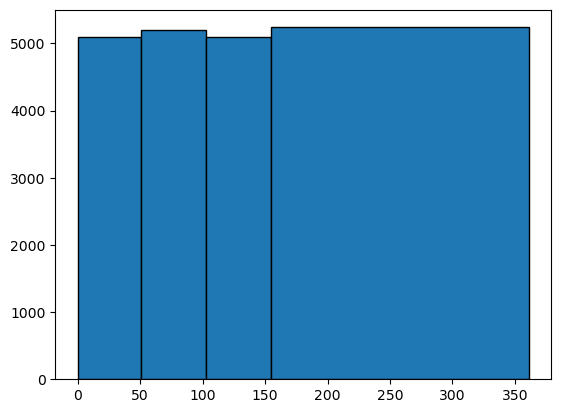

[  0.  51. 103. 155. 361.]


In [299]:
#-- fixing bins width -----
# Creating histogram of 2 bins(same width)
fig, ax = plt.subplots(figsize =(10, 7))
m=ax.hist(list(train['RUL']), bins = 2, edgecolor='black')
# Show plot
plt.show()
print(m)

# Creating histogram of 3 bins(same width)
fig, ax = plt.subplots(figsize =(10, 7))
m=ax.hist(list(train['RUL']), bins = 3, edgecolor='black')
# Show plot
plt.show()
print(m)

# Creating histogram of 4 bins(same width)
fig, ax = plt.subplots(figsize =(10, 7))
m=ax.hist(list(train['RUL']), bins = 4, edgecolor='black')
# Show plot
plt.show()
print(m)



#-- fixing bins height -----

l=len(list(train['RUL']))
k=l/4

#define function to calculate equal-frequency bins, bins=2
def equalObs(x, nbin):
    nlen = len(x)
    return np.interp(np.linspace(0, nlen, nbin + 1),
                     np.arange(nlen),
                     np.sort(x))

#create histogram with equal-frequency bins 
n, bins, patches = plt.hist(list(train['RUL']), equalObs(list(train['RUL']), 2), edgecolor='black')
plt.show()
print(bins)

#define function to calculate equal-frequency bins, bins=3
def equalObs(x, nbin):
    nlen = len(x)
    return np.interp(np.linspace(0, nlen, nbin + 1),
                     np.arange(nlen),
                     np.sort(x))

#create histogram with equal-frequency bins 
n, bins, patches = plt.hist(list(train['RUL']), equalObs(list(train['RUL']), 3), edgecolor='black')
plt.show()
print(bins)


#define function to calculate equal-frequency bins, bins=4
def equalObs(x, nbin):
    nlen = len(x)
    return np.interp(np.linspace(0, nlen, nbin + 1),
                     np.arange(nlen),
                     np.sort(x))

#create histogram with equal-frequency bins 
n, bins, patches = plt.hist(list(train['RUL']), equalObs(list(train['RUL']), 4), edgecolor='black')
plt.show()
print(bins)

In [301]:
y_train_tm

12276     30
8157      80
11666    103
12639    124
5278      30
        ... 
11284    107
11964    162
5390      74
860      195
15795    157
Name: RUL, Length: 13410, dtype: int64

In [303]:
# Define a label map to classify RUL into categories
label_map = {1: "RISK ZONE", 2: "MODERATED RISK", 3: "NO RISK"}

# Create an empty list to store the corresponding classes for RUL values
y = []

# Transforming RUL values into classes
for k in dftm['RUL']:
    if k <= 68:
        y.append(1)  # Assign "RISK ZONE" if RUL is less than or equal to 68
    elif 69 <= k <= 137:
        y.append(2)  # Assign "MODERATED RISK" if RUL is between 69 and 137
    else:
        y.append(3)  # Assign "NO RISK" if RUL is greater than 137

# Split the data into training and testing sets while maintaining the class distribution
X_train_tm_c, X_test_tm_c, y_train_tm_c, y_test_tm_c = train_test_split(
    dftm.drop(columns=['unit_number', 'RUL']),  # Drop 'unit_number' and 'RUL' columns
    np.array(y),  # Target values (classes)
    test_size=0.35,  # 35% for testing
    stratify=np.array(y)  # Stratify to maintain the class distribution
)

# Apply scaling to the features for training and testing datasets
X_train_tm_cs = scaler.fit_transform(X_train_tm_c)  # Fit and transform training data
X_test_tm_cs = scaler.fit_transform(X_test_tm_c)  # Fit and transform testing data


In [305]:
def mean_absolute_percentage_error(y_true, y_pred): 
    # Convert inputs to numpy arrays for element-wise operations
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Calculate MAPE
    return np.mean(np.abs((y_true - y_pred) / y_true))  # Return the mean of absolute percentage error


# Models Implementation

# SVC

In [309]:
# Initializing SVC model
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear',random_state = 1)

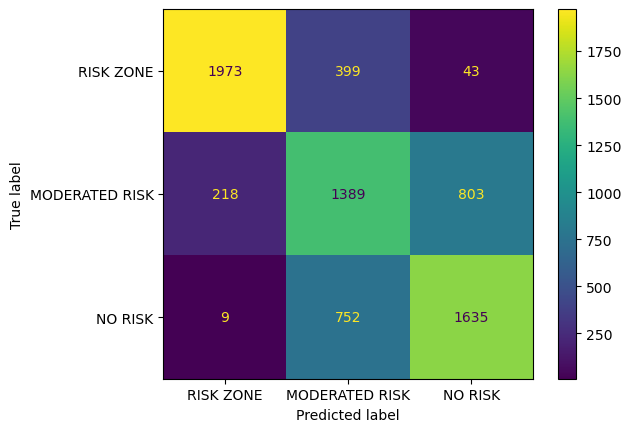

SVM
Accuracy score of training 0.691
Error rate of training 0.172
Accuracy score of test 0.692
Error rate of test 0.173
              precision    recall  f1-score   support

           1       0.90      0.82      0.86      2415
           2       0.55      0.58      0.56      2410
           3       0.66      0.68      0.67      2396

    accuracy                           0.69      7221
   macro avg       0.70      0.69      0.70      7221
weighted avg       0.70      0.69      0.70      7221



In [311]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

classifier.fit(X_train_tm_cs,np.array(y_train_tm_c))
y_svc_train=classifier.predict(X_train_tm_cs)

y_svc_test=classifier.predict(X_test_tm_cs)


cm= confusion_matrix(y_test_tm_c, y_svc_test, labels=classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[classifier.classes_[0]],label_map[classifier.classes_[1]],label_map[classifier.classes_[2]]])
disp.plot()
plt.show()

# Measure the performance
print('SVM')
print("Accuracy score of training %.3f" %metrics.accuracy_score(y_train_tm_c, y_svc_train))
print("Error rate of training %.3f" %mean_absolute_percentage_error(y_train_tm_c,y_svc_train))
print("Accuracy score of test %.3f" %metrics.accuracy_score(y_test_tm_c, y_svc_test))
print("Error rate of test %.3f" %mean_absolute_percentage_error(y_test_tm_c,y_svc_test))
print(metrics.classification_report(y_test_tm_c,y_svc_test))

In [319]:
y_valid_c=[]
for k in y_valid['RUL']:
    if k<=68:
        y_valid_c.append(1)
    elif k>69 and k<=137:
        y_valid_c.append(2)
    else:
        y_valid_c.append(3)
        
y_valid_c=np.array(y_valid_c)

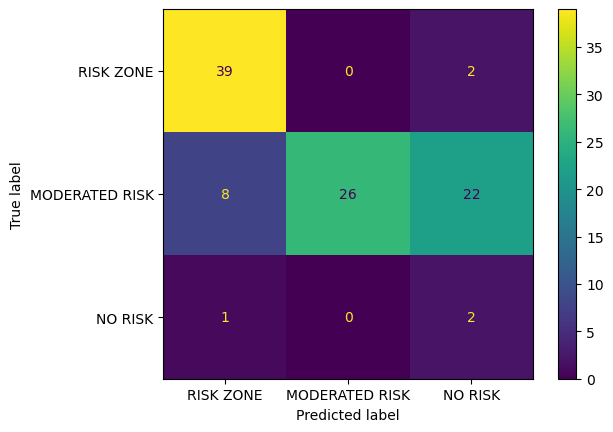

SVM
Accuracy score of validation 0.670
Error rate of validation 0.197


In [321]:
y_svc_valid=classifier.predict(X_valid_s)
cm= confusion_matrix(y_valid_c, y_svc_valid, labels=classifier.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[classifier.classes_[0]],label_map[classifier.classes_[1]],label_map[classifier.classes_[2]]])
disp.plot()
plt.show()
print('SVM')
print("Accuracy score of validation %.3f" %metrics.accuracy_score(y_valid_c,  y_svc_valid))
print("Error rate of validation %.3f" %mean_absolute_percentage_error(y_valid_c, y_svc_valid))

# Random forest

In [324]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

In [326]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=5)

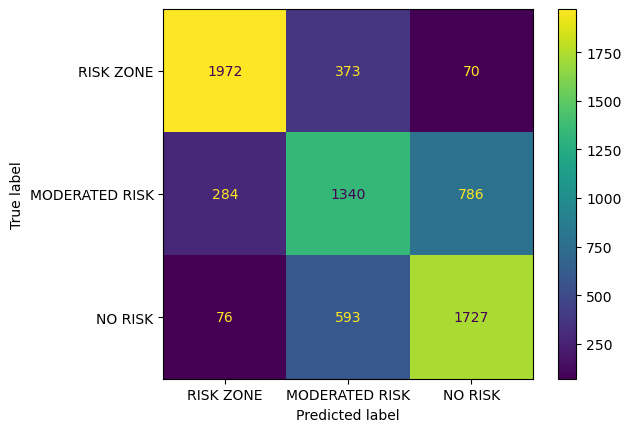

Random Forest Classifier
Accuracy score of train: 0.977
Error rate of train: 0.013
Accuracy score of test: 0.698
Error rate of test: 0.180
              precision    recall  f1-score   support

           1       0.85      0.82      0.83      2415
           2       0.58      0.56      0.57      2410
           3       0.67      0.72      0.69      2396

    accuracy                           0.70      7221
   macro avg       0.70      0.70      0.70      7221
weighted avg       0.70      0.70      0.70      7221



In [334]:
# Fit the Random Forest Classifier on the training data
clf.fit(X_train_tm_cs, np.array(y_train_tm_c))

# Predict using the trained model on training and test data
y_rfc_train = clf.predict(X_train_tm_cs)  # Predictions on the training set
y_rfc_test = clf.predict(X_test_tm_cs)    # Predictions on the test set

# Generate confusion matrix for the test predictions
cm = confusion_matrix(y_test_tm_c, y_rfc_test, labels=clf.classes_)  # Confusion matrix for test set
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[clf.classes_[0]], label_map[clf.classes_[1]], label_map[clf.classes_[2]]])  # Display labels mapped to classes
disp.plot()  # Plot the confusion matrix
plt.show()  # Show the plot

# Measure the performance on the training data
print('Random Forest Classifier')
print("Accuracy score of train: %.3f" % metrics.accuracy_score(y_train_tm_c, y_rfc_train))  # Accuracy on training set
print("Error rate of train: %.3f" % mean_absolute_percentage_error(y_train_tm_c, y_rfc_train))  # Error rate on training set

# Measure the performance on the test data
print("Accuracy score of test: %.3f" % metrics.accuracy_score(y_test_tm_c, y_rfc_test))  # Accuracy on test set
print("Error rate of test: %.3f" % mean_absolute_percentage_error(y_test_tm_c, y_rfc_test))  # Error rate on test set

# Detailed classification report on the test set
print(metrics.classification_report(y_test_tm_c, y_rfc_test))  # Print the classification report for test set


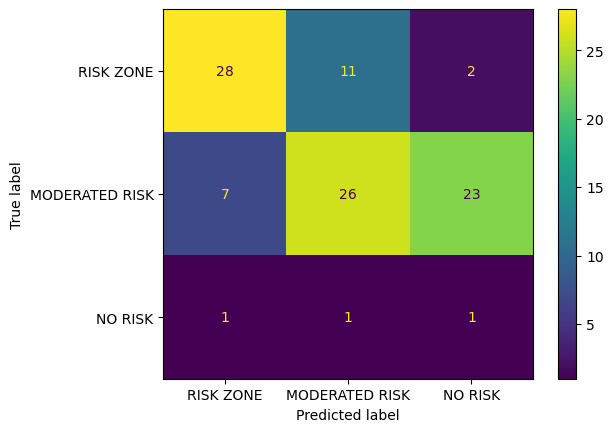

Random Forest Classifier
Accuracy score of validation: 0.550
Error rate of validation: 0.310
              precision    recall  f1-score   support

           1       0.78      0.68      0.73        41
           2       0.68      0.46      0.55        56
           3       0.04      0.33      0.07         3

    accuracy                           0.55       100
   macro avg       0.50      0.49      0.45       100
weighted avg       0.70      0.55      0.61       100



In [336]:
# Predict using the trained Random Forest Classifier on the validation data
y_rfc_valid = clf.predict(X_valid_s)  # Predictions on the validation set

# Generate confusion matrix for the validation predictions
cm = confusion_matrix(y_valid_c, y_rfc_valid, labels=clf.classes_)  # Confusion matrix for validation set

# Display the confusion matrix with labeled categories
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[clf.classes_[0]], label_map[clf.classes_[1]], label_map[clf.classes_[2]]])  # Label the classes
disp.plot()  # Plot the confusion matrix
plt.show()  # Show the plot

# Measure the performance on the validation data
print('Random Forest Classifier')
print("Accuracy score of validation: %.3f" % metrics.accuracy_score(y_valid_c, y_rfc_valid))  # Accuracy on validation set
print("Error rate of validation: %.3f" % mean_absolute_percentage_error(y_valid_c, y_rfc_valid))  # Error rate on validation set

# Print detailed classification report for validation predictions
print(metrics.classification_report(y_valid_c, y_rfc_valid))  # Detailed classification report for validation set


# Naive bayes

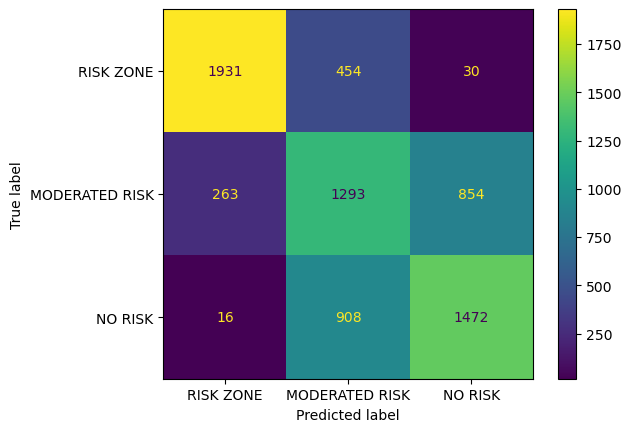

Gaussian Naive Bayes
Accuracy score of train: 0.639
Error rate of train: 0.198
Accuracy score of test: 0.650
Error rate of test: 0.192
              precision    recall  f1-score   support

           1       0.87      0.80      0.84      2415
           2       0.49      0.54      0.51      2410
           3       0.62      0.61      0.62      2396

    accuracy                           0.65      7221
   macro avg       0.66      0.65      0.66      7221
weighted avg       0.66      0.65      0.66      7221



In [339]:
from sklearn.naive_bayes import GaussianNB

# Initialize and fit the Gaussian Naive Bayes classifier
gnb = GaussianNB()  # Gaussian Naive Bayes model
gnb.fit(X_train_tm_cs, np.array(y_train_tm_c))  # Train the model on scaled training data

# Make predictions for train and test datasets
y_gnb_train = gnb.predict(X_train_tm_cs)  # Predictions on training data
y_gnb_test = gnb.predict(X_test_tm_cs)    # Predictions on test data

# Generate confusion matrix for the test data
cm = confusion_matrix(y_test_tm_c, y_gnb_test, labels=gnb.classes_)  # Confusion matrix for test set

# Display the confusion matrix with labeled categories
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[gnb.classes_[0]], label_map[gnb.classes_[1]], label_map[gnb.classes_[2]]])  # Label classes
disp.plot()  # Plot the confusion matrix
plt.show()  # Display the plot

# Measure the performance on the train and test datasets
print('Gaussian Naive Bayes')
print("Accuracy score of train: %.3f" % metrics.accuracy_score(y_train_tm_c, y_gnb_train))  # Accuracy on training data
print("Error rate of train: %.3f" % mean_absolute_percentage_error(y_train_tm_c, y_gnb_train))  # Error rate on training data
print("Accuracy score of test: %.3f" % metrics.accuracy_score(y_test_tm_c, y_gnb_test))  # Accuracy on test data
print("Error rate of test: %.3f" % mean_absolute_percentage_error(y_test_tm_c, y_gnb_test))  # Error rate on test data

# Print detailed classification report for test predictions
print(metrics.classification_report(y_test_tm_c, y_gnb_test))  # Classification report for test set


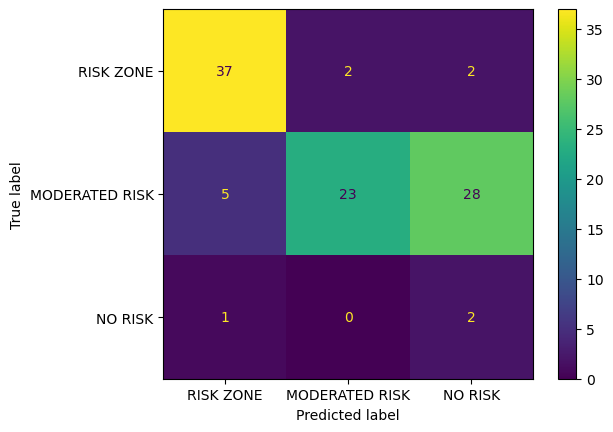

Gaussian Naive Bayes
Accuracy score of validation: 0.620
Error rate of validation: 0.232
              precision    recall  f1-score   support

           1       0.86      0.90      0.88        41
           2       0.92      0.41      0.57        56
           3       0.06      0.67      0.11         3

    accuracy                           0.62       100
   macro avg       0.61      0.66      0.52       100
weighted avg       0.87      0.62      0.68       100



In [342]:
# Make predictions for the validation dataset using the trained Gaussian Naive Bayes model
y_gnb_valid = gnb.predict(X_valid_s)  # Predictions on the validation data

# Generate confusion matrix for the validation dataset
cm = confusion_matrix(y_valid_c, y_gnb_valid, labels=gnb.classes_)  # Confusion matrix for validation set

# Display the confusion matrix with labeled categories for the validation dataset
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[gnb.classes_[0]], label_map[gnb.classes_[1]], label_map[gnb.classes_[2]]])  # Label classes
disp.plot()  # Plot the confusion matrix
plt.show()  # Display the plot

# Measure the performance on the validation dataset
print('Gaussian Naive Bayes')
print("Accuracy score of validation: %.3f" % metrics.accuracy_score(y_valid_c, y_gnb_valid))  # Accuracy on validation data
print("Error rate of validation: %.3f" % mean_absolute_percentage_error(y_valid_c, y_gnb_valid))  # Error rate on validation data

# Print detailed classification report for validation predictions
print(metrics.classification_report(y_valid_c, y_gnb_valid))  # Classification report for validation set


# KNN

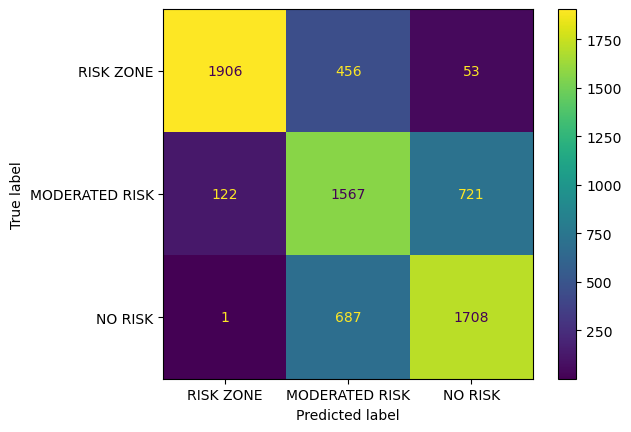

KNN
Accuracy score of train: 0.718
Error rate of train: 0.169
Accuracy score of test: 0.717
Error rate of test: 0.168
              precision    recall  f1-score   support

           1       0.94      0.79      0.86      2415
           2       0.58      0.65      0.61      2410
           3       0.69      0.71      0.70      2396

    accuracy                           0.72      7221
   macro avg       0.74      0.72      0.72      7221
weighted avg       0.74      0.72      0.72      7221



In [346]:
# Importing KNeighborsClassifier from sklearn
from sklearn.neighbors import KNeighborsClassifier

# Initialize the K-Nearest Neighbors classifier with 100 neighbors
knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(X_train_tm_cs, np.array(y_train_tm_c))  # Train the model on the training data

# Make predictions on the test dataset
y_knn_test = knn.predict(X_test_tm_cs)  # Predictions on the test data
y_knn_train = knn.predict(X_train_tm_cs)  # Predictions on the train data

# Generate confusion matrix for the test dataset
cm = confusion_matrix(y_test_tm_c, y_knn_test, labels=knn.classes_)  # Confusion matrix for test set

# Display the confusion matrix with labeled categories for the test dataset
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[knn.classes_[0]], label_map[knn.classes_[1]], label_map[knn.classes_[2]]])  # Label classes
disp.plot()  # Plot the confusion matrix
plt.show()  # Display the plot

# Measure the performance on the training and test datasets
print('KNN')
print("Accuracy score of train: %.3f" % metrics.accuracy_score(y_train_tm_c, y_knn_train))  # Accuracy on train data
print("Error rate of train: %.3f" % mean_absolute_percentage_error(y_train_tm_c, y_knn_train))  # Error rate on train data
print("Accuracy score of test: %.3f" % metrics.accuracy_score(y_test_tm_c, y_knn_test))  # Accuracy on test data
print("Error rate of test: %.3f" % mean_absolute_percentage_error(y_test_tm_c, y_knn_test))  # Error rate on test data

# Print detailed classification report for the test predictions
print(metrics.classification_report(y_test_tm_c, y_knn_test))  # Classification report for test set


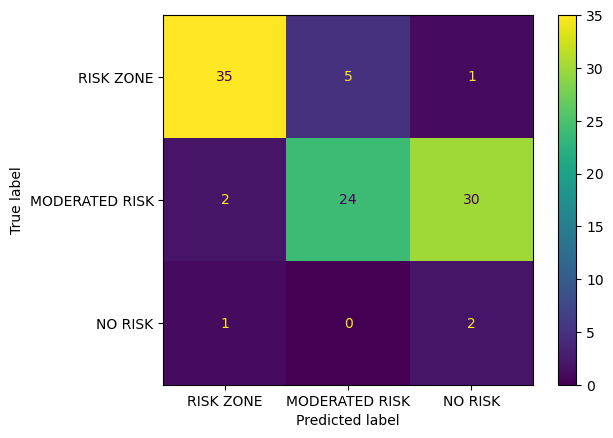

KNN
Accuracy score of validation 0.610
Error rate of validation 0.237
              precision    recall  f1-score   support

           1       0.92      0.85      0.89        41
           2       0.83      0.43      0.56        56
           3       0.06      0.67      0.11         3

    accuracy                           0.61       100
   macro avg       0.60      0.65      0.52       100
weighted avg       0.84      0.61      0.68       100



In [348]:
# Make predictions on the validation dataset using the trained KNN model
y_knn_valid = knn.predict(X_valid_s)

# Generate confusion matrix for the validation dataset
cm = confusion_matrix(y_valid_c, y_knn_valid, labels=knn.classes_)

# Display the confusion matrix with labeled categories for the validation dataset
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[knn.classes_[0]], label_map[knn.classes_[1]], label_map[knn.classes_[2]]])
disp.plot()  # Plot the confusion matrix
plt.show()  # Display the plot

# Measure the performance on the validation dataset
print('KNN')
print("Accuracy score of validation %.3f" % metrics.accuracy_score(y_valid_c, y_knn_valid))  # Accuracy on validation data
print("Error rate of validation %.3f" % mean_absolute_percentage_error(y_valid_c, y_knn_valid))  # Error rate on validation data

# Print detailed classification report for the validation predictions
print(metrics.classification_report(y_valid_c, y_knn_valid))  # Classification report for validation set


# Running cross validation on SVC (best model so far)

In [351]:
def transform_to_classes(d):
    y=[]
    for k in d:
        if k<=68:
            y.append(1)
        elif k>69 and k<=137:
            y.append(2)
        else:
            y.append(3)
    return y

Index du train :  [    0     1     2 ... 20627 20628 20629] 

Index de test :  [    3    11    17 ... 20620 20622 20630]


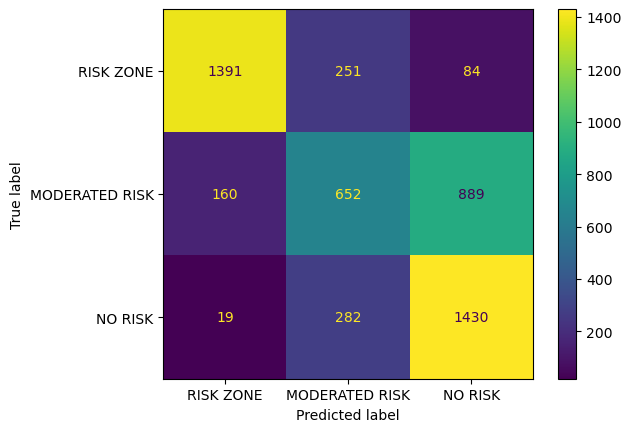

SVM
Accuracy score of training 0.691
Error rate of training 0.174
Accuracy score of test 0.673
Error rate of test 0.204
              precision    recall  f1-score   support

           1       0.89      0.81      0.84      1726
           2       0.55      0.38      0.45      1701
           3       0.60      0.83      0.69      1731

    accuracy                           0.67      5158
   macro avg       0.68      0.67      0.66      5158
weighted avg       0.68      0.67      0.66      5158

Index du train :  [    0     3     4 ... 20628 20629 20630] 

Index de test :  [    1     2     6 ... 20614 20619 20621]


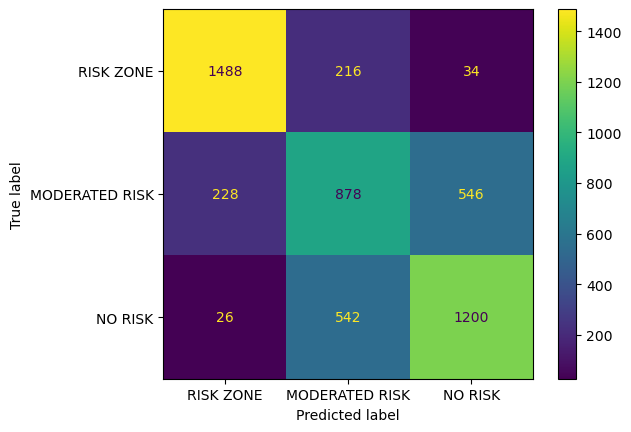

SVM
Accuracy score of training 0.686
Error rate of training 0.175
Accuracy score of test 0.691
Error rate of test 0.168
              precision    recall  f1-score   support

           1       0.85      0.86      0.86      1738
           2       0.54      0.53      0.53      1652
           3       0.67      0.68      0.68      1768

    accuracy                           0.69      5158
   macro avg       0.69      0.69      0.69      5158
weighted avg       0.69      0.69      0.69      5158

Index du train :  [    1     2     3 ... 20626 20627 20630] 

Index de test :  [    0    14    18 ... 20623 20628 20629]


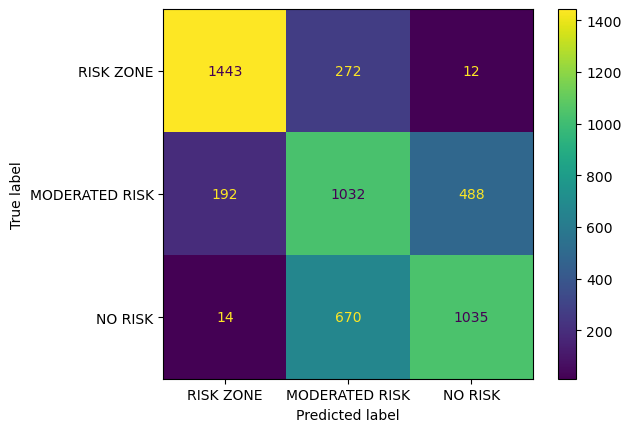

SVM
Accuracy score of training 0.689
Error rate of training 0.174
Accuracy score of test 0.680
Error rate of test 0.168
              precision    recall  f1-score   support

           1       0.88      0.84      0.85      1727
           2       0.52      0.60      0.56      1712
           3       0.67      0.60      0.64      1719

    accuracy                           0.68      5158
   macro avg       0.69      0.68      0.68      5158
weighted avg       0.69      0.68      0.68      5158

Index du train :  [    0     1     2 ... 20628 20629 20630] 

Index de test :  [    4     5     7 ... 20625 20626 20627]


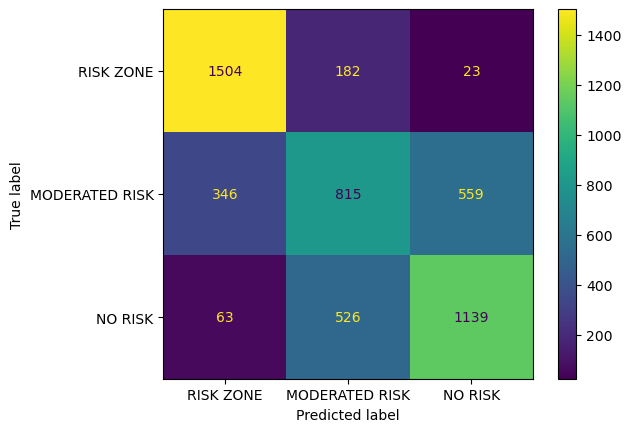

SVM
Accuracy score of training 0.687
Error rate of training 0.175
Accuracy score of test 0.671
Error rate of test 0.174
              precision    recall  f1-score   support

           1       0.79      0.88      0.83      1709
           2       0.54      0.47      0.50      1720
           3       0.66      0.66      0.66      1728

    accuracy                           0.67      5157
   macro avg       0.66      0.67      0.66      5157
weighted avg       0.66      0.67      0.66      5157



In [353]:
from sklearn.model_selection import KFold
train_tm_cv=dftm.drop(columns=['unit_number','RUL']).copy()
y=dftm['RUL']
cv = KFold(n_splits=4, shuffle=True)
for train_index, test_index in cv.split(train_tm) :
    print("Index du train : ", train_index, "\n")
    print("Index de test : ", test_index)
    X_train, X_test, y_train, y_test = train_tm_cv.iloc[train_index,:], train_tm_cv.iloc[test_index,:],np.array(transform_to_classes(y[train_index])), np.array(transform_to_classes(y[test_index]))
    classifier.fit(scaler.fit_transform(X_train), y_train)
    y_svc_train=classifier.predict(scaler.fit_transform(X_train))

    y_svc_test=classifier.predict(scaler.fit_transform(X_test))


    cm= confusion_matrix(y_test, y_svc_test, labels=classifier.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[classifier.classes_[0]],label_map[classifier.classes_[1]],label_map[classifier.classes_[2]]])
    disp.plot()
    plt.show()

    # Measure the performance
    print('SVM')
    print("Accuracy score of training %.3f" %metrics.accuracy_score(y_train, y_svc_train))
    print("Error rate of training %.3f" %mean_absolute_percentage_error(y_train,y_svc_train))
    print("Accuracy score of test %.3f" %metrics.accuracy_score(y_test, y_svc_test))
    print("Error rate of test %.3f" %mean_absolute_percentage_error(y_test,y_svc_test))
    print(metrics.classification_report(y_test,y_svc_test))